<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project4_storms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Storms
In this project, we will use Dedalus to solve the 2-layer quasi-geostrophic equations to model the development of atmospheric storm systems.

The two-layer quasi-geostrophic (QG) equations describe the motion of two vertically-stacked shallow layers of fluid in the limit where the Rossby number, $Ro=U/fL$ is small, where $U$ is a characteristic velocity scale, $L$ is a characteristic horizontal lengthscale, and $f$ is the Coriolis parameter. Here, we will use `1` to refer to quantitites in the upper layer and `2` to refer to quantities in the lower layer.

The fluid in the upper layer is lighter than the fluid in the lower layer (such that $\rho_1<\rho_2$). When the interface separating the upper and lower layers isn't flat, the varying thicknesses of the upper and lower layers implies that there are horizontal gradients in the hydrostatic pressure. When the Rossby number is small, $Ro\ll 1$, the flow will tend to be close to geostrophic balance a velocity difference between the upper and lower layer that balances the horizontal pressure gradients.

Student tasks are in [Section 1.5](#section1pt5), [Section 2.3](#section2pt3), and [Section 3.1](#section3pt1).

## 1. Two-layer quasi-geostrophic equations in a periodic box

In this section we will solve a non-dimensional version of the two-layer QG equations in Cartesian coordinates. Let $+x$ denote the eastwards direction and $+y$ denote the northwards direction. We start with a flow in geostrophic balance where the velocity is constant in each layer. Let $U \hat{\mathbf{x}}$ denote the velocity in the top layer and $-U \hat{\mathbf{x}}$ denote the velocity in the bottom layer. Geostrophic balance then implies that the interface has a constant, non-zero slope. We will invoke the so-called "beta-plane" approximation and make the Coriolis parameter a linear function of $y$.

In this section we solve for the departures to the background state described above. We let $q_1$ and $q_2$ denote the perturbation QG potential vorticity and $\psi_1$ and $\psi_2$ denote the perturbation streamfunction. Although the background state is not periodic, we apply periodic boundary conditions in $x$ and $y$ to the perturbation quantities. This has the effect of maintaining the north/south potential vorticity gradient associated with the background state.

### 1.1 Governing equations

The script below solves the following equations:

$$ \partial_t(q_1) + U \partial_x(q_1) + \frac{2U}{R_{d1}^2}\partial_x(\psi_1)-\nu \nabla^2 q_1 = - J(\psi_1, q_1), $$

$$ \partial_t(q_2) - U \partial_x(q_2) - \frac{2U}{R_{d2}^2}\partial_x(\psi_2)-\nu \nabla^2 q_2 = - J(\psi_2, q_2), $$

where $R_{d1,2}=\sqrt{g'H_{1,2}}/f_0$ is the internal deformation radius in each layer, $g'=(\rho_2-\rho_1)/\rho_0$ is the reduced gravity, $\rho_0$ is a reference density, $J(a,b)=\partial_x(a)\partial_y(b) - \partial_y(a)\partial_x(b)$ is the Jacobian operator and $\nu$ is a viscosity which is added to keep the model stable.

In addition to the equations above, two other equations relate the perturbation potential vorticity and streamfunctions:

$$q_1=\nabla^2\psi_1 - \frac{\psi_1-\psi_2}{R_{d1}^2}, $$
$$q_2=\nabla^2\psi_2 + \frac{\psi_1-\psi_2}{R_{d2}^2}. $$

### 1.2 Tau method

The equations above are invariant to a constant added to $\psi_1-\psi_2$. Therefore, there are infinitely many solutions to the above equations and the coefficient matrix associated with the discretized equations will be singular. To avoid this, we can add an extra equation to the system to set this constant offset. Here, we do this by including the following equation:

$$ \int\int \psi_1 dxdy = 0 $$

which in effect ensures that the spatial mean of $\psi_1$ is zero. The problem now is that we have five equations for four unknowns. One fix is to include another unknown in our system. We will include a constant called $\tau_{\psi1}$ and we will add it to the equation relating the upper layer QG potential voricity and streamfunction which then becomes:

$$q_1=\nabla^2\psi_1 - \frac{\psi_1-\psi_2}{R_{d1}^2} + \tau_{\psi1}. $$

Since adding a constant to the potential vorticity and streamfunction doesn't have any impact on the dynamics of the system, adding $\tau_{\psi1}$ here won't cause any problems and we now have a fully constained set of equations.


Set up Dedalus

In [32]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


### 1.3 Dedalus script

The script below solves the 2-layer QG equations given above with non-dimensional parameters. Note that the velocity gets faster as the simulation progresses. If you find that the code blows up (returns NaNs and a white screen), try reducing the timestep.

In [33]:
# # Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 64 # Number of gridpoints in x
Ny = 64 # Number of gridpoints in y
Lx = 100 # Domain size in x
Ly = 100 # Domain size in y
Rd1 = 3 # Deformation radius in layer 1
Rd2 = 3 # Deformation radius in layer 2
U = 1 # Background velocity in layer 1

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu = 0.2

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/U/100 # This is just an estimate based on the background velocity
stop_sim_time = 70

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Set the initial conditions
q1.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
q2.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U*dx(q1) + (2*U/Rd1**2.0)*dx(psi1) - nu*lap(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1)")
problem.add_equation("dt(q2) - U*dx(q2) - (2*U/Rd2**2.0)*dx(psi2) - nu*lap(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2)")

problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK443)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];
t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)

INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 2.9e+01/s


2024-12-27 13:41:17,679 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 2.9e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 3.1e+01/s


2024-12-27 13:41:17,774 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 3.1e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 3.0e+01/s


2024-12-27 13:41:17,916 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 3.0e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 1s, Rate: 3.0e+01/s


2024-12-27 13:41:18,051 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 1s, Rate: 3.0e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 1s, Remaining: 1s, Rate: 2.3e+01/s


2024-12-27 13:41:18,341 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 1s, Remaining: 1s, Rate: 2.3e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.2e+01/s


2024-12-27 13:41:18,573 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.2e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 2.1e+01/s


2024-12-27 13:41:18,777 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 2.1e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 2s, Remaining: 0s, Rate: 1.9e+01/s


2024-12-27 13:41:19,155 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 2s, Remaining: 0s, Rate: 1.9e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 1.8e+01/s


2024-12-27 13:41:19,448 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 1.8e+01/s


INFO:__main__:Starting main loop


2024-12-27 13:41:19,471 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e-03, dt=7.812500e-03


2024-12-27 13:41:19,770 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e-03, dt=7.812500e-03


INFO:__main__:Iteration=11, Time=8.593750e-02, dt=7.812500e-03


2024-12-27 13:41:20,362 __main__ 0/1 INFO :: Iteration=11, Time=8.593750e-02, dt=7.812500e-03


INFO:__main__:Iteration=21, Time=1.640625e-01, dt=7.812500e-03


2024-12-27 13:41:21,009 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e-01, dt=7.812500e-03


INFO:__main__:Iteration=31, Time=2.421875e-01, dt=7.812500e-03


2024-12-27 13:41:21,712 __main__ 0/1 INFO :: Iteration=31, Time=2.421875e-01, dt=7.812500e-03


INFO:__main__:Iteration=41, Time=3.203125e-01, dt=7.812500e-03


2024-12-27 13:41:22,310 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e-01, dt=7.812500e-03


INFO:__main__:Iteration=51, Time=3.984375e-01, dt=7.812500e-03


2024-12-27 13:41:22,951 __main__ 0/1 INFO :: Iteration=51, Time=3.984375e-01, dt=7.812500e-03


INFO:__main__:Iteration=61, Time=4.765625e-01, dt=7.812500e-03


2024-12-27 13:41:23,440 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e-01, dt=7.812500e-03


INFO:__main__:Iteration=71, Time=5.546875e-01, dt=7.812500e-03


2024-12-27 13:41:23,998 __main__ 0/1 INFO :: Iteration=71, Time=5.546875e-01, dt=7.812500e-03


INFO:__main__:Iteration=81, Time=6.328125e-01, dt=7.812500e-03


2024-12-27 13:41:24,544 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e-01, dt=7.812500e-03


INFO:__main__:Iteration=91, Time=7.109375e-01, dt=7.812500e-03


2024-12-27 13:41:25,089 __main__ 0/1 INFO :: Iteration=91, Time=7.109375e-01, dt=7.812500e-03


INFO:__main__:Iteration=101, Time=7.890625e-01, dt=7.812500e-03


2024-12-27 13:41:25,770 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e-01, dt=7.812500e-03


INFO:__main__:Iteration=111, Time=8.671875e-01, dt=7.812500e-03


2024-12-27 13:41:26,870 __main__ 0/1 INFO :: Iteration=111, Time=8.671875e-01, dt=7.812500e-03


INFO:__main__:Iteration=121, Time=9.453125e-01, dt=7.812500e-03


2024-12-27 13:41:27,989 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e-01, dt=7.812500e-03


INFO:__main__:Iteration=131, Time=1.023438e+00, dt=7.812500e-03


2024-12-27 13:41:28,904 __main__ 0/1 INFO :: Iteration=131, Time=1.023438e+00, dt=7.812500e-03


INFO:__main__:Iteration=141, Time=1.101562e+00, dt=7.812500e-03


2024-12-27 13:41:30,596 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+00, dt=7.812500e-03


INFO:__main__:Iteration=151, Time=1.179688e+00, dt=7.812500e-03


2024-12-27 13:41:31,133 __main__ 0/1 INFO :: Iteration=151, Time=1.179688e+00, dt=7.812500e-03


INFO:__main__:Iteration=161, Time=1.257812e+00, dt=7.812500e-03


2024-12-27 13:41:31,814 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+00, dt=7.812500e-03


INFO:__main__:Iteration=171, Time=1.335938e+00, dt=7.812500e-03


2024-12-27 13:41:32,449 __main__ 0/1 INFO :: Iteration=171, Time=1.335938e+00, dt=7.812500e-03


INFO:__main__:Iteration=181, Time=1.414062e+00, dt=7.812500e-03


2024-12-27 13:41:33,087 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+00, dt=7.812500e-03


INFO:__main__:Iteration=191, Time=1.492188e+00, dt=7.812500e-03


2024-12-27 13:41:33,899 __main__ 0/1 INFO :: Iteration=191, Time=1.492188e+00, dt=7.812500e-03


INFO:__main__:Iteration=201, Time=1.570312e+00, dt=7.812500e-03


2024-12-27 13:41:34,503 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+00, dt=7.812500e-03


INFO:__main__:Iteration=211, Time=1.648438e+00, dt=7.812500e-03


2024-12-27 13:41:35,188 __main__ 0/1 INFO :: Iteration=211, Time=1.648438e+00, dt=7.812500e-03


INFO:__main__:Iteration=221, Time=1.726562e+00, dt=7.812500e-03


2024-12-27 13:41:35,610 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+00, dt=7.812500e-03


INFO:__main__:Iteration=231, Time=1.804688e+00, dt=7.812500e-03


2024-12-27 13:41:36,148 __main__ 0/1 INFO :: Iteration=231, Time=1.804688e+00, dt=7.812500e-03


INFO:__main__:Iteration=241, Time=1.882812e+00, dt=7.812500e-03


2024-12-27 13:41:36,431 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+00, dt=7.812500e-03


INFO:__main__:Iteration=251, Time=1.960938e+00, dt=7.812500e-03


2024-12-27 13:41:36,661 __main__ 0/1 INFO :: Iteration=251, Time=1.960938e+00, dt=7.812500e-03


INFO:__main__:Iteration=261, Time=2.039062e+00, dt=7.812500e-03


2024-12-27 13:41:36,904 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+00, dt=7.812500e-03


INFO:__main__:Iteration=271, Time=2.117188e+00, dt=7.812500e-03


2024-12-27 13:41:37,148 __main__ 0/1 INFO :: Iteration=271, Time=2.117188e+00, dt=7.812500e-03


INFO:__main__:Iteration=281, Time=2.195312e+00, dt=7.812500e-03


2024-12-27 13:41:37,373 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+00, dt=7.812500e-03


INFO:__main__:Iteration=291, Time=2.273438e+00, dt=7.812500e-03


2024-12-27 13:41:37,599 __main__ 0/1 INFO :: Iteration=291, Time=2.273438e+00, dt=7.812500e-03


INFO:__main__:Iteration=301, Time=2.351562e+00, dt=7.812500e-03


2024-12-27 13:41:37,844 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+00, dt=7.812500e-03


INFO:__main__:Iteration=311, Time=2.429688e+00, dt=7.812500e-03


2024-12-27 13:41:38,085 __main__ 0/1 INFO :: Iteration=311, Time=2.429688e+00, dt=7.812500e-03


INFO:__main__:Iteration=321, Time=2.507812e+00, dt=7.812500e-03


2024-12-27 13:41:38,325 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+00, dt=7.812500e-03


INFO:__main__:Iteration=331, Time=2.585938e+00, dt=7.812500e-03


2024-12-27 13:41:38,553 __main__ 0/1 INFO :: Iteration=331, Time=2.585938e+00, dt=7.812500e-03


INFO:__main__:Iteration=341, Time=2.664062e+00, dt=7.812500e-03


2024-12-27 13:41:38,772 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+00, dt=7.812500e-03


INFO:__main__:Iteration=351, Time=2.742188e+00, dt=7.812500e-03


2024-12-27 13:41:39,009 __main__ 0/1 INFO :: Iteration=351, Time=2.742188e+00, dt=7.812500e-03


INFO:__main__:Iteration=361, Time=2.820312e+00, dt=7.812500e-03


2024-12-27 13:41:39,259 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+00, dt=7.812500e-03


INFO:__main__:Iteration=371, Time=2.898438e+00, dt=7.812500e-03


2024-12-27 13:41:39,497 __main__ 0/1 INFO :: Iteration=371, Time=2.898438e+00, dt=7.812500e-03


INFO:__main__:Iteration=381, Time=2.976562e+00, dt=7.812500e-03


2024-12-27 13:41:39,731 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+00, dt=7.812500e-03


INFO:__main__:Iteration=391, Time=3.054688e+00, dt=7.812500e-03


2024-12-27 13:41:39,984 __main__ 0/1 INFO :: Iteration=391, Time=3.054688e+00, dt=7.812500e-03


INFO:__main__:Iteration=401, Time=3.132812e+00, dt=7.812500e-03


2024-12-27 13:41:40,240 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+00, dt=7.812500e-03


INFO:__main__:Iteration=411, Time=3.210938e+00, dt=7.812500e-03


2024-12-27 13:41:40,479 __main__ 0/1 INFO :: Iteration=411, Time=3.210938e+00, dt=7.812500e-03


INFO:__main__:Iteration=421, Time=3.289062e+00, dt=7.812500e-03


2024-12-27 13:41:40,780 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+00, dt=7.812500e-03


INFO:__main__:Iteration=431, Time=3.367188e+00, dt=7.812500e-03


2024-12-27 13:41:41,185 __main__ 0/1 INFO :: Iteration=431, Time=3.367188e+00, dt=7.812500e-03


INFO:__main__:Iteration=441, Time=3.445312e+00, dt=7.812500e-03


2024-12-27 13:41:41,566 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+00, dt=7.812500e-03


INFO:__main__:Iteration=451, Time=3.523438e+00, dt=7.812500e-03


2024-12-27 13:41:41,941 __main__ 0/1 INFO :: Iteration=451, Time=3.523438e+00, dt=7.812500e-03


INFO:__main__:Iteration=461, Time=3.601562e+00, dt=7.812500e-03


2024-12-27 13:41:42,328 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+00, dt=7.812500e-03


INFO:__main__:Iteration=471, Time=3.679688e+00, dt=7.812500e-03


2024-12-27 13:41:42,711 __main__ 0/1 INFO :: Iteration=471, Time=3.679688e+00, dt=7.812500e-03


INFO:__main__:Iteration=481, Time=3.757812e+00, dt=7.812500e-03


2024-12-27 13:41:43,117 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+00, dt=7.812500e-03


INFO:__main__:Iteration=491, Time=3.835938e+00, dt=7.812500e-03


2024-12-27 13:41:43,526 __main__ 0/1 INFO :: Iteration=491, Time=3.835938e+00, dt=7.812500e-03


INFO:__main__:Iteration=501, Time=3.914062e+00, dt=7.812500e-03


2024-12-27 13:41:43,929 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+00, dt=7.812500e-03


INFO:__main__:Iteration=511, Time=3.992188e+00, dt=7.812500e-03


2024-12-27 13:41:44,189 __main__ 0/1 INFO :: Iteration=511, Time=3.992188e+00, dt=7.812500e-03


INFO:__main__:Iteration=521, Time=4.070312e+00, dt=7.812500e-03


2024-12-27 13:41:44,450 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+00, dt=7.812500e-03


INFO:__main__:Iteration=531, Time=4.148438e+00, dt=7.812500e-03


2024-12-27 13:41:44,684 __main__ 0/1 INFO :: Iteration=531, Time=4.148438e+00, dt=7.812500e-03


INFO:__main__:Iteration=541, Time=4.226562e+00, dt=7.812500e-03


2024-12-27 13:41:44,932 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+00, dt=7.812500e-03


INFO:__main__:Iteration=551, Time=4.304688e+00, dt=7.812500e-03


2024-12-27 13:41:45,169 __main__ 0/1 INFO :: Iteration=551, Time=4.304688e+00, dt=7.812500e-03


INFO:__main__:Iteration=561, Time=4.382812e+00, dt=7.812500e-03


2024-12-27 13:41:45,418 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+00, dt=7.812500e-03


INFO:__main__:Iteration=571, Time=4.460938e+00, dt=7.812500e-03


2024-12-27 13:41:45,664 __main__ 0/1 INFO :: Iteration=571, Time=4.460938e+00, dt=7.812500e-03


INFO:__main__:Iteration=581, Time=4.539062e+00, dt=7.812500e-03


2024-12-27 13:41:45,908 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+00, dt=7.812500e-03


INFO:__main__:Iteration=591, Time=4.617188e+00, dt=7.812500e-03


2024-12-27 13:41:46,148 __main__ 0/1 INFO :: Iteration=591, Time=4.617188e+00, dt=7.812500e-03


INFO:__main__:Iteration=601, Time=4.695312e+00, dt=7.812500e-03


2024-12-27 13:41:46,387 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+00, dt=7.812500e-03


INFO:__main__:Iteration=611, Time=4.773438e+00, dt=7.812500e-03


2024-12-27 13:41:46,637 __main__ 0/1 INFO :: Iteration=611, Time=4.773438e+00, dt=7.812500e-03


INFO:__main__:Iteration=621, Time=4.851562e+00, dt=7.812500e-03


2024-12-27 13:41:46,864 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+00, dt=7.812500e-03


INFO:__main__:Iteration=631, Time=4.929688e+00, dt=7.812500e-03


2024-12-27 13:41:47,095 __main__ 0/1 INFO :: Iteration=631, Time=4.929688e+00, dt=7.812500e-03


INFO:__main__:Iteration=641, Time=5.007812e+00, dt=7.812500e-03


2024-12-27 13:41:47,330 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+00, dt=7.812500e-03


INFO:__main__:Iteration=651, Time=5.085938e+00, dt=7.812500e-03


2024-12-27 13:41:47,576 __main__ 0/1 INFO :: Iteration=651, Time=5.085938e+00, dt=7.812500e-03


INFO:__main__:Iteration=661, Time=5.164062e+00, dt=7.812500e-03


2024-12-27 13:41:47,806 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+00, dt=7.812500e-03


INFO:__main__:Iteration=671, Time=5.242188e+00, dt=7.812500e-03


2024-12-27 13:41:48,049 __main__ 0/1 INFO :: Iteration=671, Time=5.242188e+00, dt=7.812500e-03


INFO:__main__:Iteration=681, Time=5.320312e+00, dt=7.812500e-03


2024-12-27 13:41:48,283 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+00, dt=7.812500e-03


INFO:__main__:Iteration=691, Time=5.398438e+00, dt=7.812500e-03


2024-12-27 13:41:48,532 __main__ 0/1 INFO :: Iteration=691, Time=5.398438e+00, dt=7.812500e-03


INFO:__main__:Iteration=701, Time=5.476562e+00, dt=7.812500e-03


2024-12-27 13:41:48,770 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+00, dt=7.812500e-03


INFO:__main__:Iteration=711, Time=5.554688e+00, dt=7.812500e-03


2024-12-27 13:41:49,024 __main__ 0/1 INFO :: Iteration=711, Time=5.554688e+00, dt=7.812500e-03


INFO:__main__:Iteration=721, Time=5.632812e+00, dt=7.812500e-03


2024-12-27 13:41:49,273 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+00, dt=7.812500e-03


INFO:__main__:Iteration=731, Time=5.710938e+00, dt=7.812500e-03


2024-12-27 13:41:49,516 __main__ 0/1 INFO :: Iteration=731, Time=5.710938e+00, dt=7.812500e-03


INFO:__main__:Iteration=741, Time=5.789062e+00, dt=7.812500e-03


2024-12-27 13:41:49,763 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+00, dt=7.812500e-03


INFO:__main__:Iteration=751, Time=5.867188e+00, dt=7.812500e-03


2024-12-27 13:41:50,015 __main__ 0/1 INFO :: Iteration=751, Time=5.867188e+00, dt=7.812500e-03


INFO:__main__:Iteration=761, Time=5.945312e+00, dt=7.812500e-03


2024-12-27 13:41:50,261 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+00, dt=7.812500e-03


INFO:__main__:Iteration=771, Time=6.023438e+00, dt=7.812500e-03


2024-12-27 13:41:50,496 __main__ 0/1 INFO :: Iteration=771, Time=6.023438e+00, dt=7.812500e-03


INFO:__main__:Iteration=781, Time=6.101562e+00, dt=7.812500e-03


2024-12-27 13:41:50,743 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+00, dt=7.812500e-03


INFO:__main__:Iteration=791, Time=6.179688e+00, dt=7.812500e-03


2024-12-27 13:41:50,988 __main__ 0/1 INFO :: Iteration=791, Time=6.179688e+00, dt=7.812500e-03


INFO:__main__:Iteration=801, Time=6.257812e+00, dt=7.812500e-03


2024-12-27 13:41:51,219 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+00, dt=7.812500e-03


INFO:__main__:Iteration=811, Time=6.335938e+00, dt=7.812500e-03


2024-12-27 13:41:51,458 __main__ 0/1 INFO :: Iteration=811, Time=6.335938e+00, dt=7.812500e-03


INFO:__main__:Iteration=821, Time=6.414062e+00, dt=7.812500e-03


2024-12-27 13:41:51,711 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+00, dt=7.812500e-03


INFO:__main__:Iteration=831, Time=6.492188e+00, dt=7.812500e-03


2024-12-27 13:41:51,966 __main__ 0/1 INFO :: Iteration=831, Time=6.492188e+00, dt=7.812500e-03


INFO:__main__:Iteration=841, Time=6.570312e+00, dt=7.812500e-03


2024-12-27 13:41:52,206 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+00, dt=7.812500e-03


INFO:__main__:Iteration=851, Time=6.648438e+00, dt=7.812500e-03


2024-12-27 13:41:52,442 __main__ 0/1 INFO :: Iteration=851, Time=6.648438e+00, dt=7.812500e-03


INFO:__main__:Iteration=861, Time=6.726562e+00, dt=7.812500e-03


2024-12-27 13:41:52,685 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+00, dt=7.812500e-03


INFO:__main__:Iteration=871, Time=6.804688e+00, dt=7.812500e-03


2024-12-27 13:41:52,928 __main__ 0/1 INFO :: Iteration=871, Time=6.804688e+00, dt=7.812500e-03


INFO:__main__:Iteration=881, Time=6.882812e+00, dt=7.812500e-03


2024-12-27 13:41:53,170 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+00, dt=7.812500e-03


INFO:__main__:Iteration=891, Time=6.960938e+00, dt=7.812500e-03


2024-12-27 13:41:53,409 __main__ 0/1 INFO :: Iteration=891, Time=6.960938e+00, dt=7.812500e-03


INFO:__main__:Iteration=901, Time=7.039062e+00, dt=7.812500e-03


2024-12-27 13:41:53,660 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+00, dt=7.812500e-03


INFO:__main__:Iteration=911, Time=7.117188e+00, dt=7.812500e-03


2024-12-27 13:41:53,904 __main__ 0/1 INFO :: Iteration=911, Time=7.117188e+00, dt=7.812500e-03


INFO:__main__:Iteration=921, Time=7.195312e+00, dt=7.812500e-03


2024-12-27 13:41:54,252 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+00, dt=7.812500e-03


INFO:__main__:Iteration=931, Time=7.273438e+00, dt=7.812500e-03


2024-12-27 13:41:54,643 __main__ 0/1 INFO :: Iteration=931, Time=7.273438e+00, dt=7.812500e-03


INFO:__main__:Iteration=941, Time=7.351562e+00, dt=7.812500e-03


2024-12-27 13:41:55,035 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+00, dt=7.812500e-03


INFO:__main__:Iteration=951, Time=7.429688e+00, dt=7.812500e-03


2024-12-27 13:41:55,397 __main__ 0/1 INFO :: Iteration=951, Time=7.429688e+00, dt=7.812500e-03


INFO:__main__:Iteration=961, Time=7.507812e+00, dt=7.812500e-03


2024-12-27 13:41:55,774 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+00, dt=7.812500e-03


INFO:__main__:Iteration=971, Time=7.585938e+00, dt=7.812500e-03


2024-12-27 13:41:56,186 __main__ 0/1 INFO :: Iteration=971, Time=7.585938e+00, dt=7.812500e-03


INFO:__main__:Iteration=981, Time=7.664062e+00, dt=7.812500e-03


2024-12-27 13:41:56,586 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+00, dt=7.812500e-03


INFO:__main__:Iteration=991, Time=7.742188e+00, dt=7.812500e-03


2024-12-27 13:41:56,988 __main__ 0/1 INFO :: Iteration=991, Time=7.742188e+00, dt=7.812500e-03


INFO:__main__:Iteration=1001, Time=7.820312e+00, dt=7.812500e-03


2024-12-27 13:41:57,406 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+00, dt=7.812500e-03


INFO:__main__:Iteration=1011, Time=7.898438e+00, dt=7.812500e-03


2024-12-27 13:41:57,709 __main__ 0/1 INFO :: Iteration=1011, Time=7.898438e+00, dt=7.812500e-03


INFO:__main__:Iteration=1021, Time=7.976562e+00, dt=7.812500e-03


2024-12-27 13:41:57,992 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+00, dt=7.812500e-03


INFO:__main__:Iteration=1031, Time=8.054688e+00, dt=7.812500e-03


2024-12-27 13:41:58,242 __main__ 0/1 INFO :: Iteration=1031, Time=8.054688e+00, dt=7.812500e-03


INFO:__main__:Iteration=1041, Time=8.132812e+00, dt=7.812500e-03


2024-12-27 13:41:58,483 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+00, dt=7.812500e-03


INFO:__main__:Iteration=1051, Time=8.210938e+00, dt=7.812500e-03


2024-12-27 13:41:58,731 __main__ 0/1 INFO :: Iteration=1051, Time=8.210938e+00, dt=7.812500e-03


INFO:__main__:Iteration=1061, Time=8.289062e+00, dt=7.812500e-03


2024-12-27 13:41:58,993 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+00, dt=7.812500e-03


INFO:__main__:Iteration=1071, Time=8.367188e+00, dt=7.812500e-03


2024-12-27 13:41:59,238 __main__ 0/1 INFO :: Iteration=1071, Time=8.367188e+00, dt=7.812500e-03


INFO:__main__:Iteration=1081, Time=8.445312e+00, dt=7.812500e-03


2024-12-27 13:41:59,481 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+00, dt=7.812500e-03


INFO:__main__:Iteration=1091, Time=8.523438e+00, dt=7.812500e-03


2024-12-27 13:41:59,726 __main__ 0/1 INFO :: Iteration=1091, Time=8.523438e+00, dt=7.812500e-03


INFO:__main__:Iteration=1101, Time=8.601562e+00, dt=7.812500e-03


2024-12-27 13:41:59,988 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+00, dt=7.812500e-03


INFO:__main__:Iteration=1111, Time=8.679688e+00, dt=7.812500e-03


2024-12-27 13:42:00,230 __main__ 0/1 INFO :: Iteration=1111, Time=8.679688e+00, dt=7.812500e-03


INFO:__main__:Iteration=1121, Time=8.757812e+00, dt=7.812500e-03


2024-12-27 13:42:00,467 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+00, dt=7.812500e-03


INFO:__main__:Iteration=1131, Time=8.835938e+00, dt=7.812500e-03


2024-12-27 13:42:00,700 __main__ 0/1 INFO :: Iteration=1131, Time=8.835938e+00, dt=7.812500e-03


INFO:__main__:Iteration=1141, Time=8.914062e+00, dt=7.812500e-03


2024-12-27 13:42:00,947 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+00, dt=7.812500e-03


INFO:__main__:Iteration=1151, Time=8.992188e+00, dt=7.812500e-03


2024-12-27 13:42:01,195 __main__ 0/1 INFO :: Iteration=1151, Time=8.992188e+00, dt=7.812500e-03


INFO:__main__:Iteration=1161, Time=9.070312e+00, dt=7.812500e-03


2024-12-27 13:42:01,435 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+00, dt=7.812500e-03


INFO:__main__:Iteration=1171, Time=9.148438e+00, dt=7.812500e-03


2024-12-27 13:42:01,677 __main__ 0/1 INFO :: Iteration=1171, Time=9.148438e+00, dt=7.812500e-03


INFO:__main__:Iteration=1181, Time=9.226562e+00, dt=7.812500e-03


2024-12-27 13:42:01,926 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+00, dt=7.812500e-03


INFO:__main__:Iteration=1191, Time=9.304688e+00, dt=7.812500e-03


2024-12-27 13:42:02,176 __main__ 0/1 INFO :: Iteration=1191, Time=9.304688e+00, dt=7.812500e-03


INFO:__main__:Iteration=1201, Time=9.382812e+00, dt=7.812500e-03


2024-12-27 13:42:02,411 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+00, dt=7.812500e-03


INFO:__main__:Iteration=1211, Time=9.460938e+00, dt=7.812500e-03


2024-12-27 13:42:02,661 __main__ 0/1 INFO :: Iteration=1211, Time=9.460938e+00, dt=7.812500e-03


INFO:__main__:Iteration=1221, Time=9.539062e+00, dt=7.812500e-03


2024-12-27 13:42:02,905 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+00, dt=7.812500e-03


INFO:__main__:Iteration=1231, Time=9.617188e+00, dt=7.812500e-03


2024-12-27 13:42:03,151 __main__ 0/1 INFO :: Iteration=1231, Time=9.617188e+00, dt=7.812500e-03


INFO:__main__:Iteration=1241, Time=9.695312e+00, dt=7.812500e-03


2024-12-27 13:42:03,386 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+00, dt=7.812500e-03


INFO:__main__:Iteration=1251, Time=9.773438e+00, dt=7.812500e-03


2024-12-27 13:42:03,630 __main__ 0/1 INFO :: Iteration=1251, Time=9.773438e+00, dt=7.812500e-03


INFO:__main__:Iteration=1261, Time=9.851562e+00, dt=7.812500e-03


2024-12-27 13:42:03,887 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+00, dt=7.812500e-03


INFO:__main__:Iteration=1271, Time=9.929688e+00, dt=7.812500e-03


2024-12-27 13:42:04,134 __main__ 0/1 INFO :: Iteration=1271, Time=9.929688e+00, dt=7.812500e-03


INFO:__main__:Iteration=1281, Time=1.000781e+01, dt=7.812500e-03


2024-12-27 13:42:04,369 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=1291, Time=1.008594e+01, dt=7.812500e-03


2024-12-27 13:42:04,609 __main__ 0/1 INFO :: Iteration=1291, Time=1.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=1301, Time=1.016406e+01, dt=7.812500e-03


2024-12-27 13:42:04,857 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=1311, Time=1.024219e+01, dt=7.812500e-03


2024-12-27 13:42:05,100 __main__ 0/1 INFO :: Iteration=1311, Time=1.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=1321, Time=1.032031e+01, dt=7.812500e-03


2024-12-27 13:42:05,344 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=1331, Time=1.039844e+01, dt=7.812500e-03


2024-12-27 13:42:05,588 __main__ 0/1 INFO :: Iteration=1331, Time=1.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=1341, Time=1.047656e+01, dt=7.812500e-03


2024-12-27 13:42:05,839 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=1351, Time=1.055469e+01, dt=7.812500e-03


2024-12-27 13:42:06,087 __main__ 0/1 INFO :: Iteration=1351, Time=1.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=1361, Time=1.063281e+01, dt=7.812500e-03


2024-12-27 13:42:06,343 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=1371, Time=1.071094e+01, dt=7.812500e-03


2024-12-27 13:42:06,587 __main__ 0/1 INFO :: Iteration=1371, Time=1.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=1381, Time=1.078906e+01, dt=7.812500e-03


2024-12-27 13:42:06,835 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=1391, Time=1.086719e+01, dt=7.812500e-03


2024-12-27 13:42:07,074 __main__ 0/1 INFO :: Iteration=1391, Time=1.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=1401, Time=1.094531e+01, dt=7.812500e-03


2024-12-27 13:42:07,313 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=1411, Time=1.102344e+01, dt=7.812500e-03


2024-12-27 13:42:07,582 __main__ 0/1 INFO :: Iteration=1411, Time=1.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=1421, Time=1.110156e+01, dt=7.812500e-03


2024-12-27 13:42:07,969 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=1431, Time=1.117969e+01, dt=7.812500e-03


2024-12-27 13:42:08,365 __main__ 0/1 INFO :: Iteration=1431, Time=1.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=1441, Time=1.125781e+01, dt=7.812500e-03


2024-12-27 13:42:08,740 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=1451, Time=1.133594e+01, dt=7.812500e-03


2024-12-27 13:42:09,106 __main__ 0/1 INFO :: Iteration=1451, Time=1.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=1461, Time=1.141406e+01, dt=7.812500e-03


2024-12-27 13:42:09,480 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=1471, Time=1.149219e+01, dt=7.812500e-03


2024-12-27 13:42:09,874 __main__ 0/1 INFO :: Iteration=1471, Time=1.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=1481, Time=1.157031e+01, dt=7.812500e-03


2024-12-27 13:42:10,273 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=1491, Time=1.164844e+01, dt=7.812500e-03


2024-12-27 13:42:10,713 __main__ 0/1 INFO :: Iteration=1491, Time=1.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=1501, Time=1.172656e+01, dt=7.812500e-03


2024-12-27 13:42:11,014 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=1511, Time=1.180469e+01, dt=7.812500e-03


2024-12-27 13:42:11,259 __main__ 0/1 INFO :: Iteration=1511, Time=1.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=1521, Time=1.188281e+01, dt=7.812500e-03


2024-12-27 13:42:11,518 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=1531, Time=1.196094e+01, dt=7.812500e-03


2024-12-27 13:42:11,770 __main__ 0/1 INFO :: Iteration=1531, Time=1.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=1541, Time=1.203906e+01, dt=7.812500e-03


2024-12-27 13:42:12,028 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=1551, Time=1.211719e+01, dt=7.812500e-03


2024-12-27 13:42:12,254 __main__ 0/1 INFO :: Iteration=1551, Time=1.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=1561, Time=1.219531e+01, dt=7.812500e-03


2024-12-27 13:42:12,510 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=1571, Time=1.227344e+01, dt=7.812500e-03


2024-12-27 13:42:12,743 __main__ 0/1 INFO :: Iteration=1571, Time=1.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=1581, Time=1.235156e+01, dt=7.812500e-03


2024-12-27 13:42:12,991 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=1591, Time=1.242969e+01, dt=7.812500e-03


2024-12-27 13:42:13,234 __main__ 0/1 INFO :: Iteration=1591, Time=1.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=1601, Time=1.250781e+01, dt=7.812500e-03


2024-12-27 13:42:13,489 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=1611, Time=1.258594e+01, dt=7.812500e-03


2024-12-27 13:42:13,730 __main__ 0/1 INFO :: Iteration=1611, Time=1.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=1621, Time=1.266406e+01, dt=7.812500e-03


2024-12-27 13:42:13,970 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=1631, Time=1.274219e+01, dt=7.812500e-03


2024-12-27 13:42:14,210 __main__ 0/1 INFO :: Iteration=1631, Time=1.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=1641, Time=1.282031e+01, dt=7.812500e-03


2024-12-27 13:42:14,452 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=1651, Time=1.289844e+01, dt=7.812500e-03


2024-12-27 13:42:14,714 __main__ 0/1 INFO :: Iteration=1651, Time=1.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=1661, Time=1.297656e+01, dt=7.812500e-03


2024-12-27 13:42:14,963 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=1671, Time=1.305469e+01, dt=7.812500e-03


2024-12-27 13:42:15,205 __main__ 0/1 INFO :: Iteration=1671, Time=1.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=1681, Time=1.313281e+01, dt=7.812500e-03


2024-12-27 13:42:15,435 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=1691, Time=1.321094e+01, dt=7.812500e-03


2024-12-27 13:42:15,682 __main__ 0/1 INFO :: Iteration=1691, Time=1.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=1701, Time=1.328906e+01, dt=7.812500e-03


2024-12-27 13:42:15,927 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=1711, Time=1.336719e+01, dt=7.812500e-03


2024-12-27 13:42:16,166 __main__ 0/1 INFO :: Iteration=1711, Time=1.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=1721, Time=1.344531e+01, dt=7.812500e-03


2024-12-27 13:42:16,395 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=1731, Time=1.352344e+01, dt=7.812500e-03


2024-12-27 13:42:16,644 __main__ 0/1 INFO :: Iteration=1731, Time=1.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=1741, Time=1.360156e+01, dt=7.812500e-03


2024-12-27 13:42:16,885 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=1751, Time=1.367969e+01, dt=7.812500e-03


2024-12-27 13:42:17,111 __main__ 0/1 INFO :: Iteration=1751, Time=1.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=1761, Time=1.375781e+01, dt=7.812500e-03


2024-12-27 13:42:17,347 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=1771, Time=1.383594e+01, dt=7.812500e-03


2024-12-27 13:42:17,601 __main__ 0/1 INFO :: Iteration=1771, Time=1.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=1781, Time=1.391406e+01, dt=7.812500e-03


2024-12-27 13:42:17,842 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=1791, Time=1.399219e+01, dt=7.812500e-03


2024-12-27 13:42:18,079 __main__ 0/1 INFO :: Iteration=1791, Time=1.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=1801, Time=1.407031e+01, dt=7.812500e-03


2024-12-27 13:42:18,320 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=1811, Time=1.414844e+01, dt=7.812500e-03


2024-12-27 13:42:18,560 __main__ 0/1 INFO :: Iteration=1811, Time=1.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=1821, Time=1.422656e+01, dt=7.812500e-03


2024-12-27 13:42:18,818 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=1831, Time=1.430469e+01, dt=7.812500e-03


2024-12-27 13:42:19,061 __main__ 0/1 INFO :: Iteration=1831, Time=1.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=1841, Time=1.438281e+01, dt=7.812500e-03


2024-12-27 13:42:19,296 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=1851, Time=1.446094e+01, dt=7.812500e-03


2024-12-27 13:42:19,526 __main__ 0/1 INFO :: Iteration=1851, Time=1.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=1861, Time=1.453906e+01, dt=7.812500e-03


2024-12-27 13:42:19,770 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=1871, Time=1.461719e+01, dt=7.812500e-03


2024-12-27 13:42:20,010 __main__ 0/1 INFO :: Iteration=1871, Time=1.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=1881, Time=1.469531e+01, dt=7.812500e-03


2024-12-27 13:42:20,263 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=1891, Time=1.477344e+01, dt=7.812500e-03


2024-12-27 13:42:20,499 __main__ 0/1 INFO :: Iteration=1891, Time=1.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=1901, Time=1.485156e+01, dt=7.812500e-03


2024-12-27 13:42:20,752 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=1911, Time=1.492969e+01, dt=7.812500e-03


2024-12-27 13:42:21,111 __main__ 0/1 INFO :: Iteration=1911, Time=1.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=1921, Time=1.500781e+01, dt=7.812500e-03


2024-12-27 13:42:21,492 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=1931, Time=1.508594e+01, dt=7.812500e-03


2024-12-27 13:42:21,896 __main__ 0/1 INFO :: Iteration=1931, Time=1.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=1941, Time=1.516406e+01, dt=7.812500e-03


2024-12-27 13:42:22,272 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=1951, Time=1.524219e+01, dt=7.812500e-03


2024-12-27 13:42:22,665 __main__ 0/1 INFO :: Iteration=1951, Time=1.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=1961, Time=1.532031e+01, dt=7.812500e-03


2024-12-27 13:42:23,067 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=1971, Time=1.539844e+01, dt=7.812500e-03


2024-12-27 13:42:23,479 __main__ 0/1 INFO :: Iteration=1971, Time=1.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=1981, Time=1.547656e+01, dt=7.812500e-03


2024-12-27 13:42:23,933 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=1991, Time=1.555469e+01, dt=7.812500e-03


2024-12-27 13:42:24,198 __main__ 0/1 INFO :: Iteration=1991, Time=1.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2001, Time=1.563281e+01, dt=7.812500e-03


2024-12-27 13:42:24,440 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2011, Time=1.571094e+01, dt=7.812500e-03


2024-12-27 13:42:24,680 __main__ 0/1 INFO :: Iteration=2011, Time=1.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2021, Time=1.578906e+01, dt=7.812500e-03


2024-12-27 13:42:24,929 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2031, Time=1.586719e+01, dt=7.812500e-03


2024-12-27 13:42:25,169 __main__ 0/1 INFO :: Iteration=2031, Time=1.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2041, Time=1.594531e+01, dt=7.812500e-03


2024-12-27 13:42:25,405 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2051, Time=1.602344e+01, dt=7.812500e-03


2024-12-27 13:42:25,642 __main__ 0/1 INFO :: Iteration=2051, Time=1.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2061, Time=1.610156e+01, dt=7.812500e-03


2024-12-27 13:42:25,906 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2071, Time=1.617969e+01, dt=7.812500e-03


2024-12-27 13:42:26,142 __main__ 0/1 INFO :: Iteration=2071, Time=1.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2081, Time=1.625781e+01, dt=7.812500e-03


2024-12-27 13:42:26,376 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2091, Time=1.633594e+01, dt=7.812500e-03


2024-12-27 13:42:26,622 __main__ 0/1 INFO :: Iteration=2091, Time=1.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2101, Time=1.641406e+01, dt=7.812500e-03


2024-12-27 13:42:26,877 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2111, Time=1.649219e+01, dt=7.812500e-03


2024-12-27 13:42:27,131 __main__ 0/1 INFO :: Iteration=2111, Time=1.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2121, Time=1.657031e+01, dt=7.812500e-03


2024-12-27 13:42:27,355 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2131, Time=1.664844e+01, dt=7.812500e-03


2024-12-27 13:42:27,598 __main__ 0/1 INFO :: Iteration=2131, Time=1.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2141, Time=1.672656e+01, dt=7.812500e-03


2024-12-27 13:42:27,866 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2151, Time=1.680469e+01, dt=7.812500e-03


2024-12-27 13:42:28,115 __main__ 0/1 INFO :: Iteration=2151, Time=1.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2161, Time=1.688281e+01, dt=7.812500e-03


2024-12-27 13:42:28,364 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2171, Time=1.696094e+01, dt=7.812500e-03


2024-12-27 13:42:28,604 __main__ 0/1 INFO :: Iteration=2171, Time=1.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2181, Time=1.703906e+01, dt=7.812500e-03


2024-12-27 13:42:28,849 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2191, Time=1.711719e+01, dt=7.812500e-03


2024-12-27 13:42:29,099 __main__ 0/1 INFO :: Iteration=2191, Time=1.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2201, Time=1.719531e+01, dt=7.812500e-03


2024-12-27 13:42:29,345 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2211, Time=1.727344e+01, dt=7.812500e-03


2024-12-27 13:42:29,583 __main__ 0/1 INFO :: Iteration=2211, Time=1.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2221, Time=1.735156e+01, dt=7.812500e-03


2024-12-27 13:42:29,833 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2231, Time=1.742969e+01, dt=7.812500e-03


2024-12-27 13:42:30,091 __main__ 0/1 INFO :: Iteration=2231, Time=1.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2241, Time=1.750781e+01, dt=7.812500e-03


2024-12-27 13:42:30,325 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2251, Time=1.758594e+01, dt=7.812500e-03


2024-12-27 13:42:30,563 __main__ 0/1 INFO :: Iteration=2251, Time=1.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2261, Time=1.766406e+01, dt=7.812500e-03


2024-12-27 13:42:30,806 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2271, Time=1.774219e+01, dt=7.812500e-03


2024-12-27 13:42:31,055 __main__ 0/1 INFO :: Iteration=2271, Time=1.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2281, Time=1.782031e+01, dt=7.812500e-03


2024-12-27 13:42:31,296 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2291, Time=1.789844e+01, dt=7.812500e-03


2024-12-27 13:42:31,540 __main__ 0/1 INFO :: Iteration=2291, Time=1.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2301, Time=1.797656e+01, dt=7.812500e-03


2024-12-27 13:42:31,775 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2311, Time=1.805469e+01, dt=7.812500e-03


2024-12-27 13:42:32,020 __main__ 0/1 INFO :: Iteration=2311, Time=1.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2321, Time=1.813281e+01, dt=7.812500e-03


2024-12-27 13:42:32,276 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2331, Time=1.821094e+01, dt=7.812500e-03


2024-12-27 13:42:32,524 __main__ 0/1 INFO :: Iteration=2331, Time=1.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2341, Time=1.828906e+01, dt=7.812500e-03


2024-12-27 13:42:32,765 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2351, Time=1.836719e+01, dt=7.812500e-03


2024-12-27 13:42:33,013 __main__ 0/1 INFO :: Iteration=2351, Time=1.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2361, Time=1.844531e+01, dt=7.812500e-03


2024-12-27 13:42:33,265 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2371, Time=1.852344e+01, dt=7.812500e-03


2024-12-27 13:42:33,507 __main__ 0/1 INFO :: Iteration=2371, Time=1.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2381, Time=1.860156e+01, dt=7.812500e-03


2024-12-27 13:42:33,752 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2391, Time=1.867969e+01, dt=7.812500e-03


2024-12-27 13:42:34,009 __main__ 0/1 INFO :: Iteration=2391, Time=1.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2401, Time=1.875781e+01, dt=7.812500e-03


2024-12-27 13:42:34,418 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2411, Time=1.883594e+01, dt=7.812500e-03


2024-12-27 13:42:34,781 __main__ 0/1 INFO :: Iteration=2411, Time=1.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2421, Time=1.891406e+01, dt=7.812500e-03


2024-12-27 13:42:35,145 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2431, Time=1.899219e+01, dt=7.812500e-03


2024-12-27 13:42:35,521 __main__ 0/1 INFO :: Iteration=2431, Time=1.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2441, Time=1.907031e+01, dt=7.812500e-03


2024-12-27 13:42:35,890 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2451, Time=1.914844e+01, dt=7.812500e-03


2024-12-27 13:42:36,277 __main__ 0/1 INFO :: Iteration=2451, Time=1.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2461, Time=1.922656e+01, dt=7.812500e-03


2024-12-27 13:42:36,679 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2471, Time=1.930469e+01, dt=7.812500e-03


2024-12-27 13:42:37,077 __main__ 0/1 INFO :: Iteration=2471, Time=1.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2481, Time=1.938281e+01, dt=7.812500e-03


2024-12-27 13:42:37,490 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2491, Time=1.946094e+01, dt=7.812500e-03


2024-12-27 13:42:37,827 __main__ 0/1 INFO :: Iteration=2491, Time=1.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2501, Time=1.953906e+01, dt=7.812500e-03


2024-12-27 13:42:38,068 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2511, Time=1.961719e+01, dt=7.812500e-03


2024-12-27 13:42:38,318 __main__ 0/1 INFO :: Iteration=2511, Time=1.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2521, Time=1.969531e+01, dt=7.812500e-03


2024-12-27 13:42:38,577 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2531, Time=1.977344e+01, dt=7.812500e-03


2024-12-27 13:42:38,823 __main__ 0/1 INFO :: Iteration=2531, Time=1.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2541, Time=1.985156e+01, dt=7.812500e-03


2024-12-27 13:42:39,066 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2551, Time=1.992969e+01, dt=7.812500e-03


2024-12-27 13:42:39,319 __main__ 0/1 INFO :: Iteration=2551, Time=1.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2561, Time=2.000781e+01, dt=7.812500e-03


2024-12-27 13:42:39,571 __main__ 0/1 INFO :: Iteration=2561, Time=2.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2571, Time=2.008594e+01, dt=7.812500e-03


2024-12-27 13:42:39,894 __main__ 0/1 INFO :: Iteration=2571, Time=2.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2581, Time=2.016406e+01, dt=7.812500e-03


2024-12-27 13:42:40,496 __main__ 0/1 INFO :: Iteration=2581, Time=2.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2591, Time=2.024219e+01, dt=7.812500e-03


2024-12-27 13:42:41,118 __main__ 0/1 INFO :: Iteration=2591, Time=2.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2601, Time=2.032031e+01, dt=7.812500e-03


2024-12-27 13:42:41,784 __main__ 0/1 INFO :: Iteration=2601, Time=2.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2611, Time=2.039844e+01, dt=7.812500e-03


2024-12-27 13:42:42,241 __main__ 0/1 INFO :: Iteration=2611, Time=2.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2621, Time=2.047656e+01, dt=7.812500e-03


2024-12-27 13:42:42,724 __main__ 0/1 INFO :: Iteration=2621, Time=2.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2631, Time=2.055469e+01, dt=7.812500e-03


2024-12-27 13:42:43,384 __main__ 0/1 INFO :: Iteration=2631, Time=2.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2641, Time=2.063281e+01, dt=7.812500e-03


2024-12-27 13:42:44,200 __main__ 0/1 INFO :: Iteration=2641, Time=2.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2651, Time=2.071094e+01, dt=7.812500e-03


2024-12-27 13:42:44,682 __main__ 0/1 INFO :: Iteration=2651, Time=2.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2661, Time=2.078906e+01, dt=7.812500e-03


2024-12-27 13:42:45,238 __main__ 0/1 INFO :: Iteration=2661, Time=2.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2671, Time=2.086719e+01, dt=7.812500e-03


2024-12-27 13:42:46,013 __main__ 0/1 INFO :: Iteration=2671, Time=2.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2681, Time=2.094531e+01, dt=7.812500e-03


2024-12-27 13:42:46,307 __main__ 0/1 INFO :: Iteration=2681, Time=2.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2691, Time=2.102344e+01, dt=7.812500e-03


2024-12-27 13:42:46,546 __main__ 0/1 INFO :: Iteration=2691, Time=2.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2701, Time=2.110156e+01, dt=7.812500e-03


2024-12-27 13:42:46,800 __main__ 0/1 INFO :: Iteration=2701, Time=2.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2711, Time=2.117969e+01, dt=7.812500e-03


2024-12-27 13:42:47,043 __main__ 0/1 INFO :: Iteration=2711, Time=2.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2721, Time=2.125781e+01, dt=7.812500e-03


2024-12-27 13:42:47,288 __main__ 0/1 INFO :: Iteration=2721, Time=2.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2731, Time=2.133594e+01, dt=7.812500e-03


2024-12-27 13:42:47,527 __main__ 0/1 INFO :: Iteration=2731, Time=2.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2741, Time=2.141406e+01, dt=7.812500e-03


2024-12-27 13:42:47,823 __main__ 0/1 INFO :: Iteration=2741, Time=2.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2751, Time=2.149219e+01, dt=7.812500e-03


2024-12-27 13:42:48,226 __main__ 0/1 INFO :: Iteration=2751, Time=2.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2761, Time=2.157031e+01, dt=7.812500e-03


2024-12-27 13:42:48,598 __main__ 0/1 INFO :: Iteration=2761, Time=2.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2771, Time=2.164844e+01, dt=7.812500e-03


2024-12-27 13:42:48,994 __main__ 0/1 INFO :: Iteration=2771, Time=2.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2781, Time=2.172656e+01, dt=7.812500e-03


2024-12-27 13:42:49,353 __main__ 0/1 INFO :: Iteration=2781, Time=2.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2791, Time=2.180469e+01, dt=7.812500e-03


2024-12-27 13:42:49,739 __main__ 0/1 INFO :: Iteration=2791, Time=2.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2801, Time=2.188281e+01, dt=7.812500e-03


2024-12-27 13:42:50,139 __main__ 0/1 INFO :: Iteration=2801, Time=2.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2811, Time=2.196094e+01, dt=7.812500e-03


2024-12-27 13:42:50,547 __main__ 0/1 INFO :: Iteration=2811, Time=2.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2821, Time=2.203906e+01, dt=7.812500e-03


2024-12-27 13:42:50,971 __main__ 0/1 INFO :: Iteration=2821, Time=2.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2831, Time=2.211719e+01, dt=7.812500e-03


2024-12-27 13:42:51,216 __main__ 0/1 INFO :: Iteration=2831, Time=2.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2841, Time=2.219531e+01, dt=7.812500e-03


2024-12-27 13:42:51,450 __main__ 0/1 INFO :: Iteration=2841, Time=2.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2851, Time=2.227344e+01, dt=7.812500e-03


2024-12-27 13:42:51,696 __main__ 0/1 INFO :: Iteration=2851, Time=2.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2861, Time=2.235156e+01, dt=7.812500e-03


2024-12-27 13:42:51,956 __main__ 0/1 INFO :: Iteration=2861, Time=2.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2871, Time=2.242969e+01, dt=7.812500e-03


2024-12-27 13:42:52,192 __main__ 0/1 INFO :: Iteration=2871, Time=2.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2881, Time=2.250781e+01, dt=7.812500e-03


2024-12-27 13:42:52,422 __main__ 0/1 INFO :: Iteration=2881, Time=2.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2891, Time=2.258594e+01, dt=7.812500e-03


2024-12-27 13:42:52,659 __main__ 0/1 INFO :: Iteration=2891, Time=2.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2901, Time=2.266406e+01, dt=7.812500e-03


2024-12-27 13:42:52,899 __main__ 0/1 INFO :: Iteration=2901, Time=2.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2911, Time=2.274219e+01, dt=7.812500e-03


2024-12-27 13:42:53,146 __main__ 0/1 INFO :: Iteration=2911, Time=2.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2921, Time=2.282031e+01, dt=7.812500e-03


2024-12-27 13:42:53,379 __main__ 0/1 INFO :: Iteration=2921, Time=2.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2931, Time=2.289844e+01, dt=7.812500e-03


2024-12-27 13:42:53,618 __main__ 0/1 INFO :: Iteration=2931, Time=2.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2941, Time=2.297656e+01, dt=7.812500e-03


2024-12-27 13:42:53,863 __main__ 0/1 INFO :: Iteration=2941, Time=2.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2951, Time=2.305469e+01, dt=7.812500e-03


2024-12-27 13:42:54,111 __main__ 0/1 INFO :: Iteration=2951, Time=2.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2961, Time=2.313281e+01, dt=7.812500e-03


2024-12-27 13:42:54,351 __main__ 0/1 INFO :: Iteration=2961, Time=2.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2971, Time=2.321094e+01, dt=7.812500e-03


2024-12-27 13:42:54,590 __main__ 0/1 INFO :: Iteration=2971, Time=2.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2981, Time=2.328906e+01, dt=7.812500e-03


2024-12-27 13:42:54,837 __main__ 0/1 INFO :: Iteration=2981, Time=2.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2991, Time=2.336719e+01, dt=7.812500e-03


2024-12-27 13:42:55,095 __main__ 0/1 INFO :: Iteration=2991, Time=2.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3001, Time=2.344531e+01, dt=7.812500e-03


2024-12-27 13:42:55,335 __main__ 0/1 INFO :: Iteration=3001, Time=2.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3011, Time=2.352344e+01, dt=7.812500e-03


2024-12-27 13:42:55,569 __main__ 0/1 INFO :: Iteration=3011, Time=2.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3021, Time=2.360156e+01, dt=7.812500e-03


2024-12-27 13:42:55,811 __main__ 0/1 INFO :: Iteration=3021, Time=2.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3031, Time=2.367969e+01, dt=7.812500e-03


2024-12-27 13:42:56,078 __main__ 0/1 INFO :: Iteration=3031, Time=2.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3041, Time=2.375781e+01, dt=7.812500e-03


2024-12-27 13:42:56,324 __main__ 0/1 INFO :: Iteration=3041, Time=2.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3051, Time=2.383594e+01, dt=7.812500e-03


2024-12-27 13:42:56,568 __main__ 0/1 INFO :: Iteration=3051, Time=2.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3061, Time=2.391406e+01, dt=7.812500e-03


2024-12-27 13:42:56,805 __main__ 0/1 INFO :: Iteration=3061, Time=2.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3071, Time=2.399219e+01, dt=7.812500e-03


2024-12-27 13:42:57,062 __main__ 0/1 INFO :: Iteration=3071, Time=2.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3081, Time=2.407031e+01, dt=7.812500e-03


2024-12-27 13:42:57,307 __main__ 0/1 INFO :: Iteration=3081, Time=2.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3091, Time=2.414844e+01, dt=7.812500e-03


2024-12-27 13:42:57,561 __main__ 0/1 INFO :: Iteration=3091, Time=2.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3101, Time=2.422656e+01, dt=7.812500e-03


2024-12-27 13:42:57,832 __main__ 0/1 INFO :: Iteration=3101, Time=2.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3111, Time=2.430469e+01, dt=7.812500e-03


2024-12-27 13:42:58,154 __main__ 0/1 INFO :: Iteration=3111, Time=2.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3121, Time=2.438281e+01, dt=7.812500e-03


2024-12-27 13:42:58,406 __main__ 0/1 INFO :: Iteration=3121, Time=2.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3131, Time=2.446094e+01, dt=7.812500e-03


2024-12-27 13:42:58,649 __main__ 0/1 INFO :: Iteration=3131, Time=2.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3141, Time=2.453906e+01, dt=7.812500e-03


2024-12-27 13:42:58,924 __main__ 0/1 INFO :: Iteration=3141, Time=2.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3151, Time=2.461719e+01, dt=7.812500e-03


2024-12-27 13:42:59,173 __main__ 0/1 INFO :: Iteration=3151, Time=2.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3161, Time=2.469531e+01, dt=7.812500e-03


2024-12-27 13:42:59,413 __main__ 0/1 INFO :: Iteration=3161, Time=2.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3171, Time=2.477344e+01, dt=7.812500e-03


2024-12-27 13:42:59,653 __main__ 0/1 INFO :: Iteration=3171, Time=2.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3181, Time=2.485156e+01, dt=7.812500e-03


2024-12-27 13:42:59,908 __main__ 0/1 INFO :: Iteration=3181, Time=2.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3191, Time=2.492969e+01, dt=7.812500e-03


2024-12-27 13:43:00,159 __main__ 0/1 INFO :: Iteration=3191, Time=2.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3201, Time=2.500781e+01, dt=7.812500e-03


2024-12-27 13:43:00,404 __main__ 0/1 INFO :: Iteration=3201, Time=2.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3211, Time=2.508594e+01, dt=7.812500e-03


2024-12-27 13:43:00,642 __main__ 0/1 INFO :: Iteration=3211, Time=2.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3221, Time=2.516406e+01, dt=7.812500e-03


2024-12-27 13:43:00,884 __main__ 0/1 INFO :: Iteration=3221, Time=2.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3231, Time=2.524219e+01, dt=7.812500e-03


2024-12-27 13:43:01,227 __main__ 0/1 INFO :: Iteration=3231, Time=2.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3241, Time=2.532031e+01, dt=7.812500e-03


2024-12-27 13:43:01,620 __main__ 0/1 INFO :: Iteration=3241, Time=2.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3251, Time=2.539844e+01, dt=7.812500e-03


2024-12-27 13:43:02,008 __main__ 0/1 INFO :: Iteration=3251, Time=2.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3261, Time=2.547656e+01, dt=7.812500e-03


2024-12-27 13:43:02,405 __main__ 0/1 INFO :: Iteration=3261, Time=2.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3271, Time=2.555469e+01, dt=7.812500e-03


2024-12-27 13:43:02,768 __main__ 0/1 INFO :: Iteration=3271, Time=2.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3281, Time=2.563281e+01, dt=7.812500e-03


2024-12-27 13:43:03,167 __main__ 0/1 INFO :: Iteration=3281, Time=2.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3291, Time=2.571094e+01, dt=7.812500e-03


2024-12-27 13:43:03,609 __main__ 0/1 INFO :: Iteration=3291, Time=2.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3301, Time=2.578906e+01, dt=7.812500e-03


2024-12-27 13:43:04,307 __main__ 0/1 INFO :: Iteration=3301, Time=2.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3311, Time=2.586719e+01, dt=7.812500e-03


2024-12-27 13:43:04,948 __main__ 0/1 INFO :: Iteration=3311, Time=2.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3321, Time=2.594531e+01, dt=7.812500e-03


2024-12-27 13:43:05,341 __main__ 0/1 INFO :: Iteration=3321, Time=2.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3331, Time=2.602344e+01, dt=7.812500e-03


2024-12-27 13:43:05,839 __main__ 0/1 INFO :: Iteration=3331, Time=2.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3341, Time=2.610156e+01, dt=7.812500e-03


2024-12-27 13:43:06,262 __main__ 0/1 INFO :: Iteration=3341, Time=2.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3351, Time=2.617969e+01, dt=7.812500e-03


2024-12-27 13:43:06,626 __main__ 0/1 INFO :: Iteration=3351, Time=2.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3361, Time=2.625781e+01, dt=7.812500e-03


2024-12-27 13:43:06,973 __main__ 0/1 INFO :: Iteration=3361, Time=2.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3371, Time=2.633594e+01, dt=7.812500e-03


2024-12-27 13:43:07,211 __main__ 0/1 INFO :: Iteration=3371, Time=2.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3381, Time=2.641406e+01, dt=7.812500e-03


2024-12-27 13:43:07,543 __main__ 0/1 INFO :: Iteration=3381, Time=2.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3391, Time=2.649219e+01, dt=7.812500e-03


2024-12-27 13:43:07,782 __main__ 0/1 INFO :: Iteration=3391, Time=2.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3401, Time=2.657031e+01, dt=7.812500e-03


2024-12-27 13:43:08,055 __main__ 0/1 INFO :: Iteration=3401, Time=2.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3411, Time=2.664844e+01, dt=7.812500e-03


2024-12-27 13:43:08,300 __main__ 0/1 INFO :: Iteration=3411, Time=2.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3421, Time=2.672656e+01, dt=7.812500e-03


2024-12-27 13:43:08,562 __main__ 0/1 INFO :: Iteration=3421, Time=2.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3431, Time=2.680469e+01, dt=7.812500e-03


2024-12-27 13:43:09,257 __main__ 0/1 INFO :: Iteration=3431, Time=2.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3441, Time=2.688281e+01, dt=7.812500e-03


2024-12-27 13:43:10,033 __main__ 0/1 INFO :: Iteration=3441, Time=2.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3451, Time=2.696094e+01, dt=7.812500e-03


2024-12-27 13:43:10,730 __main__ 0/1 INFO :: Iteration=3451, Time=2.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3461, Time=2.703906e+01, dt=7.812500e-03


2024-12-27 13:43:11,046 __main__ 0/1 INFO :: Iteration=3461, Time=2.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3471, Time=2.711719e+01, dt=7.812500e-03


2024-12-27 13:43:11,492 __main__ 0/1 INFO :: Iteration=3471, Time=2.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3481, Time=2.719531e+01, dt=7.812500e-03


2024-12-27 13:43:11,863 __main__ 0/1 INFO :: Iteration=3481, Time=2.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3491, Time=2.727344e+01, dt=7.812500e-03


2024-12-27 13:43:12,138 __main__ 0/1 INFO :: Iteration=3491, Time=2.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3501, Time=2.735156e+01, dt=7.812500e-03


2024-12-27 13:43:12,404 __main__ 0/1 INFO :: Iteration=3501, Time=2.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3511, Time=2.742969e+01, dt=7.812500e-03


2024-12-27 13:43:13,028 __main__ 0/1 INFO :: Iteration=3511, Time=2.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3521, Time=2.750781e+01, dt=7.812500e-03


2024-12-27 13:43:13,308 __main__ 0/1 INFO :: Iteration=3521, Time=2.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3531, Time=2.758594e+01, dt=7.812500e-03


2024-12-27 13:43:13,899 __main__ 0/1 INFO :: Iteration=3531, Time=2.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3541, Time=2.766406e+01, dt=7.812500e-03


2024-12-27 13:43:14,265 __main__ 0/1 INFO :: Iteration=3541, Time=2.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3551, Time=2.774219e+01, dt=7.812500e-03


2024-12-27 13:43:14,774 __main__ 0/1 INFO :: Iteration=3551, Time=2.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3561, Time=2.782031e+01, dt=7.812500e-03


2024-12-27 13:43:15,174 __main__ 0/1 INFO :: Iteration=3561, Time=2.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3571, Time=2.789844e+01, dt=7.812500e-03


2024-12-27 13:43:15,912 __main__ 0/1 INFO :: Iteration=3571, Time=2.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3581, Time=2.797656e+01, dt=7.812500e-03


2024-12-27 13:43:16,295 __main__ 0/1 INFO :: Iteration=3581, Time=2.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3591, Time=2.805469e+01, dt=7.812500e-03


2024-12-27 13:43:16,707 __main__ 0/1 INFO :: Iteration=3591, Time=2.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3601, Time=2.813281e+01, dt=7.812500e-03


2024-12-27 13:43:17,238 __main__ 0/1 INFO :: Iteration=3601, Time=2.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3611, Time=2.821094e+01, dt=7.812500e-03


2024-12-27 13:43:17,859 __main__ 0/1 INFO :: Iteration=3611, Time=2.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3621, Time=2.828906e+01, dt=7.812500e-03


2024-12-27 13:43:18,494 __main__ 0/1 INFO :: Iteration=3621, Time=2.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3631, Time=2.836719e+01, dt=7.812500e-03


2024-12-27 13:43:18,959 __main__ 0/1 INFO :: Iteration=3631, Time=2.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3641, Time=2.844531e+01, dt=7.812500e-03


2024-12-27 13:43:19,223 __main__ 0/1 INFO :: Iteration=3641, Time=2.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3651, Time=2.852344e+01, dt=7.812500e-03


2024-12-27 13:43:19,497 __main__ 0/1 INFO :: Iteration=3651, Time=2.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3661, Time=2.860156e+01, dt=7.812500e-03


2024-12-27 13:43:19,990 __main__ 0/1 INFO :: Iteration=3661, Time=2.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3671, Time=2.867969e+01, dt=7.812500e-03


2024-12-27 13:43:20,429 __main__ 0/1 INFO :: Iteration=3671, Time=2.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3681, Time=2.875781e+01, dt=7.812500e-03


2024-12-27 13:43:21,233 __main__ 0/1 INFO :: Iteration=3681, Time=2.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3691, Time=2.883594e+01, dt=7.812500e-03


2024-12-27 13:43:21,656 __main__ 0/1 INFO :: Iteration=3691, Time=2.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3701, Time=2.891406e+01, dt=7.812500e-03


2024-12-27 13:43:22,095 __main__ 0/1 INFO :: Iteration=3701, Time=2.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3711, Time=2.899219e+01, dt=7.812500e-03


2024-12-27 13:43:22,684 __main__ 0/1 INFO :: Iteration=3711, Time=2.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3721, Time=2.907031e+01, dt=7.812500e-03


2024-12-27 13:43:23,222 __main__ 0/1 INFO :: Iteration=3721, Time=2.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3731, Time=2.914844e+01, dt=7.812500e-03


2024-12-27 13:43:23,841 __main__ 0/1 INFO :: Iteration=3731, Time=2.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3741, Time=2.922656e+01, dt=7.812500e-03


2024-12-27 13:43:24,251 __main__ 0/1 INFO :: Iteration=3741, Time=2.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3751, Time=2.930469e+01, dt=7.812500e-03


2024-12-27 13:43:24,708 __main__ 0/1 INFO :: Iteration=3751, Time=2.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3761, Time=2.938281e+01, dt=7.812500e-03


2024-12-27 13:43:25,090 __main__ 0/1 INFO :: Iteration=3761, Time=2.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3771, Time=2.946094e+01, dt=7.812500e-03


2024-12-27 13:43:25,396 __main__ 0/1 INFO :: Iteration=3771, Time=2.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3781, Time=2.953906e+01, dt=7.812500e-03


2024-12-27 13:43:25,934 __main__ 0/1 INFO :: Iteration=3781, Time=2.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3791, Time=2.961719e+01, dt=7.812500e-03


2024-12-27 13:43:26,354 __main__ 0/1 INFO :: Iteration=3791, Time=2.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3801, Time=2.969531e+01, dt=7.812500e-03


2024-12-27 13:43:26,798 __main__ 0/1 INFO :: Iteration=3801, Time=2.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3811, Time=2.977344e+01, dt=7.812500e-03


2024-12-27 13:43:27,067 __main__ 0/1 INFO :: Iteration=3811, Time=2.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3821, Time=2.985156e+01, dt=7.812500e-03


2024-12-27 13:43:27,522 __main__ 0/1 INFO :: Iteration=3821, Time=2.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3831, Time=2.992969e+01, dt=7.812500e-03


2024-12-27 13:43:28,067 __main__ 0/1 INFO :: Iteration=3831, Time=2.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3841, Time=3.000781e+01, dt=7.812500e-03


2024-12-27 13:43:28,548 __main__ 0/1 INFO :: Iteration=3841, Time=3.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3851, Time=3.008594e+01, dt=7.812500e-03


2024-12-27 13:43:29,275 __main__ 0/1 INFO :: Iteration=3851, Time=3.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3861, Time=3.016406e+01, dt=7.812500e-03


2024-12-27 13:43:30,097 __main__ 0/1 INFO :: Iteration=3861, Time=3.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3871, Time=3.024219e+01, dt=7.812500e-03


2024-12-27 13:43:31,067 __main__ 0/1 INFO :: Iteration=3871, Time=3.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3881, Time=3.032031e+01, dt=7.812500e-03


2024-12-27 13:43:31,825 __main__ 0/1 INFO :: Iteration=3881, Time=3.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3891, Time=3.039844e+01, dt=7.812500e-03


2024-12-27 13:43:32,706 __main__ 0/1 INFO :: Iteration=3891, Time=3.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3901, Time=3.047656e+01, dt=7.812500e-03


2024-12-27 13:43:33,119 __main__ 0/1 INFO :: Iteration=3901, Time=3.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3911, Time=3.055469e+01, dt=7.812500e-03


2024-12-27 13:43:33,688 __main__ 0/1 INFO :: Iteration=3911, Time=3.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3921, Time=3.063281e+01, dt=7.812500e-03


2024-12-27 13:43:34,128 __main__ 0/1 INFO :: Iteration=3921, Time=3.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3931, Time=3.071094e+01, dt=7.812500e-03


2024-12-27 13:43:34,382 __main__ 0/1 INFO :: Iteration=3931, Time=3.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3941, Time=3.078906e+01, dt=7.812500e-03


2024-12-27 13:43:34,627 __main__ 0/1 INFO :: Iteration=3941, Time=3.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3951, Time=3.086719e+01, dt=7.812500e-03


2024-12-27 13:43:34,894 __main__ 0/1 INFO :: Iteration=3951, Time=3.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3961, Time=3.094531e+01, dt=7.812500e-03


2024-12-27 13:43:35,141 __main__ 0/1 INFO :: Iteration=3961, Time=3.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3971, Time=3.102344e+01, dt=7.812500e-03


2024-12-27 13:43:35,383 __main__ 0/1 INFO :: Iteration=3971, Time=3.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3981, Time=3.110156e+01, dt=7.812500e-03


2024-12-27 13:43:35,632 __main__ 0/1 INFO :: Iteration=3981, Time=3.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3991, Time=3.117969e+01, dt=7.812500e-03


2024-12-27 13:43:35,908 __main__ 0/1 INFO :: Iteration=3991, Time=3.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4001, Time=3.125781e+01, dt=7.812500e-03


2024-12-27 13:43:36,141 __main__ 0/1 INFO :: Iteration=4001, Time=3.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4011, Time=3.133594e+01, dt=7.812500e-03


2024-12-27 13:43:36,382 __main__ 0/1 INFO :: Iteration=4011, Time=3.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4021, Time=3.141406e+01, dt=7.812500e-03


2024-12-27 13:43:36,623 __main__ 0/1 INFO :: Iteration=4021, Time=3.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4031, Time=3.149219e+01, dt=7.812500e-03


2024-12-27 13:43:36,890 __main__ 0/1 INFO :: Iteration=4031, Time=3.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4041, Time=3.157031e+01, dt=7.812500e-03


2024-12-27 13:43:37,134 __main__ 0/1 INFO :: Iteration=4041, Time=3.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4051, Time=3.164844e+01, dt=7.812500e-03


2024-12-27 13:43:37,381 __main__ 0/1 INFO :: Iteration=4051, Time=3.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4061, Time=3.172656e+01, dt=7.812500e-03


2024-12-27 13:43:37,624 __main__ 0/1 INFO :: Iteration=4061, Time=3.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4071, Time=3.180469e+01, dt=7.812500e-03


2024-12-27 13:43:37,888 __main__ 0/1 INFO :: Iteration=4071, Time=3.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4081, Time=3.188281e+01, dt=7.812500e-03


2024-12-27 13:43:38,136 __main__ 0/1 INFO :: Iteration=4081, Time=3.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4091, Time=3.196094e+01, dt=7.812500e-03


2024-12-27 13:43:38,382 __main__ 0/1 INFO :: Iteration=4091, Time=3.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4101, Time=3.203906e+01, dt=7.812500e-03


2024-12-27 13:43:38,623 __main__ 0/1 INFO :: Iteration=4101, Time=3.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4111, Time=3.211719e+01, dt=7.812500e-03


2024-12-27 13:43:38,878 __main__ 0/1 INFO :: Iteration=4111, Time=3.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4121, Time=3.219531e+01, dt=7.812500e-03


2024-12-27 13:43:39,116 __main__ 0/1 INFO :: Iteration=4121, Time=3.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4131, Time=3.227344e+01, dt=7.812500e-03


2024-12-27 13:43:39,381 __main__ 0/1 INFO :: Iteration=4131, Time=3.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4141, Time=3.235156e+01, dt=7.812500e-03


2024-12-27 13:43:39,631 __main__ 0/1 INFO :: Iteration=4141, Time=3.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4151, Time=3.242969e+01, dt=7.812500e-03


2024-12-27 13:43:39,875 __main__ 0/1 INFO :: Iteration=4151, Time=3.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4161, Time=3.250781e+01, dt=7.812500e-03


2024-12-27 13:43:40,120 __main__ 0/1 INFO :: Iteration=4161, Time=3.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4171, Time=3.258594e+01, dt=7.812500e-03


2024-12-27 13:43:40,370 __main__ 0/1 INFO :: Iteration=4171, Time=3.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4181, Time=3.266406e+01, dt=7.812500e-03


2024-12-27 13:43:40,603 __main__ 0/1 INFO :: Iteration=4181, Time=3.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4191, Time=3.274219e+01, dt=7.812500e-03


2024-12-27 13:43:40,848 __main__ 0/1 INFO :: Iteration=4191, Time=3.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4201, Time=3.282031e+01, dt=7.812500e-03


2024-12-27 13:43:41,116 __main__ 0/1 INFO :: Iteration=4201, Time=3.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4211, Time=3.289844e+01, dt=7.812500e-03


2024-12-27 13:43:41,369 __main__ 0/1 INFO :: Iteration=4211, Time=3.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4221, Time=3.297656e+01, dt=7.812500e-03


2024-12-27 13:43:41,614 __main__ 0/1 INFO :: Iteration=4221, Time=3.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4231, Time=3.305469e+01, dt=7.812500e-03


2024-12-27 13:43:41,871 __main__ 0/1 INFO :: Iteration=4231, Time=3.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4241, Time=3.313281e+01, dt=7.812500e-03


2024-12-27 13:43:42,131 __main__ 0/1 INFO :: Iteration=4241, Time=3.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4251, Time=3.321094e+01, dt=7.812500e-03


2024-12-27 13:43:42,388 __main__ 0/1 INFO :: Iteration=4251, Time=3.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4261, Time=3.328906e+01, dt=7.812500e-03


2024-12-27 13:43:42,632 __main__ 0/1 INFO :: Iteration=4261, Time=3.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4271, Time=3.336719e+01, dt=7.812500e-03


2024-12-27 13:43:43,033 __main__ 0/1 INFO :: Iteration=4271, Time=3.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4281, Time=3.344531e+01, dt=7.812500e-03


2024-12-27 13:43:43,453 __main__ 0/1 INFO :: Iteration=4281, Time=3.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4291, Time=3.352344e+01, dt=7.812500e-03


2024-12-27 13:43:43,840 __main__ 0/1 INFO :: Iteration=4291, Time=3.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4301, Time=3.360156e+01, dt=7.812500e-03


2024-12-27 13:43:44,241 __main__ 0/1 INFO :: Iteration=4301, Time=3.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4311, Time=3.367969e+01, dt=7.812500e-03


2024-12-27 13:43:44,640 __main__ 0/1 INFO :: Iteration=4311, Time=3.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4321, Time=3.375781e+01, dt=7.812500e-03


2024-12-27 13:43:45,044 __main__ 0/1 INFO :: Iteration=4321, Time=3.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4331, Time=3.383594e+01, dt=7.812500e-03


2024-12-27 13:43:45,467 __main__ 0/1 INFO :: Iteration=4331, Time=3.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4341, Time=3.391406e+01, dt=7.812500e-03


2024-12-27 13:43:45,882 __main__ 0/1 INFO :: Iteration=4341, Time=3.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4351, Time=3.399219e+01, dt=7.812500e-03


2024-12-27 13:43:46,290 __main__ 0/1 INFO :: Iteration=4351, Time=3.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4361, Time=3.407031e+01, dt=7.812500e-03


2024-12-27 13:43:46,538 __main__ 0/1 INFO :: Iteration=4361, Time=3.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4371, Time=3.414844e+01, dt=7.812500e-03


2024-12-27 13:43:46,791 __main__ 0/1 INFO :: Iteration=4371, Time=3.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4381, Time=3.422656e+01, dt=7.812500e-03


2024-12-27 13:43:47,049 __main__ 0/1 INFO :: Iteration=4381, Time=3.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4391, Time=3.430469e+01, dt=7.812500e-03


2024-12-27 13:43:47,309 __main__ 0/1 INFO :: Iteration=4391, Time=3.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4401, Time=3.438281e+01, dt=7.812500e-03


2024-12-27 13:43:47,555 __main__ 0/1 INFO :: Iteration=4401, Time=3.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4411, Time=3.446094e+01, dt=7.812500e-03


2024-12-27 13:43:47,801 __main__ 0/1 INFO :: Iteration=4411, Time=3.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4421, Time=3.453906e+01, dt=7.812500e-03


2024-12-27 13:43:48,054 __main__ 0/1 INFO :: Iteration=4421, Time=3.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4431, Time=3.461719e+01, dt=7.812500e-03


2024-12-27 13:43:48,312 __main__ 0/1 INFO :: Iteration=4431, Time=3.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4441, Time=3.469531e+01, dt=7.812500e-03


2024-12-27 13:43:48,570 __main__ 0/1 INFO :: Iteration=4441, Time=3.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4451, Time=3.477344e+01, dt=7.812500e-03


2024-12-27 13:43:48,826 __main__ 0/1 INFO :: Iteration=4451, Time=3.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4461, Time=3.485156e+01, dt=7.812500e-03


2024-12-27 13:43:49,071 __main__ 0/1 INFO :: Iteration=4461, Time=3.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4471, Time=3.492969e+01, dt=7.812500e-03


2024-12-27 13:43:49,329 __main__ 0/1 INFO :: Iteration=4471, Time=3.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4481, Time=3.500781e+01, dt=7.812500e-03


2024-12-27 13:43:49,591 __main__ 0/1 INFO :: Iteration=4481, Time=3.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4491, Time=3.508594e+01, dt=7.812500e-03


2024-12-27 13:43:49,845 __main__ 0/1 INFO :: Iteration=4491, Time=3.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4501, Time=3.516406e+01, dt=7.812500e-03


2024-12-27 13:43:50,099 __main__ 0/1 INFO :: Iteration=4501, Time=3.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4511, Time=3.524219e+01, dt=7.812500e-03


2024-12-27 13:43:50,342 __main__ 0/1 INFO :: Iteration=4511, Time=3.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4521, Time=3.532031e+01, dt=7.812500e-03


2024-12-27 13:43:50,748 __main__ 0/1 INFO :: Iteration=4521, Time=3.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4531, Time=3.539844e+01, dt=7.812500e-03


2024-12-27 13:43:51,135 __main__ 0/1 INFO :: Iteration=4531, Time=3.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4541, Time=3.547656e+01, dt=7.812500e-03


2024-12-27 13:43:51,394 __main__ 0/1 INFO :: Iteration=4541, Time=3.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4551, Time=3.555469e+01, dt=7.812500e-03


2024-12-27 13:43:51,662 __main__ 0/1 INFO :: Iteration=4551, Time=3.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4561, Time=3.563281e+01, dt=7.812500e-03


2024-12-27 13:43:51,910 __main__ 0/1 INFO :: Iteration=4561, Time=3.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4571, Time=3.571094e+01, dt=7.812500e-03


2024-12-27 13:43:52,154 __main__ 0/1 INFO :: Iteration=4571, Time=3.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4581, Time=3.578906e+01, dt=7.812500e-03


2024-12-27 13:43:52,403 __main__ 0/1 INFO :: Iteration=4581, Time=3.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4591, Time=3.586719e+01, dt=7.812500e-03


2024-12-27 13:43:52,665 __main__ 0/1 INFO :: Iteration=4591, Time=3.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4601, Time=3.594531e+01, dt=7.812500e-03


2024-12-27 13:43:52,920 __main__ 0/1 INFO :: Iteration=4601, Time=3.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4611, Time=3.602344e+01, dt=7.812500e-03


2024-12-27 13:43:53,179 __main__ 0/1 INFO :: Iteration=4611, Time=3.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4621, Time=3.610156e+01, dt=7.812500e-03


2024-12-27 13:43:53,427 __main__ 0/1 INFO :: Iteration=4621, Time=3.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4631, Time=3.617969e+01, dt=7.812500e-03


2024-12-27 13:43:53,695 __main__ 0/1 INFO :: Iteration=4631, Time=3.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4641, Time=3.625781e+01, dt=7.812500e-03


2024-12-27 13:43:53,961 __main__ 0/1 INFO :: Iteration=4641, Time=3.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4651, Time=3.633594e+01, dt=7.812500e-03


2024-12-27 13:43:54,203 __main__ 0/1 INFO :: Iteration=4651, Time=3.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4661, Time=3.641406e+01, dt=7.812500e-03


2024-12-27 13:43:54,465 __main__ 0/1 INFO :: Iteration=4661, Time=3.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4671, Time=3.649219e+01, dt=7.812500e-03


2024-12-27 13:43:54,730 __main__ 0/1 INFO :: Iteration=4671, Time=3.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4681, Time=3.657031e+01, dt=7.812500e-03


2024-12-27 13:43:55,001 __main__ 0/1 INFO :: Iteration=4681, Time=3.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4691, Time=3.664844e+01, dt=7.812500e-03


2024-12-27 13:43:55,253 __main__ 0/1 INFO :: Iteration=4691, Time=3.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4701, Time=3.672656e+01, dt=7.812500e-03


2024-12-27 13:43:55,512 __main__ 0/1 INFO :: Iteration=4701, Time=3.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4711, Time=3.680469e+01, dt=7.812500e-03


2024-12-27 13:43:55,772 __main__ 0/1 INFO :: Iteration=4711, Time=3.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4721, Time=3.688281e+01, dt=7.812500e-03


2024-12-27 13:43:56,030 __main__ 0/1 INFO :: Iteration=4721, Time=3.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4731, Time=3.696094e+01, dt=7.812500e-03


2024-12-27 13:43:56,322 __main__ 0/1 INFO :: Iteration=4731, Time=3.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4741, Time=3.703906e+01, dt=7.812500e-03


2024-12-27 13:43:56,748 __main__ 0/1 INFO :: Iteration=4741, Time=3.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4751, Time=3.711719e+01, dt=7.812500e-03


2024-12-27 13:43:57,152 __main__ 0/1 INFO :: Iteration=4751, Time=3.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4761, Time=3.719531e+01, dt=7.812500e-03


2024-12-27 13:43:57,538 __main__ 0/1 INFO :: Iteration=4761, Time=3.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4771, Time=3.727344e+01, dt=7.812500e-03


2024-12-27 13:43:57,921 __main__ 0/1 INFO :: Iteration=4771, Time=3.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4781, Time=3.735156e+01, dt=7.812500e-03


2024-12-27 13:43:58,348 __main__ 0/1 INFO :: Iteration=4781, Time=3.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4791, Time=3.742969e+01, dt=7.812500e-03


2024-12-27 13:43:58,767 __main__ 0/1 INFO :: Iteration=4791, Time=3.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4801, Time=3.750781e+01, dt=7.812500e-03


2024-12-27 13:43:59,179 __main__ 0/1 INFO :: Iteration=4801, Time=3.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4811, Time=3.758594e+01, dt=7.812500e-03


2024-12-27 13:43:59,586 __main__ 0/1 INFO :: Iteration=4811, Time=3.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4821, Time=3.766406e+01, dt=7.812500e-03


2024-12-27 13:43:59,976 __main__ 0/1 INFO :: Iteration=4821, Time=3.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4831, Time=3.774219e+01, dt=7.812500e-03


2024-12-27 13:44:00,222 __main__ 0/1 INFO :: Iteration=4831, Time=3.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4841, Time=3.782031e+01, dt=7.812500e-03


2024-12-27 13:44:00,471 __main__ 0/1 INFO :: Iteration=4841, Time=3.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4851, Time=3.789844e+01, dt=7.812500e-03


2024-12-27 13:44:00,710 __main__ 0/1 INFO :: Iteration=4851, Time=3.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4861, Time=3.797656e+01, dt=7.812500e-03


2024-12-27 13:44:00,976 __main__ 0/1 INFO :: Iteration=4861, Time=3.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4871, Time=3.805469e+01, dt=7.812500e-03


2024-12-27 13:44:01,217 __main__ 0/1 INFO :: Iteration=4871, Time=3.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4881, Time=3.813281e+01, dt=7.812500e-03


2024-12-27 13:44:01,466 __main__ 0/1 INFO :: Iteration=4881, Time=3.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4891, Time=3.821094e+01, dt=7.812500e-03


2024-12-27 13:44:01,720 __main__ 0/1 INFO :: Iteration=4891, Time=3.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4901, Time=3.828906e+01, dt=7.812500e-03


2024-12-27 13:44:01,987 __main__ 0/1 INFO :: Iteration=4901, Time=3.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4911, Time=3.836719e+01, dt=7.812500e-03


2024-12-27 13:44:02,240 __main__ 0/1 INFO :: Iteration=4911, Time=3.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4921, Time=3.844531e+01, dt=7.812500e-03


2024-12-27 13:44:02,501 __main__ 0/1 INFO :: Iteration=4921, Time=3.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4931, Time=3.852344e+01, dt=7.812500e-03


2024-12-27 13:44:02,742 __main__ 0/1 INFO :: Iteration=4931, Time=3.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4941, Time=3.860156e+01, dt=7.812500e-03


2024-12-27 13:44:03,021 __main__ 0/1 INFO :: Iteration=4941, Time=3.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4951, Time=3.867969e+01, dt=7.812500e-03


2024-12-27 13:44:03,260 __main__ 0/1 INFO :: Iteration=4951, Time=3.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4961, Time=3.875781e+01, dt=7.812500e-03


2024-12-27 13:44:03,513 __main__ 0/1 INFO :: Iteration=4961, Time=3.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4971, Time=3.883594e+01, dt=7.812500e-03


2024-12-27 13:44:03,777 __main__ 0/1 INFO :: Iteration=4971, Time=3.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4981, Time=3.891406e+01, dt=7.812500e-03


2024-12-27 13:44:04,055 __main__ 0/1 INFO :: Iteration=4981, Time=3.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4991, Time=3.899219e+01, dt=7.812500e-03


2024-12-27 13:44:04,309 __main__ 0/1 INFO :: Iteration=4991, Time=3.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5001, Time=3.907031e+01, dt=7.812500e-03


2024-12-27 13:44:04,575 __main__ 0/1 INFO :: Iteration=5001, Time=3.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5011, Time=3.914844e+01, dt=7.812500e-03


2024-12-27 13:44:04,843 __main__ 0/1 INFO :: Iteration=5011, Time=3.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5021, Time=3.922656e+01, dt=7.812500e-03


2024-12-27 13:44:05,118 __main__ 0/1 INFO :: Iteration=5021, Time=3.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5031, Time=3.930469e+01, dt=7.812500e-03


2024-12-27 13:44:05,385 __main__ 0/1 INFO :: Iteration=5031, Time=3.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5041, Time=3.938281e+01, dt=7.812500e-03


2024-12-27 13:44:05,652 __main__ 0/1 INFO :: Iteration=5041, Time=3.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5051, Time=3.946094e+01, dt=7.812500e-03


2024-12-27 13:44:05,925 __main__ 0/1 INFO :: Iteration=5051, Time=3.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5061, Time=3.953906e+01, dt=7.812500e-03


2024-12-27 13:44:06,202 __main__ 0/1 INFO :: Iteration=5061, Time=3.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5071, Time=3.961719e+01, dt=7.812500e-03


2024-12-27 13:44:06,462 __main__ 0/1 INFO :: Iteration=5071, Time=3.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5081, Time=3.969531e+01, dt=7.812500e-03


2024-12-27 13:44:06,725 __main__ 0/1 INFO :: Iteration=5081, Time=3.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5091, Time=3.977344e+01, dt=7.812500e-03


2024-12-27 13:44:07,020 __main__ 0/1 INFO :: Iteration=5091, Time=3.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5101, Time=3.985156e+01, dt=7.812500e-03


2024-12-27 13:44:07,288 __main__ 0/1 INFO :: Iteration=5101, Time=3.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5111, Time=3.992969e+01, dt=7.812500e-03


2024-12-27 13:44:07,559 __main__ 0/1 INFO :: Iteration=5111, Time=3.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5121, Time=4.000781e+01, dt=7.812500e-03


2024-12-27 13:44:07,824 __main__ 0/1 INFO :: Iteration=5121, Time=4.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5131, Time=4.008594e+01, dt=7.812500e-03


2024-12-27 13:44:08,115 __main__ 0/1 INFO :: Iteration=5131, Time=4.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5141, Time=4.016406e+01, dt=7.812500e-03


2024-12-27 13:44:08,381 __main__ 0/1 INFO :: Iteration=5141, Time=4.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5151, Time=4.024219e+01, dt=7.812500e-03


2024-12-27 13:44:08,651 __main__ 0/1 INFO :: Iteration=5151, Time=4.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5161, Time=4.032031e+01, dt=7.812500e-03


2024-12-27 13:44:08,923 __main__ 0/1 INFO :: Iteration=5161, Time=4.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5171, Time=4.039844e+01, dt=7.812500e-03


2024-12-27 13:44:09,203 __main__ 0/1 INFO :: Iteration=5171, Time=4.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5181, Time=4.047656e+01, dt=7.812500e-03


2024-12-27 13:44:09,462 __main__ 0/1 INFO :: Iteration=5181, Time=4.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5191, Time=4.055469e+01, dt=7.812500e-03


2024-12-27 13:44:09,721 __main__ 0/1 INFO :: Iteration=5191, Time=4.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5201, Time=4.063281e+01, dt=7.812500e-03


2024-12-27 13:44:10,039 __main__ 0/1 INFO :: Iteration=5201, Time=4.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5211, Time=4.071094e+01, dt=7.812500e-03


2024-12-27 13:44:10,504 __main__ 0/1 INFO :: Iteration=5211, Time=4.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5221, Time=4.078906e+01, dt=7.812500e-03


2024-12-27 13:44:10,902 __main__ 0/1 INFO :: Iteration=5221, Time=4.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5231, Time=4.086719e+01, dt=7.812500e-03


2024-12-27 13:44:11,320 __main__ 0/1 INFO :: Iteration=5231, Time=4.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5241, Time=4.094531e+01, dt=7.812500e-03


2024-12-27 13:44:11,710 __main__ 0/1 INFO :: Iteration=5241, Time=4.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5251, Time=4.102344e+01, dt=7.812500e-03


2024-12-27 13:44:12,114 __main__ 0/1 INFO :: Iteration=5251, Time=4.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5261, Time=4.110156e+01, dt=7.812500e-03


2024-12-27 13:44:12,559 __main__ 0/1 INFO :: Iteration=5261, Time=4.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5271, Time=4.117969e+01, dt=7.812500e-03


2024-12-27 13:44:12,961 __main__ 0/1 INFO :: Iteration=5271, Time=4.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5281, Time=4.125781e+01, dt=7.812500e-03


2024-12-27 13:44:13,391 __main__ 0/1 INFO :: Iteration=5281, Time=4.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5291, Time=4.133594e+01, dt=7.812500e-03


2024-12-27 13:44:13,755 __main__ 0/1 INFO :: Iteration=5291, Time=4.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5301, Time=4.141406e+01, dt=7.812500e-03


2024-12-27 13:44:14,032 __main__ 0/1 INFO :: Iteration=5301, Time=4.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5311, Time=4.149219e+01, dt=7.812500e-03


2024-12-27 13:44:14,297 __main__ 0/1 INFO :: Iteration=5311, Time=4.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5321, Time=4.157031e+01, dt=7.812500e-03


2024-12-27 13:44:14,579 __main__ 0/1 INFO :: Iteration=5321, Time=4.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5331, Time=4.164844e+01, dt=7.812500e-03


2024-12-27 13:44:14,849 __main__ 0/1 INFO :: Iteration=5331, Time=4.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5341, Time=4.172656e+01, dt=7.812500e-03


2024-12-27 13:44:15,116 __main__ 0/1 INFO :: Iteration=5341, Time=4.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5351, Time=4.180469e+01, dt=7.812500e-03


2024-12-27 13:44:15,372 __main__ 0/1 INFO :: Iteration=5351, Time=4.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5361, Time=4.188281e+01, dt=7.812500e-03


2024-12-27 13:44:15,654 __main__ 0/1 INFO :: Iteration=5361, Time=4.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5371, Time=4.196094e+01, dt=7.812500e-03


2024-12-27 13:44:15,926 __main__ 0/1 INFO :: Iteration=5371, Time=4.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5381, Time=4.203906e+01, dt=7.812500e-03


2024-12-27 13:44:16,185 __main__ 0/1 INFO :: Iteration=5381, Time=4.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5391, Time=4.211719e+01, dt=7.812500e-03


2024-12-27 13:44:16,451 __main__ 0/1 INFO :: Iteration=5391, Time=4.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5401, Time=4.219531e+01, dt=7.812500e-03


2024-12-27 13:44:16,730 __main__ 0/1 INFO :: Iteration=5401, Time=4.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5411, Time=4.227344e+01, dt=7.812500e-03


2024-12-27 13:44:17,011 __main__ 0/1 INFO :: Iteration=5411, Time=4.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5421, Time=4.235156e+01, dt=7.812500e-03


2024-12-27 13:44:17,284 __main__ 0/1 INFO :: Iteration=5421, Time=4.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5431, Time=4.242969e+01, dt=7.812500e-03


2024-12-27 13:44:17,547 __main__ 0/1 INFO :: Iteration=5431, Time=4.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5441, Time=4.250781e+01, dt=7.812500e-03


2024-12-27 13:44:17,818 __main__ 0/1 INFO :: Iteration=5441, Time=4.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5451, Time=4.258594e+01, dt=7.812500e-03


2024-12-27 13:44:18,089 __main__ 0/1 INFO :: Iteration=5451, Time=4.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5461, Time=4.266406e+01, dt=7.812500e-03


2024-12-27 13:44:18,350 __main__ 0/1 INFO :: Iteration=5461, Time=4.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5471, Time=4.274219e+01, dt=7.812500e-03


2024-12-27 13:44:18,637 __main__ 0/1 INFO :: Iteration=5471, Time=4.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5481, Time=4.282031e+01, dt=7.812500e-03


2024-12-27 13:44:18,926 __main__ 0/1 INFO :: Iteration=5481, Time=4.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5491, Time=4.289844e+01, dt=7.812500e-03


2024-12-27 13:44:19,187 __main__ 0/1 INFO :: Iteration=5491, Time=4.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5501, Time=4.297656e+01, dt=7.812500e-03


2024-12-27 13:44:19,446 __main__ 0/1 INFO :: Iteration=5501, Time=4.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5511, Time=4.305469e+01, dt=7.812500e-03


2024-12-27 13:44:19,725 __main__ 0/1 INFO :: Iteration=5511, Time=4.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5521, Time=4.313281e+01, dt=7.812500e-03


2024-12-27 13:44:19,996 __main__ 0/1 INFO :: Iteration=5521, Time=4.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5531, Time=4.321094e+01, dt=7.812500e-03


2024-12-27 13:44:20,268 __main__ 0/1 INFO :: Iteration=5531, Time=4.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5541, Time=4.328906e+01, dt=7.812500e-03


2024-12-27 13:44:20,526 __main__ 0/1 INFO :: Iteration=5541, Time=4.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5551, Time=4.336719e+01, dt=7.812500e-03


2024-12-27 13:44:20,803 __main__ 0/1 INFO :: Iteration=5551, Time=4.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5561, Time=4.344531e+01, dt=7.812500e-03


2024-12-27 13:44:21,071 __main__ 0/1 INFO :: Iteration=5561, Time=4.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5571, Time=4.352344e+01, dt=7.812500e-03


2024-12-27 13:44:21,337 __main__ 0/1 INFO :: Iteration=5571, Time=4.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5581, Time=4.360156e+01, dt=7.812500e-03


2024-12-27 13:44:21,614 __main__ 0/1 INFO :: Iteration=5581, Time=4.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5591, Time=4.367969e+01, dt=7.812500e-03


2024-12-27 13:44:21,909 __main__ 0/1 INFO :: Iteration=5591, Time=4.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5601, Time=4.375781e+01, dt=7.812500e-03


2024-12-27 13:44:22,172 __main__ 0/1 INFO :: Iteration=5601, Time=4.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5611, Time=4.383594e+01, dt=7.812500e-03


2024-12-27 13:44:22,429 __main__ 0/1 INFO :: Iteration=5611, Time=4.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5621, Time=4.391406e+01, dt=7.812500e-03


2024-12-27 13:44:22,694 __main__ 0/1 INFO :: Iteration=5621, Time=4.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5631, Time=4.399219e+01, dt=7.812500e-03


2024-12-27 13:44:22,980 __main__ 0/1 INFO :: Iteration=5631, Time=4.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5641, Time=4.407031e+01, dt=7.812500e-03


2024-12-27 13:44:23,239 __main__ 0/1 INFO :: Iteration=5641, Time=4.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5651, Time=4.414844e+01, dt=7.812500e-03


2024-12-27 13:44:23,750 __main__ 0/1 INFO :: Iteration=5651, Time=4.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5661, Time=4.422656e+01, dt=7.812500e-03


2024-12-27 13:44:24,268 __main__ 0/1 INFO :: Iteration=5661, Time=4.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5671, Time=4.430469e+01, dt=7.812500e-03


2024-12-27 13:44:24,984 __main__ 0/1 INFO :: Iteration=5671, Time=4.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5681, Time=4.438281e+01, dt=7.812500e-03


2024-12-27 13:44:25,730 __main__ 0/1 INFO :: Iteration=5681, Time=4.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5691, Time=4.446094e+01, dt=7.812500e-03


2024-12-27 13:44:26,155 __main__ 0/1 INFO :: Iteration=5691, Time=4.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5701, Time=4.453906e+01, dt=7.812500e-03


2024-12-27 13:44:26,589 __main__ 0/1 INFO :: Iteration=5701, Time=4.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5711, Time=4.461719e+01, dt=7.812500e-03


2024-12-27 13:44:27,032 __main__ 0/1 INFO :: Iteration=5711, Time=4.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5721, Time=4.469531e+01, dt=7.812500e-03


2024-12-27 13:44:27,429 __main__ 0/1 INFO :: Iteration=5721, Time=4.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5731, Time=4.477344e+01, dt=7.812500e-03


2024-12-27 13:44:27,692 __main__ 0/1 INFO :: Iteration=5731, Time=4.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5741, Time=4.485156e+01, dt=7.812500e-03


2024-12-27 13:44:27,966 __main__ 0/1 INFO :: Iteration=5741, Time=4.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5751, Time=4.492969e+01, dt=7.812500e-03


2024-12-27 13:44:28,281 __main__ 0/1 INFO :: Iteration=5751, Time=4.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5761, Time=4.500781e+01, dt=7.812500e-03


2024-12-27 13:44:28,550 __main__ 0/1 INFO :: Iteration=5761, Time=4.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5771, Time=4.508594e+01, dt=7.812500e-03


2024-12-27 13:44:28,823 __main__ 0/1 INFO :: Iteration=5771, Time=4.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5781, Time=4.516406e+01, dt=7.812500e-03


2024-12-27 13:44:29,091 __main__ 0/1 INFO :: Iteration=5781, Time=4.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5791, Time=4.524219e+01, dt=7.812500e-03


2024-12-27 13:44:29,380 __main__ 0/1 INFO :: Iteration=5791, Time=4.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5801, Time=4.532031e+01, dt=7.812500e-03


2024-12-27 13:44:29,656 __main__ 0/1 INFO :: Iteration=5801, Time=4.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5811, Time=4.539844e+01, dt=7.812500e-03


2024-12-27 13:44:29,935 __main__ 0/1 INFO :: Iteration=5811, Time=4.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5821, Time=4.547656e+01, dt=7.812500e-03


2024-12-27 13:44:30,194 __main__ 0/1 INFO :: Iteration=5821, Time=4.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5831, Time=4.555469e+01, dt=7.812500e-03


2024-12-27 13:44:30,470 __main__ 0/1 INFO :: Iteration=5831, Time=4.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5841, Time=4.563281e+01, dt=7.812500e-03


2024-12-27 13:44:30,732 __main__ 0/1 INFO :: Iteration=5841, Time=4.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5851, Time=4.571094e+01, dt=7.812500e-03


2024-12-27 13:44:31,000 __main__ 0/1 INFO :: Iteration=5851, Time=4.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5861, Time=4.578906e+01, dt=7.812500e-03


2024-12-27 13:44:31,258 __main__ 0/1 INFO :: Iteration=5861, Time=4.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5871, Time=4.586719e+01, dt=7.812500e-03


2024-12-27 13:44:31,545 __main__ 0/1 INFO :: Iteration=5871, Time=4.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5881, Time=4.594531e+01, dt=7.812500e-03


2024-12-27 13:44:31,816 __main__ 0/1 INFO :: Iteration=5881, Time=4.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5891, Time=4.602344e+01, dt=7.812500e-03


2024-12-27 13:44:32,076 __main__ 0/1 INFO :: Iteration=5891, Time=4.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5901, Time=4.610156e+01, dt=7.812500e-03


2024-12-27 13:44:32,348 __main__ 0/1 INFO :: Iteration=5901, Time=4.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5911, Time=4.617969e+01, dt=7.812500e-03


2024-12-27 13:44:32,622 __main__ 0/1 INFO :: Iteration=5911, Time=4.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5921, Time=4.625781e+01, dt=7.812500e-03


2024-12-27 13:44:32,888 __main__ 0/1 INFO :: Iteration=5921, Time=4.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5931, Time=4.633594e+01, dt=7.812500e-03


2024-12-27 13:44:33,143 __main__ 0/1 INFO :: Iteration=5931, Time=4.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5941, Time=4.641406e+01, dt=7.812500e-03


2024-12-27 13:44:33,411 __main__ 0/1 INFO :: Iteration=5941, Time=4.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5951, Time=4.649219e+01, dt=7.812500e-03


2024-12-27 13:44:33,674 __main__ 0/1 INFO :: Iteration=5951, Time=4.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5961, Time=4.657031e+01, dt=7.812500e-03


2024-12-27 13:44:33,969 __main__ 0/1 INFO :: Iteration=5961, Time=4.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5971, Time=4.664844e+01, dt=7.812500e-03


2024-12-27 13:44:34,233 __main__ 0/1 INFO :: Iteration=5971, Time=4.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5981, Time=4.672656e+01, dt=7.812500e-03


2024-12-27 13:44:34,498 __main__ 0/1 INFO :: Iteration=5981, Time=4.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5991, Time=4.680469e+01, dt=7.812500e-03


2024-12-27 13:44:34,760 __main__ 0/1 INFO :: Iteration=5991, Time=4.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6001, Time=4.688281e+01, dt=7.812500e-03


2024-12-27 13:44:35,036 __main__ 0/1 INFO :: Iteration=6001, Time=4.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6011, Time=4.696094e+01, dt=7.812500e-03


2024-12-27 13:44:35,292 __main__ 0/1 INFO :: Iteration=6011, Time=4.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6021, Time=4.703906e+01, dt=7.812500e-03


2024-12-27 13:44:35,568 __main__ 0/1 INFO :: Iteration=6021, Time=4.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6031, Time=4.711719e+01, dt=7.812500e-03


2024-12-27 13:44:35,841 __main__ 0/1 INFO :: Iteration=6031, Time=4.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6041, Time=4.719531e+01, dt=7.812500e-03


2024-12-27 13:44:36,107 __main__ 0/1 INFO :: Iteration=6041, Time=4.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6051, Time=4.727344e+01, dt=7.812500e-03


2024-12-27 13:44:36,373 __main__ 0/1 INFO :: Iteration=6051, Time=4.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6061, Time=4.735156e+01, dt=7.812500e-03


2024-12-27 13:44:36,660 __main__ 0/1 INFO :: Iteration=6061, Time=4.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6071, Time=4.742969e+01, dt=7.812500e-03


2024-12-27 13:44:36,947 __main__ 0/1 INFO :: Iteration=6071, Time=4.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6081, Time=4.750781e+01, dt=7.812500e-03


2024-12-27 13:44:37,225 __main__ 0/1 INFO :: Iteration=6081, Time=4.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6091, Time=4.758594e+01, dt=7.812500e-03


2024-12-27 13:44:37,567 __main__ 0/1 INFO :: Iteration=6091, Time=4.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6101, Time=4.766406e+01, dt=7.812500e-03


2024-12-27 13:44:37,978 __main__ 0/1 INFO :: Iteration=6101, Time=4.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6111, Time=4.774219e+01, dt=7.812500e-03


2024-12-27 13:44:38,365 __main__ 0/1 INFO :: Iteration=6111, Time=4.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6121, Time=4.782031e+01, dt=7.812500e-03


2024-12-27 13:44:38,777 __main__ 0/1 INFO :: Iteration=6121, Time=4.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6131, Time=4.789844e+01, dt=7.812500e-03


2024-12-27 13:44:39,180 __main__ 0/1 INFO :: Iteration=6131, Time=4.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6141, Time=4.797656e+01, dt=7.812500e-03


2024-12-27 13:44:39,623 __main__ 0/1 INFO :: Iteration=6141, Time=4.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6151, Time=4.805469e+01, dt=7.812500e-03


2024-12-27 13:44:40,069 __main__ 0/1 INFO :: Iteration=6151, Time=4.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6161, Time=4.813281e+01, dt=7.812500e-03


2024-12-27 13:44:40,474 __main__ 0/1 INFO :: Iteration=6161, Time=4.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6171, Time=4.821094e+01, dt=7.812500e-03


2024-12-27 13:44:40,911 __main__ 0/1 INFO :: Iteration=6171, Time=4.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6181, Time=4.828906e+01, dt=7.812500e-03


2024-12-27 13:44:41,165 __main__ 0/1 INFO :: Iteration=6181, Time=4.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6191, Time=4.836719e+01, dt=7.812500e-03


2024-12-27 13:44:41,407 __main__ 0/1 INFO :: Iteration=6191, Time=4.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6201, Time=4.844531e+01, dt=7.812500e-03


2024-12-27 13:44:41,664 __main__ 0/1 INFO :: Iteration=6201, Time=4.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6211, Time=4.852344e+01, dt=7.812500e-03


2024-12-27 13:44:41,935 __main__ 0/1 INFO :: Iteration=6211, Time=4.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6221, Time=4.860156e+01, dt=7.812500e-03


2024-12-27 13:44:42,170 __main__ 0/1 INFO :: Iteration=6221, Time=4.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6231, Time=4.867969e+01, dt=7.812500e-03


2024-12-27 13:44:42,411 __main__ 0/1 INFO :: Iteration=6231, Time=4.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6241, Time=4.875781e+01, dt=7.812500e-03


2024-12-27 13:44:42,656 __main__ 0/1 INFO :: Iteration=6241, Time=4.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6251, Time=4.883594e+01, dt=7.812500e-03


2024-12-27 13:44:42,920 __main__ 0/1 INFO :: Iteration=6251, Time=4.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6261, Time=4.891406e+01, dt=7.812500e-03


2024-12-27 13:44:43,160 __main__ 0/1 INFO :: Iteration=6261, Time=4.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6271, Time=4.899219e+01, dt=7.812500e-03


2024-12-27 13:44:43,402 __main__ 0/1 INFO :: Iteration=6271, Time=4.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6281, Time=4.907031e+01, dt=7.812500e-03


2024-12-27 13:44:43,653 __main__ 0/1 INFO :: Iteration=6281, Time=4.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6291, Time=4.914844e+01, dt=7.812500e-03


2024-12-27 13:44:43,925 __main__ 0/1 INFO :: Iteration=6291, Time=4.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6301, Time=4.922656e+01, dt=7.812500e-03


2024-12-27 13:44:44,182 __main__ 0/1 INFO :: Iteration=6301, Time=4.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6311, Time=4.930469e+01, dt=7.812500e-03


2024-12-27 13:44:44,440 __main__ 0/1 INFO :: Iteration=6311, Time=4.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6321, Time=4.938281e+01, dt=7.812500e-03


2024-12-27 13:44:44,692 __main__ 0/1 INFO :: Iteration=6321, Time=4.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6331, Time=4.946094e+01, dt=7.812500e-03


2024-12-27 13:44:44,967 __main__ 0/1 INFO :: Iteration=6331, Time=4.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6341, Time=4.953906e+01, dt=7.812500e-03


2024-12-27 13:44:45,211 __main__ 0/1 INFO :: Iteration=6341, Time=4.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6351, Time=4.961719e+01, dt=7.812500e-03


2024-12-27 13:44:45,449 __main__ 0/1 INFO :: Iteration=6351, Time=4.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6361, Time=4.969531e+01, dt=7.812500e-03


2024-12-27 13:44:45,688 __main__ 0/1 INFO :: Iteration=6361, Time=4.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6371, Time=4.977344e+01, dt=7.812500e-03


2024-12-27 13:44:45,956 __main__ 0/1 INFO :: Iteration=6371, Time=4.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6381, Time=4.985156e+01, dt=7.812500e-03


2024-12-27 13:44:46,205 __main__ 0/1 INFO :: Iteration=6381, Time=4.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6391, Time=4.992969e+01, dt=7.812500e-03


2024-12-27 13:44:46,455 __main__ 0/1 INFO :: Iteration=6391, Time=4.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6401, Time=5.000781e+01, dt=7.812500e-03


2024-12-27 13:44:46,708 __main__ 0/1 INFO :: Iteration=6401, Time=5.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6411, Time=5.008594e+01, dt=7.812500e-03


2024-12-27 13:44:46,981 __main__ 0/1 INFO :: Iteration=6411, Time=5.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6421, Time=5.016406e+01, dt=7.812500e-03


2024-12-27 13:44:47,225 __main__ 0/1 INFO :: Iteration=6421, Time=5.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6431, Time=5.024219e+01, dt=7.812500e-03


2024-12-27 13:44:47,473 __main__ 0/1 INFO :: Iteration=6431, Time=5.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6441, Time=5.032031e+01, dt=7.812500e-03


2024-12-27 13:44:47,721 __main__ 0/1 INFO :: Iteration=6441, Time=5.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6451, Time=5.039844e+01, dt=7.812500e-03


2024-12-27 13:44:47,997 __main__ 0/1 INFO :: Iteration=6451, Time=5.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6461, Time=5.047656e+01, dt=7.812500e-03


2024-12-27 13:44:48,242 __main__ 0/1 INFO :: Iteration=6461, Time=5.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6471, Time=5.055469e+01, dt=7.812500e-03


2024-12-27 13:44:48,480 __main__ 0/1 INFO :: Iteration=6471, Time=5.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6481, Time=5.063281e+01, dt=7.812500e-03


2024-12-27 13:44:48,733 __main__ 0/1 INFO :: Iteration=6481, Time=5.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6491, Time=5.071094e+01, dt=7.812500e-03


2024-12-27 13:44:49,014 __main__ 0/1 INFO :: Iteration=6491, Time=5.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6501, Time=5.078906e+01, dt=7.812500e-03


2024-12-27 13:44:49,269 __main__ 0/1 INFO :: Iteration=6501, Time=5.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6511, Time=5.086719e+01, dt=7.812500e-03


2024-12-27 13:44:49,510 __main__ 0/1 INFO :: Iteration=6511, Time=5.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6521, Time=5.094531e+01, dt=7.812500e-03


2024-12-27 13:44:49,750 __main__ 0/1 INFO :: Iteration=6521, Time=5.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6531, Time=5.102344e+01, dt=7.812500e-03


2024-12-27 13:44:50,013 __main__ 0/1 INFO :: Iteration=6531, Time=5.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6541, Time=5.110156e+01, dt=7.812500e-03


2024-12-27 13:44:50,258 __main__ 0/1 INFO :: Iteration=6541, Time=5.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6551, Time=5.117969e+01, dt=7.812500e-03


2024-12-27 13:44:50,494 __main__ 0/1 INFO :: Iteration=6551, Time=5.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6561, Time=5.125781e+01, dt=7.812500e-03


2024-12-27 13:44:50,734 __main__ 0/1 INFO :: Iteration=6561, Time=5.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6571, Time=5.133594e+01, dt=7.812500e-03


2024-12-27 13:44:51,062 __main__ 0/1 INFO :: Iteration=6571, Time=5.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6581, Time=5.141406e+01, dt=7.812500e-03


2024-12-27 13:44:51,453 __main__ 0/1 INFO :: Iteration=6581, Time=5.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6591, Time=5.149219e+01, dt=7.812500e-03


2024-12-27 13:44:51,854 __main__ 0/1 INFO :: Iteration=6591, Time=5.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6601, Time=5.157031e+01, dt=7.812500e-03


2024-12-27 13:44:52,248 __main__ 0/1 INFO :: Iteration=6601, Time=5.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6611, Time=5.164844e+01, dt=7.812500e-03


2024-12-27 13:44:52,609 __main__ 0/1 INFO :: Iteration=6611, Time=5.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6621, Time=5.172656e+01, dt=7.812500e-03


2024-12-27 13:44:52,997 __main__ 0/1 INFO :: Iteration=6621, Time=5.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6631, Time=5.180469e+01, dt=7.812500e-03


2024-12-27 13:44:53,400 __main__ 0/1 INFO :: Iteration=6631, Time=5.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6641, Time=5.188281e+01, dt=7.812500e-03


2024-12-27 13:44:53,791 __main__ 0/1 INFO :: Iteration=6641, Time=5.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6651, Time=5.196094e+01, dt=7.812500e-03


2024-12-27 13:44:54,169 __main__ 0/1 INFO :: Iteration=6651, Time=5.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6661, Time=5.203906e+01, dt=7.812500e-03


2024-12-27 13:44:54,597 __main__ 0/1 INFO :: Iteration=6661, Time=5.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6671, Time=5.211719e+01, dt=7.812500e-03


2024-12-27 13:44:54,873 __main__ 0/1 INFO :: Iteration=6671, Time=5.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6681, Time=5.219531e+01, dt=7.812500e-03


2024-12-27 13:44:55,290 __main__ 0/1 INFO :: Iteration=6681, Time=5.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6691, Time=5.227344e+01, dt=7.812500e-03


2024-12-27 13:44:55,655 __main__ 0/1 INFO :: Iteration=6691, Time=5.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6701, Time=5.235156e+01, dt=7.812500e-03


2024-12-27 13:44:55,908 __main__ 0/1 INFO :: Iteration=6701, Time=5.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6711, Time=5.242969e+01, dt=7.812500e-03


2024-12-27 13:44:56,157 __main__ 0/1 INFO :: Iteration=6711, Time=5.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6721, Time=5.250781e+01, dt=7.812500e-03


2024-12-27 13:44:56,409 __main__ 0/1 INFO :: Iteration=6721, Time=5.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6731, Time=5.258594e+01, dt=7.812500e-03


2024-12-27 13:44:56,664 __main__ 0/1 INFO :: Iteration=6731, Time=5.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6741, Time=5.266406e+01, dt=7.812500e-03


2024-12-27 13:44:56,922 __main__ 0/1 INFO :: Iteration=6741, Time=5.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6751, Time=5.274219e+01, dt=7.812500e-03


2024-12-27 13:44:57,161 __main__ 0/1 INFO :: Iteration=6751, Time=5.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6761, Time=5.282031e+01, dt=7.812500e-03


2024-12-27 13:44:57,414 __main__ 0/1 INFO :: Iteration=6761, Time=5.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6771, Time=5.289844e+01, dt=7.812500e-03


2024-12-27 13:44:57,662 __main__ 0/1 INFO :: Iteration=6771, Time=5.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6781, Time=5.297656e+01, dt=7.812500e-03


2024-12-27 13:44:57,917 __main__ 0/1 INFO :: Iteration=6781, Time=5.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6791, Time=5.305469e+01, dt=7.812500e-03


2024-12-27 13:44:58,170 __main__ 0/1 INFO :: Iteration=6791, Time=5.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6801, Time=5.313281e+01, dt=7.812500e-03


2024-12-27 13:44:58,447 __main__ 0/1 INFO :: Iteration=6801, Time=5.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6811, Time=5.321094e+01, dt=7.812500e-03


2024-12-27 13:44:58,695 __main__ 0/1 INFO :: Iteration=6811, Time=5.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6821, Time=5.328906e+01, dt=7.812500e-03


2024-12-27 13:44:58,946 __main__ 0/1 INFO :: Iteration=6821, Time=5.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6831, Time=5.336719e+01, dt=7.812500e-03


2024-12-27 13:44:59,186 __main__ 0/1 INFO :: Iteration=6831, Time=5.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6841, Time=5.344531e+01, dt=7.812500e-03


2024-12-27 13:44:59,430 __main__ 0/1 INFO :: Iteration=6841, Time=5.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6851, Time=5.352344e+01, dt=7.812500e-03


2024-12-27 13:44:59,692 __main__ 0/1 INFO :: Iteration=6851, Time=5.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6861, Time=5.360156e+01, dt=7.812500e-03


2024-12-27 13:44:59,940 __main__ 0/1 INFO :: Iteration=6861, Time=5.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6871, Time=5.367969e+01, dt=7.812500e-03


2024-12-27 13:45:00,177 __main__ 0/1 INFO :: Iteration=6871, Time=5.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6881, Time=5.375781e+01, dt=7.812500e-03


2024-12-27 13:45:00,425 __main__ 0/1 INFO :: Iteration=6881, Time=5.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6891, Time=5.383594e+01, dt=7.812500e-03


2024-12-27 13:45:00,676 __main__ 0/1 INFO :: Iteration=6891, Time=5.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6901, Time=5.391406e+01, dt=7.812500e-03


2024-12-27 13:45:00,928 __main__ 0/1 INFO :: Iteration=6901, Time=5.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6911, Time=5.399219e+01, dt=7.812500e-03


2024-12-27 13:45:01,169 __main__ 0/1 INFO :: Iteration=6911, Time=5.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6921, Time=5.407031e+01, dt=7.812500e-03


2024-12-27 13:45:01,405 __main__ 0/1 INFO :: Iteration=6921, Time=5.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6931, Time=5.414844e+01, dt=7.812500e-03


2024-12-27 13:45:01,675 __main__ 0/1 INFO :: Iteration=6931, Time=5.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6941, Time=5.422656e+01, dt=7.812500e-03


2024-12-27 13:45:01,936 __main__ 0/1 INFO :: Iteration=6941, Time=5.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6951, Time=5.430469e+01, dt=7.812500e-03


2024-12-27 13:45:02,188 __main__ 0/1 INFO :: Iteration=6951, Time=5.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6961, Time=5.438281e+01, dt=7.812500e-03


2024-12-27 13:45:02,435 __main__ 0/1 INFO :: Iteration=6961, Time=5.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6971, Time=5.446094e+01, dt=7.812500e-03


2024-12-27 13:45:02,702 __main__ 0/1 INFO :: Iteration=6971, Time=5.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6981, Time=5.453906e+01, dt=7.812500e-03


2024-12-27 13:45:02,951 __main__ 0/1 INFO :: Iteration=6981, Time=5.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6991, Time=5.461719e+01, dt=7.812500e-03


2024-12-27 13:45:03,189 __main__ 0/1 INFO :: Iteration=6991, Time=5.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7001, Time=5.469531e+01, dt=7.812500e-03


2024-12-27 13:45:03,445 __main__ 0/1 INFO :: Iteration=7001, Time=5.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7011, Time=5.477344e+01, dt=7.812500e-03


2024-12-27 13:45:03,726 __main__ 0/1 INFO :: Iteration=7011, Time=5.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7021, Time=5.485156e+01, dt=7.812500e-03


2024-12-27 13:45:03,983 __main__ 0/1 INFO :: Iteration=7021, Time=5.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7031, Time=5.492969e+01, dt=7.812500e-03


2024-12-27 13:45:04,230 __main__ 0/1 INFO :: Iteration=7031, Time=5.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7041, Time=5.500781e+01, dt=7.812500e-03


2024-12-27 13:45:04,477 __main__ 0/1 INFO :: Iteration=7041, Time=5.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7051, Time=5.508594e+01, dt=7.812500e-03


2024-12-27 13:45:04,762 __main__ 0/1 INFO :: Iteration=7051, Time=5.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7061, Time=5.516406e+01, dt=7.812500e-03


2024-12-27 13:45:05,177 __main__ 0/1 INFO :: Iteration=7061, Time=5.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7071, Time=5.524219e+01, dt=7.812500e-03


2024-12-27 13:45:05,566 __main__ 0/1 INFO :: Iteration=7071, Time=5.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7081, Time=5.532031e+01, dt=7.812500e-03


2024-12-27 13:45:05,959 __main__ 0/1 INFO :: Iteration=7081, Time=5.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7091, Time=5.539844e+01, dt=7.812500e-03


2024-12-27 13:45:06,333 __main__ 0/1 INFO :: Iteration=7091, Time=5.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7101, Time=5.547656e+01, dt=7.812500e-03


2024-12-27 13:45:06,723 __main__ 0/1 INFO :: Iteration=7101, Time=5.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7111, Time=5.555469e+01, dt=7.812500e-03


2024-12-27 13:45:07,142 __main__ 0/1 INFO :: Iteration=7111, Time=5.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7121, Time=5.563281e+01, dt=7.812500e-03


2024-12-27 13:45:07,541 __main__ 0/1 INFO :: Iteration=7121, Time=5.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7131, Time=5.571094e+01, dt=7.812500e-03


2024-12-27 13:45:07,968 __main__ 0/1 INFO :: Iteration=7131, Time=5.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7141, Time=5.578906e+01, dt=7.812500e-03


2024-12-27 13:45:08,283 __main__ 0/1 INFO :: Iteration=7141, Time=5.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7151, Time=5.586719e+01, dt=7.812500e-03


2024-12-27 13:45:08,519 __main__ 0/1 INFO :: Iteration=7151, Time=5.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7161, Time=5.594531e+01, dt=7.812500e-03


2024-12-27 13:45:08,751 __main__ 0/1 INFO :: Iteration=7161, Time=5.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7171, Time=5.602344e+01, dt=7.812500e-03


2024-12-27 13:45:09,009 __main__ 0/1 INFO :: Iteration=7171, Time=5.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7181, Time=5.610156e+01, dt=7.812500e-03


2024-12-27 13:45:09,251 __main__ 0/1 INFO :: Iteration=7181, Time=5.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7191, Time=5.617969e+01, dt=7.812500e-03


2024-12-27 13:45:09,489 __main__ 0/1 INFO :: Iteration=7191, Time=5.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7201, Time=5.625781e+01, dt=7.812500e-03


2024-12-27 13:45:09,730 __main__ 0/1 INFO :: Iteration=7201, Time=5.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7211, Time=5.633594e+01, dt=7.812500e-03


2024-12-27 13:45:10,004 __main__ 0/1 INFO :: Iteration=7211, Time=5.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7221, Time=5.641406e+01, dt=7.812500e-03


2024-12-27 13:45:10,246 __main__ 0/1 INFO :: Iteration=7221, Time=5.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7231, Time=5.649219e+01, dt=7.812500e-03


2024-12-27 13:45:10,493 __main__ 0/1 INFO :: Iteration=7231, Time=5.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7241, Time=5.657031e+01, dt=7.812500e-03


2024-12-27 13:45:10,738 __main__ 0/1 INFO :: Iteration=7241, Time=5.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7251, Time=5.664844e+01, dt=7.812500e-03


2024-12-27 13:45:11,017 __main__ 0/1 INFO :: Iteration=7251, Time=5.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7261, Time=5.672656e+01, dt=7.812500e-03


2024-12-27 13:45:11,275 __main__ 0/1 INFO :: Iteration=7261, Time=5.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7271, Time=5.680469e+01, dt=7.812500e-03


2024-12-27 13:45:11,522 __main__ 0/1 INFO :: Iteration=7271, Time=5.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7281, Time=5.688281e+01, dt=7.812500e-03


2024-12-27 13:45:11,762 __main__ 0/1 INFO :: Iteration=7281, Time=5.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7291, Time=5.696094e+01, dt=7.812500e-03


2024-12-27 13:45:12,034 __main__ 0/1 INFO :: Iteration=7291, Time=5.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7301, Time=5.703906e+01, dt=7.812500e-03


2024-12-27 13:45:12,275 __main__ 0/1 INFO :: Iteration=7301, Time=5.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7311, Time=5.711719e+01, dt=7.812500e-03


2024-12-27 13:45:12,518 __main__ 0/1 INFO :: Iteration=7311, Time=5.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7321, Time=5.719531e+01, dt=7.812500e-03


2024-12-27 13:45:12,761 __main__ 0/1 INFO :: Iteration=7321, Time=5.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7331, Time=5.727344e+01, dt=7.812500e-03


2024-12-27 13:45:13,028 __main__ 0/1 INFO :: Iteration=7331, Time=5.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7341, Time=5.735156e+01, dt=7.812500e-03


2024-12-27 13:45:13,272 __main__ 0/1 INFO :: Iteration=7341, Time=5.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7351, Time=5.742969e+01, dt=7.812500e-03


2024-12-27 13:45:13,513 __main__ 0/1 INFO :: Iteration=7351, Time=5.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7361, Time=5.750781e+01, dt=7.812500e-03


2024-12-27 13:45:13,754 __main__ 0/1 INFO :: Iteration=7361, Time=5.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7371, Time=5.758594e+01, dt=7.812500e-03


2024-12-27 13:45:14,000 __main__ 0/1 INFO :: Iteration=7371, Time=5.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7381, Time=5.766406e+01, dt=7.812500e-03


2024-12-27 13:45:14,266 __main__ 0/1 INFO :: Iteration=7381, Time=5.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7391, Time=5.774219e+01, dt=7.812500e-03


2024-12-27 13:45:14,516 __main__ 0/1 INFO :: Iteration=7391, Time=5.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7401, Time=5.782031e+01, dt=7.812500e-03


2024-12-27 13:45:14,764 __main__ 0/1 INFO :: Iteration=7401, Time=5.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7411, Time=5.789844e+01, dt=7.812500e-03


2024-12-27 13:45:15,023 __main__ 0/1 INFO :: Iteration=7411, Time=5.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7421, Time=5.797656e+01, dt=7.812500e-03


2024-12-27 13:45:15,284 __main__ 0/1 INFO :: Iteration=7421, Time=5.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7431, Time=5.805469e+01, dt=7.812500e-03


2024-12-27 13:45:15,527 __main__ 0/1 INFO :: Iteration=7431, Time=5.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7441, Time=5.813281e+01, dt=7.812500e-03


2024-12-27 13:45:15,772 __main__ 0/1 INFO :: Iteration=7441, Time=5.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7451, Time=5.821094e+01, dt=7.812500e-03


2024-12-27 13:45:16,034 __main__ 0/1 INFO :: Iteration=7451, Time=5.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7461, Time=5.828906e+01, dt=7.812500e-03


2024-12-27 13:45:16,307 __main__ 0/1 INFO :: Iteration=7461, Time=5.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7471, Time=5.836719e+01, dt=7.812500e-03


2024-12-27 13:45:16,552 __main__ 0/1 INFO :: Iteration=7471, Time=5.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7481, Time=5.844531e+01, dt=7.812500e-03


2024-12-27 13:45:16,798 __main__ 0/1 INFO :: Iteration=7481, Time=5.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7491, Time=5.852344e+01, dt=7.812500e-03


2024-12-27 13:45:17,044 __main__ 0/1 INFO :: Iteration=7491, Time=5.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7501, Time=5.860156e+01, dt=7.812500e-03


2024-12-27 13:45:17,303 __main__ 0/1 INFO :: Iteration=7501, Time=5.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7511, Time=5.867969e+01, dt=7.812500e-03


2024-12-27 13:45:17,550 __main__ 0/1 INFO :: Iteration=7511, Time=5.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7521, Time=5.875781e+01, dt=7.812500e-03


2024-12-27 13:45:17,791 __main__ 0/1 INFO :: Iteration=7521, Time=5.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7531, Time=5.883594e+01, dt=7.812500e-03


2024-12-27 13:45:18,049 __main__ 0/1 INFO :: Iteration=7531, Time=5.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7541, Time=5.891406e+01, dt=7.812500e-03


2024-12-27 13:45:18,404 __main__ 0/1 INFO :: Iteration=7541, Time=5.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7551, Time=5.899219e+01, dt=7.812500e-03


2024-12-27 13:45:18,797 __main__ 0/1 INFO :: Iteration=7551, Time=5.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7561, Time=5.907031e+01, dt=7.812500e-03


2024-12-27 13:45:19,165 __main__ 0/1 INFO :: Iteration=7561, Time=5.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7571, Time=5.914844e+01, dt=7.812500e-03


2024-12-27 13:45:19,548 __main__ 0/1 INFO :: Iteration=7571, Time=5.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7581, Time=5.922656e+01, dt=7.812500e-03


2024-12-27 13:45:19,921 __main__ 0/1 INFO :: Iteration=7581, Time=5.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7591, Time=5.930469e+01, dt=7.812500e-03


2024-12-27 13:45:20,318 __main__ 0/1 INFO :: Iteration=7591, Time=5.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7601, Time=5.938281e+01, dt=7.812500e-03


2024-12-27 13:45:20,714 __main__ 0/1 INFO :: Iteration=7601, Time=5.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7611, Time=5.946094e+01, dt=7.812500e-03


2024-12-27 13:45:21,134 __main__ 0/1 INFO :: Iteration=7611, Time=5.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7621, Time=5.953906e+01, dt=7.812500e-03


2024-12-27 13:45:21,570 __main__ 0/1 INFO :: Iteration=7621, Time=5.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7631, Time=5.961719e+01, dt=7.812500e-03


2024-12-27 13:45:21,867 __main__ 0/1 INFO :: Iteration=7631, Time=5.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7641, Time=5.969531e+01, dt=7.812500e-03


2024-12-27 13:45:22,111 __main__ 0/1 INFO :: Iteration=7641, Time=5.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7651, Time=5.977344e+01, dt=7.812500e-03


2024-12-27 13:45:22,364 __main__ 0/1 INFO :: Iteration=7651, Time=5.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7661, Time=5.985156e+01, dt=7.812500e-03


2024-12-27 13:45:22,626 __main__ 0/1 INFO :: Iteration=7661, Time=5.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7671, Time=5.992969e+01, dt=7.812500e-03


2024-12-27 13:45:22,877 __main__ 0/1 INFO :: Iteration=7671, Time=5.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7681, Time=6.000781e+01, dt=7.812500e-03


2024-12-27 13:45:23,122 __main__ 0/1 INFO :: Iteration=7681, Time=6.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7691, Time=6.008594e+01, dt=7.812500e-03


2024-12-27 13:45:23,366 __main__ 0/1 INFO :: Iteration=7691, Time=6.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7701, Time=6.016406e+01, dt=7.812500e-03


2024-12-27 13:45:23,629 __main__ 0/1 INFO :: Iteration=7701, Time=6.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7711, Time=6.024219e+01, dt=7.812500e-03


2024-12-27 13:45:23,883 __main__ 0/1 INFO :: Iteration=7711, Time=6.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7721, Time=6.032031e+01, dt=7.812500e-03


2024-12-27 13:45:24,134 __main__ 0/1 INFO :: Iteration=7721, Time=6.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7731, Time=6.039844e+01, dt=7.812500e-03


2024-12-27 13:45:24,371 __main__ 0/1 INFO :: Iteration=7731, Time=6.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7741, Time=6.047656e+01, dt=7.812500e-03


2024-12-27 13:45:24,628 __main__ 0/1 INFO :: Iteration=7741, Time=6.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7751, Time=6.055469e+01, dt=7.812500e-03


2024-12-27 13:45:24,880 __main__ 0/1 INFO :: Iteration=7751, Time=6.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7761, Time=6.063281e+01, dt=7.812500e-03


2024-12-27 13:45:25,129 __main__ 0/1 INFO :: Iteration=7761, Time=6.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7771, Time=6.071094e+01, dt=7.812500e-03


2024-12-27 13:45:25,387 __main__ 0/1 INFO :: Iteration=7771, Time=6.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7781, Time=6.078906e+01, dt=7.812500e-03


2024-12-27 13:45:25,644 __main__ 0/1 INFO :: Iteration=7781, Time=6.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7791, Time=6.086719e+01, dt=7.812500e-03


2024-12-27 13:45:25,896 __main__ 0/1 INFO :: Iteration=7791, Time=6.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7801, Time=6.094531e+01, dt=7.812500e-03


2024-12-27 13:45:26,140 __main__ 0/1 INFO :: Iteration=7801, Time=6.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7811, Time=6.102344e+01, dt=7.812500e-03


2024-12-27 13:45:26,389 __main__ 0/1 INFO :: Iteration=7811, Time=6.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7821, Time=6.110156e+01, dt=7.812500e-03


2024-12-27 13:45:26,655 __main__ 0/1 INFO :: Iteration=7821, Time=6.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7831, Time=6.117969e+01, dt=7.812500e-03


2024-12-27 13:45:26,909 __main__ 0/1 INFO :: Iteration=7831, Time=6.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7841, Time=6.125781e+01, dt=7.812500e-03


2024-12-27 13:45:27,152 __main__ 0/1 INFO :: Iteration=7841, Time=6.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7851, Time=6.133594e+01, dt=7.812500e-03


2024-12-27 13:45:27,402 __main__ 0/1 INFO :: Iteration=7851, Time=6.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7861, Time=6.141406e+01, dt=7.812500e-03


2024-12-27 13:45:27,650 __main__ 0/1 INFO :: Iteration=7861, Time=6.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7871, Time=6.149219e+01, dt=7.812500e-03


2024-12-27 13:45:27,902 __main__ 0/1 INFO :: Iteration=7871, Time=6.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7881, Time=6.157031e+01, dt=7.812500e-03


2024-12-27 13:45:28,156 __main__ 0/1 INFO :: Iteration=7881, Time=6.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7891, Time=6.164844e+01, dt=7.812500e-03


2024-12-27 13:45:28,427 __main__ 0/1 INFO :: Iteration=7891, Time=6.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7901, Time=6.172656e+01, dt=7.812500e-03


2024-12-27 13:45:28,683 __main__ 0/1 INFO :: Iteration=7901, Time=6.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7911, Time=6.180469e+01, dt=7.812500e-03


2024-12-27 13:45:28,936 __main__ 0/1 INFO :: Iteration=7911, Time=6.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7921, Time=6.188281e+01, dt=7.812500e-03


2024-12-27 13:45:29,173 __main__ 0/1 INFO :: Iteration=7921, Time=6.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7931, Time=6.196094e+01, dt=7.812500e-03


2024-12-27 13:45:29,416 __main__ 0/1 INFO :: Iteration=7931, Time=6.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7941, Time=6.203906e+01, dt=7.812500e-03


2024-12-27 13:45:29,667 __main__ 0/1 INFO :: Iteration=7941, Time=6.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7951, Time=6.211719e+01, dt=7.812500e-03


2024-12-27 13:45:29,920 __main__ 0/1 INFO :: Iteration=7951, Time=6.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7961, Time=6.219531e+01, dt=7.812500e-03


2024-12-27 13:45:30,166 __main__ 0/1 INFO :: Iteration=7961, Time=6.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7971, Time=6.227344e+01, dt=7.812500e-03


2024-12-27 13:45:30,406 __main__ 0/1 INFO :: Iteration=7971, Time=6.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7981, Time=6.235156e+01, dt=7.812500e-03


2024-12-27 13:45:30,659 __main__ 0/1 INFO :: Iteration=7981, Time=6.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7991, Time=6.242969e+01, dt=7.812500e-03


2024-12-27 13:45:30,909 __main__ 0/1 INFO :: Iteration=7991, Time=6.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8001, Time=6.250781e+01, dt=7.812500e-03


2024-12-27 13:45:31,165 __main__ 0/1 INFO :: Iteration=8001, Time=6.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8011, Time=6.258594e+01, dt=7.812500e-03


2024-12-27 13:45:31,417 __main__ 0/1 INFO :: Iteration=8011, Time=6.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8021, Time=6.266406e+01, dt=7.812500e-03


2024-12-27 13:45:31,670 __main__ 0/1 INFO :: Iteration=8021, Time=6.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8031, Time=6.274219e+01, dt=7.812500e-03


2024-12-27 13:45:32,074 __main__ 0/1 INFO :: Iteration=8031, Time=6.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8041, Time=6.282031e+01, dt=7.812500e-03


2024-12-27 13:45:32,463 __main__ 0/1 INFO :: Iteration=8041, Time=6.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8051, Time=6.289844e+01, dt=7.812500e-03


2024-12-27 13:45:32,853 __main__ 0/1 INFO :: Iteration=8051, Time=6.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8061, Time=6.297656e+01, dt=7.812500e-03


2024-12-27 13:45:33,218 __main__ 0/1 INFO :: Iteration=8061, Time=6.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8071, Time=6.305469e+01, dt=7.812500e-03


2024-12-27 13:45:33,579 __main__ 0/1 INFO :: Iteration=8071, Time=6.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8081, Time=6.313281e+01, dt=7.812500e-03


2024-12-27 13:45:34,017 __main__ 0/1 INFO :: Iteration=8081, Time=6.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8091, Time=6.321094e+01, dt=7.812500e-03


2024-12-27 13:45:34,438 __main__ 0/1 INFO :: Iteration=8091, Time=6.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8101, Time=6.328906e+01, dt=7.812500e-03


2024-12-27 13:45:35,490 __main__ 0/1 INFO :: Iteration=8101, Time=6.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8111, Time=6.336719e+01, dt=7.812500e-03


2024-12-27 13:45:36,103 __main__ 0/1 INFO :: Iteration=8111, Time=6.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8121, Time=6.344531e+01, dt=7.812500e-03


2024-12-27 13:45:36,625 __main__ 0/1 INFO :: Iteration=8121, Time=6.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8131, Time=6.352344e+01, dt=7.812500e-03


2024-12-27 13:45:37,120 __main__ 0/1 INFO :: Iteration=8131, Time=6.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8141, Time=6.360156e+01, dt=7.812500e-03


2024-12-27 13:45:38,077 __main__ 0/1 INFO :: Iteration=8141, Time=6.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8151, Time=6.367969e+01, dt=7.812500e-03


2024-12-27 13:45:38,669 __main__ 0/1 INFO :: Iteration=8151, Time=6.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8161, Time=6.375781e+01, dt=7.812500e-03


2024-12-27 13:45:39,210 __main__ 0/1 INFO :: Iteration=8161, Time=6.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8171, Time=6.383594e+01, dt=7.812500e-03


2024-12-27 13:45:39,748 __main__ 0/1 INFO :: Iteration=8171, Time=6.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8181, Time=6.391406e+01, dt=7.812500e-03


2024-12-27 13:45:40,271 __main__ 0/1 INFO :: Iteration=8181, Time=6.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8191, Time=6.399219e+01, dt=7.812500e-03


2024-12-27 13:45:40,664 __main__ 0/1 INFO :: Iteration=8191, Time=6.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8201, Time=6.407031e+01, dt=7.812500e-03


2024-12-27 13:45:41,196 __main__ 0/1 INFO :: Iteration=8201, Time=6.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8211, Time=6.414844e+01, dt=7.812500e-03


2024-12-27 13:45:41,704 __main__ 0/1 INFO :: Iteration=8211, Time=6.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8221, Time=6.422656e+01, dt=7.812500e-03


2024-12-27 13:45:42,258 __main__ 0/1 INFO :: Iteration=8221, Time=6.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8231, Time=6.430469e+01, dt=7.812500e-03


2024-12-27 13:45:42,730 __main__ 0/1 INFO :: Iteration=8231, Time=6.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8241, Time=6.438281e+01, dt=7.812500e-03


2024-12-27 13:45:43,263 __main__ 0/1 INFO :: Iteration=8241, Time=6.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8251, Time=6.446094e+01, dt=7.812500e-03


2024-12-27 13:45:43,677 __main__ 0/1 INFO :: Iteration=8251, Time=6.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8261, Time=6.453906e+01, dt=7.812500e-03


2024-12-27 13:45:43,959 __main__ 0/1 INFO :: Iteration=8261, Time=6.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8271, Time=6.461719e+01, dt=7.812500e-03


2024-12-27 13:45:44,219 __main__ 0/1 INFO :: Iteration=8271, Time=6.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8281, Time=6.469531e+01, dt=7.812500e-03


2024-12-27 13:45:44,625 __main__ 0/1 INFO :: Iteration=8281, Time=6.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8291, Time=6.477344e+01, dt=7.812500e-03


2024-12-27 13:45:45,146 __main__ 0/1 INFO :: Iteration=8291, Time=6.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8301, Time=6.485156e+01, dt=7.812500e-03


2024-12-27 13:45:45,486 __main__ 0/1 INFO :: Iteration=8301, Time=6.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8311, Time=6.492969e+01, dt=7.812500e-03


2024-12-27 13:45:46,152 __main__ 0/1 INFO :: Iteration=8311, Time=6.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8321, Time=6.500781e+01, dt=7.812500e-03


2024-12-27 13:45:46,984 __main__ 0/1 INFO :: Iteration=8321, Time=6.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8331, Time=6.508594e+01, dt=7.812500e-03


2024-12-27 13:45:47,799 __main__ 0/1 INFO :: Iteration=8331, Time=6.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8341, Time=6.516406e+01, dt=7.812500e-03


2024-12-27 13:45:48,458 __main__ 0/1 INFO :: Iteration=8341, Time=6.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8351, Time=6.524219e+01, dt=7.812500e-03


2024-12-27 13:45:48,972 __main__ 0/1 INFO :: Iteration=8351, Time=6.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8361, Time=6.532031e+01, dt=7.812500e-03


2024-12-27 13:45:49,810 __main__ 0/1 INFO :: Iteration=8361, Time=6.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8371, Time=6.539844e+01, dt=7.812500e-03


2024-12-27 13:45:50,094 __main__ 0/1 INFO :: Iteration=8371, Time=6.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8381, Time=6.547656e+01, dt=7.812500e-03


2024-12-27 13:45:50,550 __main__ 0/1 INFO :: Iteration=8381, Time=6.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8391, Time=6.555469e+01, dt=7.812500e-03


2024-12-27 13:45:51,005 __main__ 0/1 INFO :: Iteration=8391, Time=6.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8401, Time=6.563281e+01, dt=7.812500e-03


2024-12-27 13:45:51,432 __main__ 0/1 INFO :: Iteration=8401, Time=6.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8411, Time=6.571094e+01, dt=7.812500e-03


2024-12-27 13:45:51,854 __main__ 0/1 INFO :: Iteration=8411, Time=6.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8421, Time=6.578906e+01, dt=7.812500e-03


2024-12-27 13:45:52,283 __main__ 0/1 INFO :: Iteration=8421, Time=6.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8431, Time=6.586719e+01, dt=7.812500e-03


2024-12-27 13:45:52,757 __main__ 0/1 INFO :: Iteration=8431, Time=6.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8441, Time=6.594531e+01, dt=7.812500e-03


2024-12-27 13:45:53,238 __main__ 0/1 INFO :: Iteration=8441, Time=6.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8451, Time=6.602344e+01, dt=7.812500e-03


2024-12-27 13:45:53,653 __main__ 0/1 INFO :: Iteration=8451, Time=6.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8461, Time=6.610156e+01, dt=7.812500e-03


2024-12-27 13:45:54,097 __main__ 0/1 INFO :: Iteration=8461, Time=6.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8471, Time=6.617969e+01, dt=7.812500e-03


2024-12-27 13:45:54,428 __main__ 0/1 INFO :: Iteration=8471, Time=6.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8481, Time=6.625781e+01, dt=7.812500e-03


2024-12-27 13:45:54,689 __main__ 0/1 INFO :: Iteration=8481, Time=6.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8491, Time=6.633594e+01, dt=7.812500e-03


2024-12-27 13:45:54,942 __main__ 0/1 INFO :: Iteration=8491, Time=6.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8501, Time=6.641406e+01, dt=7.812500e-03


2024-12-27 13:45:55,190 __main__ 0/1 INFO :: Iteration=8501, Time=6.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8511, Time=6.649219e+01, dt=7.812500e-03


2024-12-27 13:45:55,437 __main__ 0/1 INFO :: Iteration=8511, Time=6.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8521, Time=6.657031e+01, dt=7.812500e-03


2024-12-27 13:45:55,691 __main__ 0/1 INFO :: Iteration=8521, Time=6.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8531, Time=6.664844e+01, dt=7.812500e-03


2024-12-27 13:45:55,946 __main__ 0/1 INFO :: Iteration=8531, Time=6.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8541, Time=6.672656e+01, dt=7.812500e-03


2024-12-27 13:45:56,197 __main__ 0/1 INFO :: Iteration=8541, Time=6.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8551, Time=6.680469e+01, dt=7.812500e-03


2024-12-27 13:45:56,444 __main__ 0/1 INFO :: Iteration=8551, Time=6.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8561, Time=6.688281e+01, dt=7.812500e-03


2024-12-27 13:45:56,693 __main__ 0/1 INFO :: Iteration=8561, Time=6.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8571, Time=6.696094e+01, dt=7.812500e-03


2024-12-27 13:45:56,971 __main__ 0/1 INFO :: Iteration=8571, Time=6.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8581, Time=6.703906e+01, dt=7.812500e-03


2024-12-27 13:45:57,210 __main__ 0/1 INFO :: Iteration=8581, Time=6.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8591, Time=6.711719e+01, dt=7.812500e-03


2024-12-27 13:45:57,462 __main__ 0/1 INFO :: Iteration=8591, Time=6.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8601, Time=6.719531e+01, dt=7.812500e-03


2024-12-27 13:45:57,712 __main__ 0/1 INFO :: Iteration=8601, Time=6.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8611, Time=6.727344e+01, dt=7.812500e-03


2024-12-27 13:45:57,981 __main__ 0/1 INFO :: Iteration=8611, Time=6.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8621, Time=6.735156e+01, dt=7.812500e-03


2024-12-27 13:45:58,237 __main__ 0/1 INFO :: Iteration=8621, Time=6.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8631, Time=6.742969e+01, dt=7.812500e-03


2024-12-27 13:45:58,522 __main__ 0/1 INFO :: Iteration=8631, Time=6.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8641, Time=6.750781e+01, dt=7.812500e-03


2024-12-27 13:45:58,769 __main__ 0/1 INFO :: Iteration=8641, Time=6.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8651, Time=6.758594e+01, dt=7.812500e-03


2024-12-27 13:45:59,042 __main__ 0/1 INFO :: Iteration=8651, Time=6.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8661, Time=6.766406e+01, dt=7.812500e-03


2024-12-27 13:45:59,295 __main__ 0/1 INFO :: Iteration=8661, Time=6.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8671, Time=6.774219e+01, dt=7.812500e-03


2024-12-27 13:45:59,555 __main__ 0/1 INFO :: Iteration=8671, Time=6.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8681, Time=6.782031e+01, dt=7.812500e-03


2024-12-27 13:45:59,901 __main__ 0/1 INFO :: Iteration=8681, Time=6.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8691, Time=6.789844e+01, dt=7.812500e-03


2024-12-27 13:46:00,291 __main__ 0/1 INFO :: Iteration=8691, Time=6.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8701, Time=6.797656e+01, dt=7.812500e-03


2024-12-27 13:46:00,669 __main__ 0/1 INFO :: Iteration=8701, Time=6.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8711, Time=6.805469e+01, dt=7.812500e-03


2024-12-27 13:46:01,062 __main__ 0/1 INFO :: Iteration=8711, Time=6.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8721, Time=6.813281e+01, dt=7.812500e-03


2024-12-27 13:46:01,425 __main__ 0/1 INFO :: Iteration=8721, Time=6.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8731, Time=6.821094e+01, dt=7.812500e-03


2024-12-27 13:46:01,832 __main__ 0/1 INFO :: Iteration=8731, Time=6.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8741, Time=6.828906e+01, dt=7.812500e-03


2024-12-27 13:46:02,256 __main__ 0/1 INFO :: Iteration=8741, Time=6.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8751, Time=6.836719e+01, dt=7.812500e-03


2024-12-27 13:46:02,680 __main__ 0/1 INFO :: Iteration=8751, Time=6.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8761, Time=6.844531e+01, dt=7.812500e-03


2024-12-27 13:46:03,113 __main__ 0/1 INFO :: Iteration=8761, Time=6.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8771, Time=6.852344e+01, dt=7.812500e-03


2024-12-27 13:46:03,415 __main__ 0/1 INFO :: Iteration=8771, Time=6.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8781, Time=6.860156e+01, dt=7.812500e-03


2024-12-27 13:46:03,677 __main__ 0/1 INFO :: Iteration=8781, Time=6.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8791, Time=6.867969e+01, dt=7.812500e-03


2024-12-27 13:46:03,940 __main__ 0/1 INFO :: Iteration=8791, Time=6.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8801, Time=6.875781e+01, dt=7.812500e-03


2024-12-27 13:46:04,203 __main__ 0/1 INFO :: Iteration=8801, Time=6.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8811, Time=6.883594e+01, dt=7.812500e-03


2024-12-27 13:46:04,459 __main__ 0/1 INFO :: Iteration=8811, Time=6.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8821, Time=6.891406e+01, dt=7.812500e-03


2024-12-27 13:46:04,723 __main__ 0/1 INFO :: Iteration=8821, Time=6.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8831, Time=6.899219e+01, dt=7.812500e-03


2024-12-27 13:46:05,003 __main__ 0/1 INFO :: Iteration=8831, Time=6.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8841, Time=6.907031e+01, dt=7.812500e-03


2024-12-27 13:46:05,277 __main__ 0/1 INFO :: Iteration=8841, Time=6.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8851, Time=6.914844e+01, dt=7.812500e-03


2024-12-27 13:46:05,525 __main__ 0/1 INFO :: Iteration=8851, Time=6.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8861, Time=6.922656e+01, dt=7.812500e-03


2024-12-27 13:46:05,774 __main__ 0/1 INFO :: Iteration=8861, Time=6.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8871, Time=6.930469e+01, dt=7.812500e-03


2024-12-27 13:46:06,036 __main__ 0/1 INFO :: Iteration=8871, Time=6.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8881, Time=6.938281e+01, dt=7.812500e-03


2024-12-27 13:46:06,295 __main__ 0/1 INFO :: Iteration=8881, Time=6.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8891, Time=6.946094e+01, dt=7.812500e-03


2024-12-27 13:46:06,550 __main__ 0/1 INFO :: Iteration=8891, Time=6.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8901, Time=6.953906e+01, dt=7.812500e-03


2024-12-27 13:46:06,834 __main__ 0/1 INFO :: Iteration=8901, Time=6.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8911, Time=6.961719e+01, dt=7.812500e-03


2024-12-27 13:46:07,091 __main__ 0/1 INFO :: Iteration=8911, Time=6.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8921, Time=6.969531e+01, dt=7.812500e-03


2024-12-27 13:46:07,348 __main__ 0/1 INFO :: Iteration=8921, Time=6.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8931, Time=6.977344e+01, dt=7.812500e-03


2024-12-27 13:46:07,606 __main__ 0/1 INFO :: Iteration=8931, Time=6.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8941, Time=6.985156e+01, dt=7.812500e-03


2024-12-27 13:46:07,864 __main__ 0/1 INFO :: Iteration=8941, Time=6.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8951, Time=6.992969e+01, dt=7.812500e-03


2024-12-27 13:46:08,118 __main__ 0/1 INFO :: Iteration=8951, Time=6.992969e+01, dt=7.812500e-03


INFO:solvers:Simulation stop time reached.


2024-12-27 13:46:08,361 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 8960


2024-12-27 13:46:08,365 solvers 0/1 INFO :: Final iteration: 8960


INFO:solvers:Final sim time: 70.0


2024-12-27 13:46:08,370 solvers 0/1 INFO :: Final sim time: 70.0


INFO:solvers:Setup time (init - iter 0): 1.882 sec


2024-12-27 13:46:08,373 solvers 0/1 INFO :: Setup time (init - iter 0): 1.882 sec


INFO:solvers:Warmup time (iter 0-10): 0.8054 sec


2024-12-27 13:46:08,376 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.8054 sec


INFO:solvers:Run time (iter 10-end): 288.1 sec


2024-12-27 13:46:08,378 solvers 0/1 INFO :: Run time (iter 10-end): 288.1 sec


INFO:solvers:CPU time (iter 10-end): 0.08002 cpu-hr


2024-12-27 13:46:08,380 solvers 0/1 INFO :: CPU time (iter 10-end): 0.08002 cpu-hr


INFO:solvers:Speed: 1.973e+06 mode-stages/cpu-sec


2024-12-27 13:46:08,382 solvers 0/1 INFO :: Speed: 1.973e+06 mode-stages/cpu-sec


### 1.4 Visualization
The script below will make a movie showing the evolution of $\psi_2-\psi_1$, which is proportional to the displacement of the interior interface.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-27 13:46:08,893 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpat6ycxyy/temp.m4v


2024-12-27 13:46:08,900 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpat6ycxyy/temp.m4v


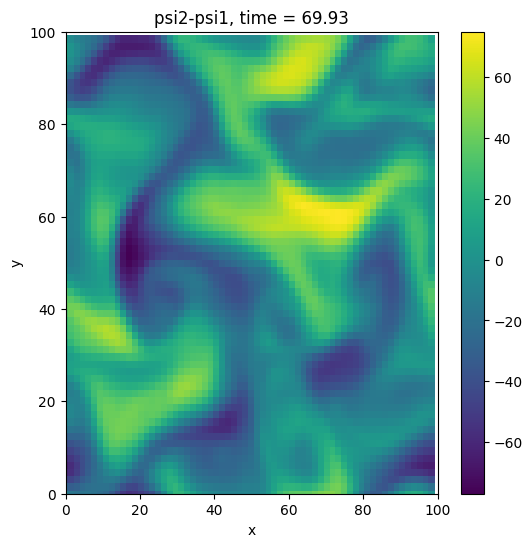

In [34]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    streamfunction = plt.pcolor(X, Y, (psi2_save[n,:,:].T-psi1_save[n,:,:].T))
    # Specify the axis limits and labels
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('psi2-psi1, time = {0:.2f}'.format(t_save[n]))
    return (streamfunction,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 1.5 Student investigation
<a id='section1pt5'></a>
In lectures, we found growing solutions of the form

$$ \psi_{1,2}=Re\left[\hat{\psi}_{1,2}e^{ikx+\sigma t}\right], $$

where

$$ \sigma = Uk \left(\frac{2/R_d^2-k^2}{2/R_d^2+k^2}\right)^{1/2}, $$

is the exponential growth rate, $R_d=\sqrt{g'H}/f_0$ is the deformation radius in each layer, and $k$ is the wavenumber in the $x$ direction where $\lambda=2\pi/k$ is the wavelength.

In the box below, compare the result of the simulation with what you would expect based on the growth rate given above. Comment on the possible reasons for any differences. Discuss the behaviour of the flow in the simulation at later times and comment on the relevance to storms in the atmosphere.

In the early stages of the simulation, the disturbance growth follows an exponential trend, consistent with the theoretical predictions of baroclinic instability. Over time, as the simulation progresses, nonlinear effects become significant, and the flow evolves to exhibit rotational wave structures. These patterns highlight the transition from linear growth to more complex, nonlinear dynamics.

Baroclinic instability is driven by the interaction of vertical shear and horizontal temperature gradients, and the growth rate of disturbances is determined by the formula:

$$
\sigma = Uk \sqrt{\frac{2/R_d^2 - k^2}{2/R_d^2 + k^2}},
$$

where $k$ is the wavenumber and $R_d = \sqrt{g'H}/f_0$ is the deformation radius. The deformation radius represents the balance between gravity waves and rotational effects, while the wavenumber $k$ dictates the spatial structure of the disturbances.


For $k \to 0$, the growth rate $\sigma$ approaches zero:
$\sigma \to 0.$
This indicates that long-wavelength disturbances grow very slowly or not at all.
These long-wavelength motions correspond to large-scale, slow-moving structures that are less influenced by shear or pressure gradients.

The growth rate is maximized at an optimal wavenumber:
$k_{\text{max}} = \sqrt{\frac{1}{R_d^2}}.$
The corresponding wavelength is:
$\lambda_{\text{max}} = \frac{2\pi}{k_{\text{max}}}.$
Disturbances of this scale are the most unstable and dominate the system's dynamics, as they interact most effectively with the background flow and temperature gradients.

When $k^2 > 2/R_d^2$, the numerator in the growth rate formula becomes negative, and $\sigma$ is no longer real.
This means short-wavelength disturbances are stabilized:
$\sigma \text{ becomes imaginary}.
$
 These short wavelengths are suppressed by viscous dissipation or diffusion, preventing their growth.

The emergence of rotational waves in the later stages of the simulation likely reflects the influence of nonlinear effects or boundary conditions. These effects redistribute energy across scales, leading to the development of coherent, larger-scale structures. Such behavior illustrates how baroclinic instability evolves from the initial linear phase into a fully nonlinear regime, ultimately driving the formation of features like cyclones and waves in geophysical systems.


## 2. Jet stream and the dimensional QG equations

The configuration in the previous section illustrates baroclinic instability, but the setup is quite idealized. In particular, we assumed that the Coriolis parameter and the initial velocity were constant. In the atmosphere there is are strong winds at the top of the troposphere in a band called the jet stream. The jet stream is several hundred kilometers wide with wind speeds that can exceed 100 miles per hour (roughly 50 m/s). A variable Coriolis parameter is important for constraining the jet dynamics. If we use $f=f_0+\beta y$, then the equations for $q_1$ and $q_2$ become:

$$ \partial_t(q_1) + U_1 \partial_x(q_1) + \partial_x(\psi_1)\left(\beta + \frac{U_1-U_2}{R_{d1}^2}\right)+\nu_4 \nabla^4 q_1 = - J(\psi_1, q_1), $$

$$ \partial_t(q_2) + U_2 \partial_x(q_2) + \partial_x(\psi_2)\left(\beta + \frac{U_2-U_1}{R_{d2}^2}\right)+\nu_4 \nabla^4 q_2 = - J(\psi_2, q_2). $$

Here, we have also switched from a viscous term to a 'hyperviscous' term, where $-\nabla^2 q_{1,2}$ has been replaced by $\nabla^4 q_{1,2}$ where $\nabla^4=(\nabla^2)^2=(\partial^2_x+\partial^2_y)^2$. Using a hyperviscosity is useful because it acts to preferentially damp small scale motions (with large horizontal wavenumbers), while having less influence on the larger scale motions (with small horizontal wavenumbers). It is useful in this case since we would like the jet not to be strongly influenced by viscosity.

We can simulate baroclinic instability on the jet stream by localizing the north/south gradient in the QG potential voriticty in the center of our computational domain. However, since our boundary conditions are periodic, we need the potential vorticity that we solve for to be equal at the northern and southern boundaries. We can accomplish this with the following trick. For our initial condition, let the total potential vorticity in layer 1 be:

$$ q_1 = Q_1 tanh\left(\frac{y-Ly/2}{w}\right) $$

where $Ly$ is the domain size, $Q_1$ is a constant dimensional amplitude and $w$ is the jet width. Clearly $q_1$ isn't periodic in the y-direction. Instead, we can impose a uniform background potential vorticity gradient (as we did in Section 1 above) and solve for the departure from this background gradient. We can then set the amplitude of the background gradient to make the <em>departure</em> from the background gradient periodic. Specifically, the departure from the background potential vorticity gradient will be:

$$ q_1 = Q_1 (tanh\left(\frac{y-Ly/2}{w}\right) - \frac{y-Ly/2}{Ly/2}) $$

which is periodic in $y$ (check for yourself if you aren't sure), and the background potential voricity gradient will be $2Q_1/Ly$ which then ensures that the total PV is the tanh function defined above.

### 2.1 Dedalus script

The script below sets up and solves the 2-layer QG equations in dimensional units (kilometers for x, y and seconds for time). The size of the box is 30,000 km in the x-direction and 10,000 km in the y-direction. This roughly corresponds to the Northern Hemisphere, although it is important to note that the analogy is only approximate since we are still solvin the equations in a Cartesian geometry and not a sphere.

Run the script below and comment on the results and the behavior of the jet stream in the text box below the script. You can also try changing some of the parameters at the top of the script to see how the result change.

Note that the script will likely take a few minutes to run.  Coordinate with the other members of your group so that you can each run a different case.

In [35]:
# Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)


INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 3s, Rate: 1.7e+01/s


2024-12-27 13:50:05,289 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 3s, Rate: 1.7e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 3s, Rate: 1.7e+01/s


2024-12-27 13:50:05,529 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 3s, Rate: 1.7e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 1s, Remaining: 2s, Rate: 1.6e+01/s


2024-12-27 13:50:05,847 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 1s, Remaining: 2s, Rate: 1.6e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 1.7e+01/s


2024-12-27 13:50:06,097 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 1.7e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 1.9e+01/s


2024-12-27 13:50:06,271 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 1.9e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 2.0e+01/s


2024-12-27 13:50:06,461 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 2.0e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.1e+01/s


2024-12-27 13:50:06,644 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.1e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 2s, Remaining: 1s, Rate: 2.2e+01/s


2024-12-27 13:50:06,834 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 2s, Remaining: 1s, Rate: 2.2e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 2s, Remaining: 0s, Rate: 2.2e+01/s


2024-12-27 13:50:07,017 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 2s, Remaining: 0s, Rate: 2.2e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.3e+01/s


2024-12-27 13:50:07,191 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.3e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.3e+01/s


2024-12-27 13:50:07,309 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.3e+01/s


INFO:__main__:Starting main loop


2024-12-27 13:50:07,323 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2024-12-27 13:50:07,468 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2024-12-27 13:50:08,057 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2024-12-27 13:50:08,618 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2024-12-27 13:50:09,192 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2024-12-27 13:50:09,743 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2024-12-27 13:50:10,313 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2024-12-27 13:50:10,874 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2024-12-27 13:50:11,450 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2024-12-27 13:50:12,022 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2024-12-27 13:50:12,607 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2024-12-27 13:50:13,171 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2024-12-27 13:50:13,730 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2024-12-27 13:50:14,303 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2024-12-27 13:50:14,856 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2024-12-27 13:50:15,430 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2024-12-27 13:50:16,002 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2024-12-27 13:50:16,923 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2024-12-27 13:50:17,831 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2024-12-27 13:50:18,776 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2024-12-27 13:50:19,551 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2024-12-27 13:50:20,096 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2024-12-27 13:50:20,664 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2024-12-27 13:50:21,223 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2024-12-27 13:50:21,807 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2024-12-27 13:50:22,370 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2024-12-27 13:50:22,946 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2024-12-27 13:50:23,507 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2024-12-27 13:50:24,062 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2024-12-27 13:50:24,656 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2024-12-27 13:50:25,221 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2024-12-27 13:50:25,778 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2024-12-27 13:50:26,349 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2024-12-27 13:50:26,920 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2024-12-27 13:50:27,493 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2024-12-27 13:50:28,082 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2024-12-27 13:50:28,648 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2024-12-27 13:50:29,226 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2024-12-27 13:50:30,137 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2024-12-27 13:50:31,036 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2024-12-27 13:50:32,011 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2024-12-27 13:50:32,816 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2024-12-27 13:50:33,385 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2024-12-27 13:50:33,965 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2024-12-27 13:50:34,519 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2024-12-27 13:50:35,105 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2024-12-27 13:50:35,673 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2024-12-27 13:50:36,261 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2024-12-27 13:50:36,825 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2024-12-27 13:50:37,411 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2024-12-27 13:50:37,978 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2024-12-27 13:50:38,567 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2024-12-27 13:50:39,132 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2024-12-27 13:50:39,700 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2024-12-27 13:50:40,269 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2024-12-27 13:50:40,819 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2024-12-27 13:50:41,413 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2024-12-27 13:50:41,975 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2024-12-27 13:50:42,541 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2024-12-27 13:50:43,422 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2024-12-27 13:50:44,297 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2024-12-27 13:50:45,238 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2024-12-27 13:50:46,058 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2024-12-27 13:50:46,637 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2024-12-27 13:50:47,193 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2024-12-27 13:50:47,779 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2024-12-27 13:50:48,363 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2024-12-27 13:50:48,948 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2024-12-27 13:50:49,530 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2024-12-27 13:50:50,089 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2024-12-27 13:50:50,660 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2024-12-27 13:50:51,221 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2024-12-27 13:50:51,811 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2024-12-27 13:50:52,378 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2024-12-27 13:50:52,956 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2024-12-27 13:50:53,536 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2024-12-27 13:50:54,100 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2024-12-27 13:50:54,673 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2024-12-27 13:50:55,239 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2024-12-27 13:50:55,822 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2024-12-27 13:50:56,743 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2024-12-27 13:50:57,662 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2024-12-27 13:50:58,637 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2024-12-27 13:50:59,480 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2024-12-27 13:51:00,082 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2024-12-27 13:51:00,658 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2024-12-27 13:51:01,247 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2024-12-27 13:51:01,833 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2024-12-27 13:51:02,418 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2024-12-27 13:51:03,023 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2024-12-27 13:51:03,596 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2024-12-27 13:51:04,184 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2024-12-27 13:51:04,762 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2024-12-27 13:51:05,351 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2024-12-27 13:51:05,926 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2024-12-27 13:51:06,502 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2024-12-27 13:51:07,084 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2024-12-27 13:51:07,646 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2024-12-27 13:51:08,217 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2024-12-27 13:51:08,771 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2024-12-27 13:51:09,384 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2024-12-27 13:51:10,336 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2024-12-27 13:51:11,244 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2024-12-27 13:51:12,198 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2024-12-27 13:51:13,016 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2024-12-27 13:51:13,616 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2024-12-27 13:51:14,191 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2024-12-27 13:51:14,774 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2024-12-27 13:51:15,337 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2024-12-27 13:51:15,912 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2024-12-27 13:51:16,489 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2024-12-27 13:51:17,054 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2024-12-27 13:51:17,637 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2024-12-27 13:51:18,217 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2024-12-27 13:51:18,807 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2024-12-27 13:51:19,374 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2024-12-27 13:51:19,967 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2024-12-27 13:51:20,553 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2024-12-27 13:51:21,125 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2024-12-27 13:51:21,702 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2024-12-27 13:51:22,293 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2024-12-27 13:51:22,967 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2024-12-27 13:51:23,902 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2024-12-27 13:51:24,801 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2024-12-27 13:51:25,780 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2024-12-27 13:51:26,559 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2024-12-27 13:51:27,149 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2024-12-27 13:51:27,715 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2024-12-27 13:51:28,326 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2024-12-27 13:51:28,888 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2024-12-27 13:51:28,892 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2024-12-27 13:51:28,897 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 2.183 sec


2024-12-27 13:51:28,901 solvers 0/1 INFO :: Setup time (init - iter 0): 2.183 sec


INFO:solvers:Warmup time (iter 0-10): 0.3887 sec


2024-12-27 13:51:28,907 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.3887 sec


INFO:solvers:Run time (iter 10-end): 81.17 sec


2024-12-27 13:51:28,909 solvers 0/1 INFO :: Run time (iter 10-end): 81.17 sec


INFO:solvers:CPU time (iter 10-end): 0.02255 cpu-hr


2024-12-27 13:51:28,912 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02255 cpu-hr


INFO:solvers:Speed: 2.221e+06 mode-stages/cpu-sec


2024-12-27 13:51:28,914 solvers 0/1 INFO :: Speed: 2.221e+06 mode-stages/cpu-sec


### 2.2 Visualization

The script below will visualize the results and create a movie showing the upper layer wind speed (the magnitude of the velocity vector (u1, v1)).

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-27 13:51:29,083 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpscw5m1wh/temp.m4v


2024-12-27 13:51:29,087 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpscw5m1wh/temp.m4v


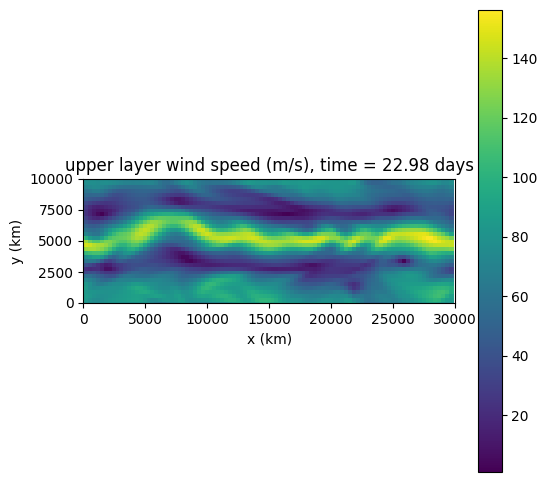

In [36]:
# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>
Describe the results in the box below. To what extent are the results qualitatively different from what you saw using the previous script? Comment on the interaction between the jet and the storms. Which features in the simulation do you think occur in the atmosphere? Do you see any features in the simulation that you think are unrealistic? If so, explain why you think those features are unrealistic.

In this plot there is a jet stream being introduced, travelling to the right. Once the system starts, the system become unstable, the turbulences being created. Both anti-clockwise and clockwise turbulence are created. Small turbulences is reactiong with each other, forming larger turbulences. Finally, the system is tends to be stable in three layers, top layer and bottom layer travel to the left while the middle layer (the jet strwam) travels to the right. This plot is very different to the previous script, as the previous one doesn't have a jet stream. As, in the simulation results, the jet stream at the late stage exhibits a regular and relatively stable pattern, which aligns with the expected behavior of a baroclinic jet stream in quasi-geostrophic dynamics. In the initial stages, there is significant turbulence, with distinct flow patterns: the upper and lower layers tend to travel to the left, while the jet stream predominantly moves to the right.

Regarding the interaction between the jet stream and the storms, the storms appear to influence the direction of the jet stream, creating an anti-clockwise pattern in some regions. This interaction suggests a cycle of energy conversion between the storms and the jet stream, where the disturbances initially deform the jet stream but eventually allow it to return to a similar configuration.

Some features of the simulation align well with atmospheric phenomena. For example, the general structure of the jet stream and the energy exchange with disturbances resemble the behavior observed in the atmosphere. However, certain aspects of the simulation are unrealistic:

1. **Initial Conditions**: The initial conditions are simplified and idealized. For instance, the potential vorticity gradient and velocity profiles are set up quickly, bypassing the gradual spin-up process typical in the real atmosphere.

2. **Coriolis Parameter**: While the Coriolis parameter is introduced as $ f = f_0 + \beta y $, which is more realistic than a constant $ f $, it still does not fully capture the variations on a spherical Earth.

3. **Small-Scale Turbulence**: The use of hyperviscosity effectively filters out small-scale turbulence. While this approach is practical for numerical stability, it oversimplifies the dynamics by excluding potentially important small-scale features and interactions.

These simplifications and approximations mean that while the simulation provides valuable qualitative insights into jet stream dynamics and their interaction with storms, caution must be exercised when interpreting the results in the context of real atmospheric processes.



In [37]:
# Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 30/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)


INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.4e+01/s


2024-12-27 13:52:01,388 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.4e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 2.7e+01/s


2024-12-27 13:52:01,531 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 2.7e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 2.8e+01/s


2024-12-27 13:52:01,698 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s


2024-12-27 13:52:01,886 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 2.7e+01/s


2024-12-27 13:52:02,091 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 2.7e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 2.7e+01/s


2024-12-27 13:52:02,261 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 2.7e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s


2024-12-27 13:52:02,428 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 2.8e+01/s


2024-12-27 13:52:02,601 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 2.8e+01/s


2024-12-27 13:52:02,770 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.8e+01/s


2024-12-27 13:52:02,958 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.8e+01/s


2024-12-27 13:52:03,081 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.8e+01/s


INFO:__main__:Starting main loop


2024-12-27 13:52:03,091 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=2.604167e+02, dt=2.604167e+02


2024-12-27 13:52:03,273 __main__ 0/1 INFO :: Iteration=1, Time=2.604167e+02, dt=2.604167e+02


INFO:__main__:Iteration=21, Time=5.468750e+03, dt=2.604167e+02


2024-12-27 13:52:04,208 __main__ 0/1 INFO :: Iteration=21, Time=5.468750e+03, dt=2.604167e+02


INFO:__main__:Iteration=41, Time=1.067708e+04, dt=2.604167e+02


2024-12-27 13:52:05,128 __main__ 0/1 INFO :: Iteration=41, Time=1.067708e+04, dt=2.604167e+02


INFO:__main__:Iteration=61, Time=1.588542e+04, dt=2.604167e+02


2024-12-27 13:52:06,077 __main__ 0/1 INFO :: Iteration=61, Time=1.588542e+04, dt=2.604167e+02


INFO:__main__:Iteration=81, Time=2.109375e+04, dt=2.604167e+02


2024-12-27 13:52:06,860 __main__ 0/1 INFO :: Iteration=81, Time=2.109375e+04, dt=2.604167e+02


INFO:__main__:Iteration=101, Time=2.630208e+04, dt=2.604167e+02


2024-12-27 13:52:07,466 __main__ 0/1 INFO :: Iteration=101, Time=2.630208e+04, dt=2.604167e+02


INFO:__main__:Iteration=121, Time=3.151042e+04, dt=2.604167e+02


2024-12-27 13:52:08,034 __main__ 0/1 INFO :: Iteration=121, Time=3.151042e+04, dt=2.604167e+02


INFO:__main__:Iteration=141, Time=3.671875e+04, dt=2.604167e+02


2024-12-27 13:52:08,742 __main__ 0/1 INFO :: Iteration=141, Time=3.671875e+04, dt=2.604167e+02


INFO:__main__:Iteration=161, Time=4.192708e+04, dt=2.604167e+02


2024-12-27 13:52:09,341 __main__ 0/1 INFO :: Iteration=161, Time=4.192708e+04, dt=2.604167e+02


INFO:__main__:Iteration=181, Time=4.713542e+04, dt=2.604167e+02


2024-12-27 13:52:09,934 __main__ 0/1 INFO :: Iteration=181, Time=4.713542e+04, dt=2.604167e+02


INFO:__main__:Iteration=201, Time=5.234375e+04, dt=2.604167e+02


2024-12-27 13:52:10,536 __main__ 0/1 INFO :: Iteration=201, Time=5.234375e+04, dt=2.604167e+02


INFO:__main__:Iteration=221, Time=5.755208e+04, dt=2.604167e+02


2024-12-27 13:52:11,131 __main__ 0/1 INFO :: Iteration=221, Time=5.755208e+04, dt=2.604167e+02


INFO:__main__:Iteration=241, Time=6.276042e+04, dt=2.604167e+02


2024-12-27 13:52:11,740 __main__ 0/1 INFO :: Iteration=241, Time=6.276042e+04, dt=2.604167e+02


INFO:__main__:Iteration=261, Time=6.796875e+04, dt=2.604167e+02


2024-12-27 13:52:12,325 __main__ 0/1 INFO :: Iteration=261, Time=6.796875e+04, dt=2.604167e+02


INFO:__main__:Iteration=281, Time=7.317708e+04, dt=2.604167e+02


2024-12-27 13:52:12,922 __main__ 0/1 INFO :: Iteration=281, Time=7.317708e+04, dt=2.604167e+02


INFO:__main__:Iteration=301, Time=7.838542e+04, dt=2.604167e+02


2024-12-27 13:52:13,517 __main__ 0/1 INFO :: Iteration=301, Time=7.838542e+04, dt=2.604167e+02


INFO:__main__:Iteration=321, Time=8.359375e+04, dt=2.604167e+02


2024-12-27 13:52:14,090 __main__ 0/1 INFO :: Iteration=321, Time=8.359375e+04, dt=2.604167e+02


INFO:__main__:Iteration=341, Time=8.880208e+04, dt=2.604167e+02


2024-12-27 13:52:14,684 __main__ 0/1 INFO :: Iteration=341, Time=8.880208e+04, dt=2.604167e+02


INFO:__main__:Iteration=361, Time=9.401042e+04, dt=2.604167e+02


2024-12-27 13:52:15,262 __main__ 0/1 INFO :: Iteration=361, Time=9.401042e+04, dt=2.604167e+02


INFO:__main__:Iteration=381, Time=9.921875e+04, dt=2.604167e+02


2024-12-27 13:52:15,835 __main__ 0/1 INFO :: Iteration=381, Time=9.921875e+04, dt=2.604167e+02


INFO:__main__:Iteration=401, Time=1.044271e+05, dt=2.604167e+02


2024-12-27 13:52:16,404 __main__ 0/1 INFO :: Iteration=401, Time=1.044271e+05, dt=2.604167e+02


INFO:__main__:Iteration=421, Time=1.096354e+05, dt=2.604167e+02


2024-12-27 13:52:17,260 __main__ 0/1 INFO :: Iteration=421, Time=1.096354e+05, dt=2.604167e+02


INFO:__main__:Iteration=441, Time=1.148438e+05, dt=2.604167e+02


2024-12-27 13:52:18,137 __main__ 0/1 INFO :: Iteration=441, Time=1.148438e+05, dt=2.604167e+02


INFO:__main__:Iteration=461, Time=1.200521e+05, dt=2.604167e+02


2024-12-27 13:52:19,112 __main__ 0/1 INFO :: Iteration=461, Time=1.200521e+05, dt=2.604167e+02


INFO:__main__:Iteration=481, Time=1.252604e+05, dt=2.604167e+02


2024-12-27 13:52:19,998 __main__ 0/1 INFO :: Iteration=481, Time=1.252604e+05, dt=2.604167e+02


INFO:__main__:Iteration=501, Time=1.304688e+05, dt=2.604167e+02


2024-12-27 13:52:20,576 __main__ 0/1 INFO :: Iteration=501, Time=1.304688e+05, dt=2.604167e+02


INFO:__main__:Iteration=521, Time=1.356771e+05, dt=2.604167e+02


2024-12-27 13:52:21,145 __main__ 0/1 INFO :: Iteration=521, Time=1.356771e+05, dt=2.604167e+02


INFO:__main__:Iteration=541, Time=1.408854e+05, dt=2.604167e+02


2024-12-27 13:52:21,697 __main__ 0/1 INFO :: Iteration=541, Time=1.408854e+05, dt=2.604167e+02


INFO:__main__:Iteration=561, Time=1.460938e+05, dt=2.604167e+02


2024-12-27 13:52:22,280 __main__ 0/1 INFO :: Iteration=561, Time=1.460938e+05, dt=2.604167e+02


INFO:__main__:Iteration=581, Time=1.513021e+05, dt=2.604167e+02


2024-12-27 13:52:22,883 __main__ 0/1 INFO :: Iteration=581, Time=1.513021e+05, dt=2.604167e+02


INFO:__main__:Iteration=601, Time=1.565104e+05, dt=2.604167e+02


2024-12-27 13:52:23,461 __main__ 0/1 INFO :: Iteration=601, Time=1.565104e+05, dt=2.604167e+02


INFO:__main__:Iteration=621, Time=1.617187e+05, dt=2.604167e+02


2024-12-27 13:52:24,063 __main__ 0/1 INFO :: Iteration=621, Time=1.617187e+05, dt=2.604167e+02


INFO:__main__:Iteration=641, Time=1.669271e+05, dt=2.604167e+02


2024-12-27 13:52:24,650 __main__ 0/1 INFO :: Iteration=641, Time=1.669271e+05, dt=2.604167e+02


INFO:__main__:Iteration=661, Time=1.721354e+05, dt=2.604167e+02


2024-12-27 13:52:25,250 __main__ 0/1 INFO :: Iteration=661, Time=1.721354e+05, dt=2.604167e+02


INFO:__main__:Iteration=681, Time=1.773437e+05, dt=2.604167e+02


2024-12-27 13:52:25,859 __main__ 0/1 INFO :: Iteration=681, Time=1.773437e+05, dt=2.604167e+02


INFO:__main__:Iteration=701, Time=1.825521e+05, dt=2.604167e+02


2024-12-27 13:52:26,446 __main__ 0/1 INFO :: Iteration=701, Time=1.825521e+05, dt=2.604167e+02


INFO:__main__:Iteration=721, Time=1.877604e+05, dt=2.604167e+02


2024-12-27 13:52:27,043 __main__ 0/1 INFO :: Iteration=721, Time=1.877604e+05, dt=2.604167e+02


INFO:__main__:Iteration=741, Time=1.929687e+05, dt=2.604167e+02


2024-12-27 13:52:27,624 __main__ 0/1 INFO :: Iteration=741, Time=1.929687e+05, dt=2.604167e+02


INFO:__main__:Iteration=761, Time=1.981771e+05, dt=2.604167e+02


2024-12-27 13:52:28,230 __main__ 0/1 INFO :: Iteration=761, Time=1.981771e+05, dt=2.604167e+02


INFO:__main__:Iteration=781, Time=2.033854e+05, dt=2.604167e+02


2024-12-27 13:52:28,810 __main__ 0/1 INFO :: Iteration=781, Time=2.033854e+05, dt=2.604167e+02


INFO:__main__:Iteration=801, Time=2.085937e+05, dt=2.604167e+02


2024-12-27 13:52:29,404 __main__ 0/1 INFO :: Iteration=801, Time=2.085937e+05, dt=2.604167e+02


INFO:__main__:Iteration=821, Time=2.138021e+05, dt=2.604167e+02


2024-12-27 13:52:30,082 __main__ 0/1 INFO :: Iteration=821, Time=2.138021e+05, dt=2.604167e+02


INFO:__main__:Iteration=841, Time=2.190104e+05, dt=2.604167e+02


2024-12-27 13:52:30,995 __main__ 0/1 INFO :: Iteration=841, Time=2.190104e+05, dt=2.604167e+02


INFO:__main__:Iteration=861, Time=2.242187e+05, dt=2.604167e+02


2024-12-27 13:52:31,927 __main__ 0/1 INFO :: Iteration=861, Time=2.242187e+05, dt=2.604167e+02


INFO:__main__:Iteration=881, Time=2.294271e+05, dt=2.604167e+02


2024-12-27 13:52:32,909 __main__ 0/1 INFO :: Iteration=881, Time=2.294271e+05, dt=2.604167e+02


INFO:__main__:Iteration=901, Time=2.346354e+05, dt=2.604167e+02


2024-12-27 13:52:33,640 __main__ 0/1 INFO :: Iteration=901, Time=2.346354e+05, dt=2.604167e+02


INFO:__main__:Iteration=921, Time=2.398437e+05, dt=2.604167e+02


2024-12-27 13:52:34,232 __main__ 0/1 INFO :: Iteration=921, Time=2.398437e+05, dt=2.604167e+02


INFO:__main__:Iteration=941, Time=2.450521e+05, dt=2.604167e+02


2024-12-27 13:52:34,803 __main__ 0/1 INFO :: Iteration=941, Time=2.450521e+05, dt=2.604167e+02


INFO:__main__:Iteration=961, Time=2.502604e+05, dt=2.604167e+02


2024-12-27 13:52:35,404 __main__ 0/1 INFO :: Iteration=961, Time=2.502604e+05, dt=2.604167e+02


INFO:__main__:Iteration=981, Time=2.554687e+05, dt=2.604167e+02


2024-12-27 13:52:35,973 __main__ 0/1 INFO :: Iteration=981, Time=2.554687e+05, dt=2.604167e+02


INFO:__main__:Iteration=1001, Time=2.606771e+05, dt=2.604167e+02


2024-12-27 13:52:36,557 __main__ 0/1 INFO :: Iteration=1001, Time=2.606771e+05, dt=2.604167e+02


INFO:__main__:Iteration=1021, Time=2.658854e+05, dt=2.604167e+02


2024-12-27 13:52:37,143 __main__ 0/1 INFO :: Iteration=1021, Time=2.658854e+05, dt=2.604167e+02


INFO:__main__:Iteration=1041, Time=2.710937e+05, dt=2.604167e+02


2024-12-27 13:52:37,728 __main__ 0/1 INFO :: Iteration=1041, Time=2.710937e+05, dt=2.604167e+02


INFO:__main__:Iteration=1061, Time=2.763021e+05, dt=2.604167e+02


2024-12-27 13:52:38,312 __main__ 0/1 INFO :: Iteration=1061, Time=2.763021e+05, dt=2.604167e+02


INFO:__main__:Iteration=1081, Time=2.815104e+05, dt=2.604167e+02


2024-12-27 13:52:38,878 __main__ 0/1 INFO :: Iteration=1081, Time=2.815104e+05, dt=2.604167e+02


INFO:__main__:Iteration=1101, Time=2.867187e+05, dt=2.604167e+02


2024-12-27 13:52:39,478 __main__ 0/1 INFO :: Iteration=1101, Time=2.867187e+05, dt=2.604167e+02


INFO:__main__:Iteration=1121, Time=2.919271e+05, dt=2.604167e+02


2024-12-27 13:52:40,076 __main__ 0/1 INFO :: Iteration=1121, Time=2.919271e+05, dt=2.604167e+02


INFO:__main__:Iteration=1141, Time=2.971354e+05, dt=2.604167e+02


2024-12-27 13:52:40,684 __main__ 0/1 INFO :: Iteration=1141, Time=2.971354e+05, dt=2.604167e+02


INFO:__main__:Iteration=1161, Time=3.023437e+05, dt=2.604167e+02


2024-12-27 13:52:41,270 __main__ 0/1 INFO :: Iteration=1161, Time=3.023437e+05, dt=2.604167e+02


INFO:__main__:Iteration=1181, Time=3.075521e+05, dt=2.604167e+02


2024-12-27 13:52:41,880 __main__ 0/1 INFO :: Iteration=1181, Time=3.075521e+05, dt=2.604167e+02


INFO:__main__:Iteration=1201, Time=3.127604e+05, dt=2.604167e+02


2024-12-27 13:52:42,481 __main__ 0/1 INFO :: Iteration=1201, Time=3.127604e+05, dt=2.604167e+02


INFO:__main__:Iteration=1221, Time=3.179688e+05, dt=2.604167e+02


2024-12-27 13:52:43,055 __main__ 0/1 INFO :: Iteration=1221, Time=3.179688e+05, dt=2.604167e+02


INFO:__main__:Iteration=1241, Time=3.231771e+05, dt=2.604167e+02


2024-12-27 13:52:43,883 __main__ 0/1 INFO :: Iteration=1241, Time=3.231771e+05, dt=2.604167e+02


INFO:__main__:Iteration=1261, Time=3.283854e+05, dt=2.604167e+02


2024-12-27 13:52:44,791 __main__ 0/1 INFO :: Iteration=1261, Time=3.283854e+05, dt=2.604167e+02


INFO:__main__:Iteration=1281, Time=3.335938e+05, dt=2.604167e+02


2024-12-27 13:52:45,750 __main__ 0/1 INFO :: Iteration=1281, Time=3.335938e+05, dt=2.604167e+02


INFO:__main__:Iteration=1301, Time=3.388021e+05, dt=2.604167e+02


2024-12-27 13:52:46,718 __main__ 0/1 INFO :: Iteration=1301, Time=3.388021e+05, dt=2.604167e+02


INFO:__main__:Iteration=1321, Time=3.440104e+05, dt=2.604167e+02


2024-12-27 13:52:47,310 __main__ 0/1 INFO :: Iteration=1321, Time=3.440104e+05, dt=2.604167e+02


INFO:__main__:Iteration=1341, Time=3.492188e+05, dt=2.604167e+02


2024-12-27 13:52:47,892 __main__ 0/1 INFO :: Iteration=1341, Time=3.492188e+05, dt=2.604167e+02


INFO:__main__:Iteration=1361, Time=3.544271e+05, dt=2.604167e+02


2024-12-27 13:52:48,466 __main__ 0/1 INFO :: Iteration=1361, Time=3.544271e+05, dt=2.604167e+02


INFO:__main__:Iteration=1381, Time=3.596354e+05, dt=2.604167e+02


2024-12-27 13:52:49,049 __main__ 0/1 INFO :: Iteration=1381, Time=3.596354e+05, dt=2.604167e+02


INFO:__main__:Iteration=1401, Time=3.648438e+05, dt=2.604167e+02


2024-12-27 13:52:49,635 __main__ 0/1 INFO :: Iteration=1401, Time=3.648438e+05, dt=2.604167e+02


INFO:__main__:Iteration=1421, Time=3.700521e+05, dt=2.604167e+02


2024-12-27 13:52:50,229 __main__ 0/1 INFO :: Iteration=1421, Time=3.700521e+05, dt=2.604167e+02


INFO:__main__:Iteration=1441, Time=3.752604e+05, dt=2.604167e+02


2024-12-27 13:52:50,812 __main__ 0/1 INFO :: Iteration=1441, Time=3.752604e+05, dt=2.604167e+02


INFO:__main__:Iteration=1461, Time=3.804688e+05, dt=2.604167e+02


2024-12-27 13:52:51,383 __main__ 0/1 INFO :: Iteration=1461, Time=3.804688e+05, dt=2.604167e+02


INFO:__main__:Iteration=1481, Time=3.856771e+05, dt=2.604167e+02


2024-12-27 13:52:51,977 __main__ 0/1 INFO :: Iteration=1481, Time=3.856771e+05, dt=2.604167e+02


INFO:__main__:Iteration=1501, Time=3.908854e+05, dt=2.604167e+02


2024-12-27 13:52:52,559 __main__ 0/1 INFO :: Iteration=1501, Time=3.908854e+05, dt=2.604167e+02


INFO:__main__:Iteration=1521, Time=3.960938e+05, dt=2.604167e+02


2024-12-27 13:52:53,141 __main__ 0/1 INFO :: Iteration=1521, Time=3.960938e+05, dt=2.604167e+02


INFO:__main__:Iteration=1541, Time=4.013021e+05, dt=2.604167e+02


2024-12-27 13:52:53,713 __main__ 0/1 INFO :: Iteration=1541, Time=4.013021e+05, dt=2.604167e+02


INFO:__main__:Iteration=1561, Time=4.065104e+05, dt=2.604167e+02


2024-12-27 13:52:54,302 __main__ 0/1 INFO :: Iteration=1561, Time=4.065104e+05, dt=2.604167e+02


INFO:__main__:Iteration=1581, Time=4.117188e+05, dt=2.604167e+02


2024-12-27 13:52:54,869 __main__ 0/1 INFO :: Iteration=1581, Time=4.117188e+05, dt=2.604167e+02


/usr/local/lib/python3.10/dist-packages/dedalus/core/arithmetic.py:866: RuntimeWarning: overflow encountered in multiply
  np.multiply(arg0_exp_data, arg1_exp_data, out=out.data)
INFO:__main__:Iteration=1601, Time=4.169271e+05, dt=2.604167e+02


2024-12-27 13:52:55,466 __main__ 0/1 INFO :: Iteration=1601, Time=4.169271e+05, dt=2.604167e+02


INFO:__main__:Iteration=1621, Time=4.221354e+05, dt=2.604167e+02


2024-12-27 13:52:56,053 __main__ 0/1 INFO :: Iteration=1621, Time=4.221354e+05, dt=2.604167e+02


INFO:__main__:Iteration=1641, Time=4.273438e+05, dt=2.604167e+02


2024-12-27 13:52:56,618 __main__ 0/1 INFO :: Iteration=1641, Time=4.273438e+05, dt=2.604167e+02


INFO:__main__:Iteration=1661, Time=4.325521e+05, dt=2.604167e+02


2024-12-27 13:52:57,466 __main__ 0/1 INFO :: Iteration=1661, Time=4.325521e+05, dt=2.604167e+02


INFO:__main__:Iteration=1681, Time=4.377604e+05, dt=2.604167e+02


2024-12-27 13:52:58,380 __main__ 0/1 INFO :: Iteration=1681, Time=4.377604e+05, dt=2.604167e+02


INFO:__main__:Iteration=1701, Time=4.429688e+05, dt=2.604167e+02


2024-12-27 13:52:59,328 __main__ 0/1 INFO :: Iteration=1701, Time=4.429688e+05, dt=2.604167e+02


INFO:__main__:Iteration=1721, Time=4.481771e+05, dt=2.604167e+02


2024-12-27 13:53:00,224 __main__ 0/1 INFO :: Iteration=1721, Time=4.481771e+05, dt=2.604167e+02


INFO:__main__:Iteration=1741, Time=4.533854e+05, dt=2.604167e+02


2024-12-27 13:53:00,797 __main__ 0/1 INFO :: Iteration=1741, Time=4.533854e+05, dt=2.604167e+02


INFO:__main__:Iteration=1761, Time=4.585938e+05, dt=2.604167e+02


2024-12-27 13:53:01,404 __main__ 0/1 INFO :: Iteration=1761, Time=4.585938e+05, dt=2.604167e+02


INFO:__main__:Iteration=1781, Time=4.638021e+05, dt=2.604167e+02


2024-12-27 13:53:01,978 __main__ 0/1 INFO :: Iteration=1781, Time=4.638021e+05, dt=2.604167e+02


INFO:__main__:Iteration=1801, Time=4.690104e+05, dt=2.604167e+02


2024-12-27 13:53:02,579 __main__ 0/1 INFO :: Iteration=1801, Time=4.690104e+05, dt=2.604167e+02


INFO:__main__:Iteration=1821, Time=4.742188e+05, dt=2.604167e+02


2024-12-27 13:53:03,156 __main__ 0/1 INFO :: Iteration=1821, Time=4.742188e+05, dt=2.604167e+02


INFO:__main__:Iteration=1841, Time=4.794271e+05, dt=2.604167e+02


2024-12-27 13:53:03,756 __main__ 0/1 INFO :: Iteration=1841, Time=4.794271e+05, dt=2.604167e+02


INFO:__main__:Iteration=1861, Time=4.846354e+05, dt=2.604167e+02


2024-12-27 13:53:04,351 __main__ 0/1 INFO :: Iteration=1861, Time=4.846354e+05, dt=2.604167e+02


INFO:__main__:Iteration=1881, Time=4.898438e+05, dt=2.604167e+02


2024-12-27 13:53:04,912 __main__ 0/1 INFO :: Iteration=1881, Time=4.898438e+05, dt=2.604167e+02


INFO:__main__:Iteration=1901, Time=4.950521e+05, dt=2.604167e+02


2024-12-27 13:53:05,516 __main__ 0/1 INFO :: Iteration=1901, Time=4.950521e+05, dt=2.604167e+02


INFO:__main__:Iteration=1921, Time=5.002604e+05, dt=2.604167e+02


2024-12-27 13:53:06,082 __main__ 0/1 INFO :: Iteration=1921, Time=5.002604e+05, dt=2.604167e+02


INFO:__main__:Iteration=1941, Time=5.054688e+05, dt=2.604167e+02


2024-12-27 13:53:06,687 __main__ 0/1 INFO :: Iteration=1941, Time=5.054688e+05, dt=2.604167e+02


INFO:__main__:Iteration=1961, Time=5.106771e+05, dt=2.604167e+02


2024-12-27 13:53:07,268 __main__ 0/1 INFO :: Iteration=1961, Time=5.106771e+05, dt=2.604167e+02


INFO:__main__:Iteration=1981, Time=5.158854e+05, dt=2.604167e+02


2024-12-27 13:53:07,844 __main__ 0/1 INFO :: Iteration=1981, Time=5.158854e+05, dt=2.604167e+02


INFO:__main__:Iteration=2001, Time=5.210938e+05, dt=2.604167e+02


2024-12-27 13:53:08,429 __main__ 0/1 INFO :: Iteration=2001, Time=5.210938e+05, dt=2.604167e+02


INFO:__main__:Iteration=2021, Time=5.263021e+05, dt=2.604167e+02


2024-12-27 13:53:08,988 __main__ 0/1 INFO :: Iteration=2021, Time=5.263021e+05, dt=2.604167e+02


INFO:__main__:Iteration=2041, Time=5.315104e+05, dt=2.604167e+02


2024-12-27 13:53:09,565 __main__ 0/1 INFO :: Iteration=2041, Time=5.315104e+05, dt=2.604167e+02


INFO:__main__:Iteration=2061, Time=5.367188e+05, dt=2.604167e+02


2024-12-27 13:53:10,201 __main__ 0/1 INFO :: Iteration=2061, Time=5.367188e+05, dt=2.604167e+02


INFO:__main__:Iteration=2081, Time=5.419271e+05, dt=2.604167e+02


2024-12-27 13:53:11,144 __main__ 0/1 INFO :: Iteration=2081, Time=5.419271e+05, dt=2.604167e+02


INFO:__main__:Iteration=2101, Time=5.471354e+05, dt=2.604167e+02


2024-12-27 13:53:12,061 __main__ 0/1 INFO :: Iteration=2101, Time=5.471354e+05, dt=2.604167e+02


INFO:__main__:Iteration=2121, Time=5.523438e+05, dt=2.604167e+02


2024-12-27 13:53:13,031 __main__ 0/1 INFO :: Iteration=2121, Time=5.523438e+05, dt=2.604167e+02


INFO:__main__:Iteration=2141, Time=5.575521e+05, dt=2.604167e+02


2024-12-27 13:53:13,713 __main__ 0/1 INFO :: Iteration=2141, Time=5.575521e+05, dt=2.604167e+02


INFO:__main__:Iteration=2161, Time=5.627604e+05, dt=2.604167e+02


2024-12-27 13:53:14,284 __main__ 0/1 INFO :: Iteration=2161, Time=5.627604e+05, dt=2.604167e+02


INFO:__main__:Iteration=2181, Time=5.679688e+05, dt=2.604167e+02


2024-12-27 13:53:14,865 __main__ 0/1 INFO :: Iteration=2181, Time=5.679688e+05, dt=2.604167e+02


INFO:__main__:Iteration=2201, Time=5.731771e+05, dt=2.604167e+02


2024-12-27 13:53:15,436 __main__ 0/1 INFO :: Iteration=2201, Time=5.731771e+05, dt=2.604167e+02


INFO:__main__:Iteration=2221, Time=5.783854e+05, dt=2.604167e+02


2024-12-27 13:53:16,006 __main__ 0/1 INFO :: Iteration=2221, Time=5.783854e+05, dt=2.604167e+02


INFO:__main__:Iteration=2241, Time=5.835938e+05, dt=2.604167e+02


2024-12-27 13:53:16,588 __main__ 0/1 INFO :: Iteration=2241, Time=5.835938e+05, dt=2.604167e+02


INFO:__main__:Iteration=2261, Time=5.888021e+05, dt=2.604167e+02


2024-12-27 13:53:17,179 __main__ 0/1 INFO :: Iteration=2261, Time=5.888021e+05, dt=2.604167e+02


INFO:__main__:Iteration=2281, Time=5.940104e+05, dt=2.604167e+02


2024-12-27 13:53:17,758 __main__ 0/1 INFO :: Iteration=2281, Time=5.940104e+05, dt=2.604167e+02


INFO:__main__:Iteration=2301, Time=5.992188e+05, dt=2.604167e+02


2024-12-27 13:53:18,338 __main__ 0/1 INFO :: Iteration=2301, Time=5.992188e+05, dt=2.604167e+02


INFO:__main__:Iteration=2321, Time=6.044271e+05, dt=2.604167e+02


2024-12-27 13:53:18,925 __main__ 0/1 INFO :: Iteration=2321, Time=6.044271e+05, dt=2.604167e+02


INFO:__main__:Iteration=2341, Time=6.096354e+05, dt=2.604167e+02


2024-12-27 13:53:19,509 __main__ 0/1 INFO :: Iteration=2341, Time=6.096354e+05, dt=2.604167e+02


INFO:__main__:Iteration=2361, Time=6.148438e+05, dt=2.604167e+02


2024-12-27 13:53:20,088 __main__ 0/1 INFO :: Iteration=2361, Time=6.148438e+05, dt=2.604167e+02


INFO:__main__:Iteration=2381, Time=6.200521e+05, dt=2.604167e+02


2024-12-27 13:53:20,658 __main__ 0/1 INFO :: Iteration=2381, Time=6.200521e+05, dt=2.604167e+02


INFO:__main__:Iteration=2401, Time=6.252604e+05, dt=2.604167e+02


2024-12-27 13:53:21,235 __main__ 0/1 INFO :: Iteration=2401, Time=6.252604e+05, dt=2.604167e+02


INFO:__main__:Iteration=2421, Time=6.304687e+05, dt=2.604167e+02


2024-12-27 13:53:21,814 __main__ 0/1 INFO :: Iteration=2421, Time=6.304687e+05, dt=2.604167e+02


INFO:__main__:Iteration=2441, Time=6.356771e+05, dt=2.604167e+02


2024-12-27 13:53:22,401 __main__ 0/1 INFO :: Iteration=2441, Time=6.356771e+05, dt=2.604167e+02


INFO:__main__:Iteration=2461, Time=6.408854e+05, dt=2.604167e+02


2024-12-27 13:53:22,974 __main__ 0/1 INFO :: Iteration=2461, Time=6.408854e+05, dt=2.604167e+02


INFO:__main__:Iteration=2481, Time=6.460937e+05, dt=2.604167e+02


2024-12-27 13:53:23,745 __main__ 0/1 INFO :: Iteration=2481, Time=6.460937e+05, dt=2.604167e+02


INFO:__main__:Iteration=2501, Time=6.513021e+05, dt=2.604167e+02


2024-12-27 13:53:24,648 __main__ 0/1 INFO :: Iteration=2501, Time=6.513021e+05, dt=2.604167e+02


INFO:__main__:Iteration=2521, Time=6.565104e+05, dt=2.604167e+02


2024-12-27 13:53:25,589 __main__ 0/1 INFO :: Iteration=2521, Time=6.565104e+05, dt=2.604167e+02


INFO:__main__:Iteration=2541, Time=6.617187e+05, dt=2.604167e+02


2024-12-27 13:53:26,554 __main__ 0/1 INFO :: Iteration=2541, Time=6.617187e+05, dt=2.604167e+02


INFO:__main__:Iteration=2561, Time=6.669271e+05, dt=2.604167e+02


2024-12-27 13:53:27,145 __main__ 0/1 INFO :: Iteration=2561, Time=6.669271e+05, dt=2.604167e+02


INFO:__main__:Iteration=2581, Time=6.721354e+05, dt=2.604167e+02


2024-12-27 13:53:27,710 __main__ 0/1 INFO :: Iteration=2581, Time=6.721354e+05, dt=2.604167e+02


INFO:__main__:Iteration=2601, Time=6.773437e+05, dt=2.604167e+02


2024-12-27 13:53:28,296 __main__ 0/1 INFO :: Iteration=2601, Time=6.773437e+05, dt=2.604167e+02


INFO:__main__:Iteration=2621, Time=6.825521e+05, dt=2.604167e+02


2024-12-27 13:53:28,866 __main__ 0/1 INFO :: Iteration=2621, Time=6.825521e+05, dt=2.604167e+02


INFO:__main__:Iteration=2641, Time=6.877604e+05, dt=2.604167e+02


2024-12-27 13:53:29,460 __main__ 0/1 INFO :: Iteration=2641, Time=6.877604e+05, dt=2.604167e+02


INFO:__main__:Iteration=2661, Time=6.929687e+05, dt=2.604167e+02


2024-12-27 13:53:30,050 __main__ 0/1 INFO :: Iteration=2661, Time=6.929687e+05, dt=2.604167e+02


INFO:__main__:Iteration=2681, Time=6.981771e+05, dt=2.604167e+02


2024-12-27 13:53:30,685 __main__ 0/1 INFO :: Iteration=2681, Time=6.981771e+05, dt=2.604167e+02


INFO:__main__:Iteration=2701, Time=7.033854e+05, dt=2.604167e+02


2024-12-27 13:53:31,266 __main__ 0/1 INFO :: Iteration=2701, Time=7.033854e+05, dt=2.604167e+02


INFO:__main__:Iteration=2721, Time=7.085937e+05, dt=2.604167e+02


2024-12-27 13:53:31,858 __main__ 0/1 INFO :: Iteration=2721, Time=7.085937e+05, dt=2.604167e+02


INFO:__main__:Iteration=2741, Time=7.138021e+05, dt=2.604167e+02


2024-12-27 13:53:32,447 __main__ 0/1 INFO :: Iteration=2741, Time=7.138021e+05, dt=2.604167e+02


INFO:__main__:Iteration=2761, Time=7.190104e+05, dt=2.604167e+02


2024-12-27 13:53:33,024 __main__ 0/1 INFO :: Iteration=2761, Time=7.190104e+05, dt=2.604167e+02


INFO:__main__:Iteration=2781, Time=7.242187e+05, dt=2.604167e+02


2024-12-27 13:53:33,618 __main__ 0/1 INFO :: Iteration=2781, Time=7.242187e+05, dt=2.604167e+02


INFO:__main__:Iteration=2801, Time=7.294271e+05, dt=2.604167e+02


2024-12-27 13:53:34,197 __main__ 0/1 INFO :: Iteration=2801, Time=7.294271e+05, dt=2.604167e+02


INFO:__main__:Iteration=2821, Time=7.346354e+05, dt=2.604167e+02


2024-12-27 13:53:34,770 __main__ 0/1 INFO :: Iteration=2821, Time=7.346354e+05, dt=2.604167e+02


INFO:__main__:Iteration=2841, Time=7.398437e+05, dt=2.604167e+02


2024-12-27 13:53:35,352 __main__ 0/1 INFO :: Iteration=2841, Time=7.398437e+05, dt=2.604167e+02


INFO:__main__:Iteration=2861, Time=7.450521e+05, dt=2.604167e+02


2024-12-27 13:53:35,917 __main__ 0/1 INFO :: Iteration=2861, Time=7.450521e+05, dt=2.604167e+02


INFO:__main__:Iteration=2881, Time=7.502604e+05, dt=2.604167e+02


2024-12-27 13:53:36,508 __main__ 0/1 INFO :: Iteration=2881, Time=7.502604e+05, dt=2.604167e+02


INFO:__main__:Iteration=2901, Time=7.554687e+05, dt=2.604167e+02


2024-12-27 13:53:37,408 __main__ 0/1 INFO :: Iteration=2901, Time=7.554687e+05, dt=2.604167e+02


INFO:__main__:Iteration=2921, Time=7.606771e+05, dt=2.604167e+02


2024-12-27 13:53:38,292 __main__ 0/1 INFO :: Iteration=2921, Time=7.606771e+05, dt=2.604167e+02


INFO:__main__:Iteration=2941, Time=7.658854e+05, dt=2.604167e+02


2024-12-27 13:53:39,241 __main__ 0/1 INFO :: Iteration=2941, Time=7.658854e+05, dt=2.604167e+02


INFO:__main__:Iteration=2961, Time=7.710937e+05, dt=2.604167e+02


2024-12-27 13:53:40,066 __main__ 0/1 INFO :: Iteration=2961, Time=7.710937e+05, dt=2.604167e+02


INFO:__main__:Iteration=2981, Time=7.763021e+05, dt=2.604167e+02


2024-12-27 13:53:40,659 __main__ 0/1 INFO :: Iteration=2981, Time=7.763021e+05, dt=2.604167e+02


INFO:__main__:Iteration=3001, Time=7.815104e+05, dt=2.604167e+02


2024-12-27 13:53:41,231 __main__ 0/1 INFO :: Iteration=3001, Time=7.815104e+05, dt=2.604167e+02


INFO:__main__:Iteration=3021, Time=7.867187e+05, dt=2.604167e+02


2024-12-27 13:53:41,841 __main__ 0/1 INFO :: Iteration=3021, Time=7.867187e+05, dt=2.604167e+02


INFO:__main__:Iteration=3041, Time=7.919271e+05, dt=2.604167e+02


2024-12-27 13:53:42,400 __main__ 0/1 INFO :: Iteration=3041, Time=7.919271e+05, dt=2.604167e+02


INFO:__main__:Iteration=3061, Time=7.971354e+05, dt=2.604167e+02


2024-12-27 13:53:42,991 __main__ 0/1 INFO :: Iteration=3061, Time=7.971354e+05, dt=2.604167e+02


INFO:__main__:Iteration=3081, Time=8.023437e+05, dt=2.604167e+02


2024-12-27 13:53:43,587 __main__ 0/1 INFO :: Iteration=3081, Time=8.023437e+05, dt=2.604167e+02


INFO:__main__:Iteration=3101, Time=8.075521e+05, dt=2.604167e+02


2024-12-27 13:53:44,180 __main__ 0/1 INFO :: Iteration=3101, Time=8.075521e+05, dt=2.604167e+02


INFO:__main__:Iteration=3121, Time=8.127604e+05, dt=2.604167e+02


2024-12-27 13:53:44,803 __main__ 0/1 INFO :: Iteration=3121, Time=8.127604e+05, dt=2.604167e+02


INFO:__main__:Iteration=3141, Time=8.179687e+05, dt=2.604167e+02


2024-12-27 13:53:45,367 __main__ 0/1 INFO :: Iteration=3141, Time=8.179687e+05, dt=2.604167e+02


INFO:__main__:Iteration=3161, Time=8.231771e+05, dt=2.604167e+02


2024-12-27 13:53:45,965 __main__ 0/1 INFO :: Iteration=3161, Time=8.231771e+05, dt=2.604167e+02


INFO:__main__:Iteration=3181, Time=8.283854e+05, dt=2.604167e+02


2024-12-27 13:53:46,552 __main__ 0/1 INFO :: Iteration=3181, Time=8.283854e+05, dt=2.604167e+02


INFO:__main__:Iteration=3201, Time=8.335937e+05, dt=2.604167e+02


2024-12-27 13:53:47,147 __main__ 0/1 INFO :: Iteration=3201, Time=8.335937e+05, dt=2.604167e+02


INFO:__main__:Iteration=3221, Time=8.388021e+05, dt=2.604167e+02


2024-12-27 13:53:47,721 __main__ 0/1 INFO :: Iteration=3221, Time=8.388021e+05, dt=2.604167e+02


INFO:__main__:Iteration=3241, Time=8.440104e+05, dt=2.604167e+02


2024-12-27 13:53:48,303 __main__ 0/1 INFO :: Iteration=3241, Time=8.440104e+05, dt=2.604167e+02


INFO:__main__:Iteration=3261, Time=8.492187e+05, dt=2.604167e+02


2024-12-27 13:53:48,909 __main__ 0/1 INFO :: Iteration=3261, Time=8.492187e+05, dt=2.604167e+02


INFO:__main__:Iteration=3281, Time=8.544271e+05, dt=2.604167e+02


2024-12-27 13:53:49,479 __main__ 0/1 INFO :: Iteration=3281, Time=8.544271e+05, dt=2.604167e+02


INFO:__main__:Iteration=3301, Time=8.596354e+05, dt=2.604167e+02


2024-12-27 13:53:50,226 __main__ 0/1 INFO :: Iteration=3301, Time=8.596354e+05, dt=2.604167e+02


INFO:__main__:Iteration=3321, Time=8.648437e+05, dt=2.604167e+02


2024-12-27 13:53:51,123 __main__ 0/1 INFO :: Iteration=3321, Time=8.648437e+05, dt=2.604167e+02


INFO:__main__:Iteration=3341, Time=8.700521e+05, dt=2.604167e+02


2024-12-27 13:53:52,074 __main__ 0/1 INFO :: Iteration=3341, Time=8.700521e+05, dt=2.604167e+02


INFO:__main__:Iteration=3361, Time=8.752604e+05, dt=2.604167e+02


2024-12-27 13:53:53,021 __main__ 0/1 INFO :: Iteration=3361, Time=8.752604e+05, dt=2.604167e+02


INFO:__main__:Iteration=3381, Time=8.804687e+05, dt=2.604167e+02


2024-12-27 13:53:53,661 __main__ 0/1 INFO :: Iteration=3381, Time=8.804687e+05, dt=2.604167e+02


INFO:__main__:Iteration=3401, Time=8.856771e+05, dt=2.604167e+02


2024-12-27 13:53:54,242 __main__ 0/1 INFO :: Iteration=3401, Time=8.856771e+05, dt=2.604167e+02


INFO:__main__:Iteration=3421, Time=8.908854e+05, dt=2.604167e+02


2024-12-27 13:53:54,794 __main__ 0/1 INFO :: Iteration=3421, Time=8.908854e+05, dt=2.604167e+02


INFO:__main__:Iteration=3441, Time=8.960937e+05, dt=2.604167e+02


2024-12-27 13:53:55,384 __main__ 0/1 INFO :: Iteration=3441, Time=8.960937e+05, dt=2.604167e+02


INFO:__main__:Iteration=3461, Time=9.013021e+05, dt=2.604167e+02


2024-12-27 13:53:55,979 __main__ 0/1 INFO :: Iteration=3461, Time=9.013021e+05, dt=2.604167e+02


INFO:__main__:Iteration=3481, Time=9.065104e+05, dt=2.604167e+02


2024-12-27 13:53:56,567 __main__ 0/1 INFO :: Iteration=3481, Time=9.065104e+05, dt=2.604167e+02


INFO:__main__:Iteration=3501, Time=9.117187e+05, dt=2.604167e+02


2024-12-27 13:53:57,138 __main__ 0/1 INFO :: Iteration=3501, Time=9.117187e+05, dt=2.604167e+02


INFO:__main__:Iteration=3521, Time=9.169271e+05, dt=2.604167e+02


2024-12-27 13:53:57,731 __main__ 0/1 INFO :: Iteration=3521, Time=9.169271e+05, dt=2.604167e+02


INFO:__main__:Iteration=3541, Time=9.221354e+05, dt=2.604167e+02


2024-12-27 13:53:58,335 __main__ 0/1 INFO :: Iteration=3541, Time=9.221354e+05, dt=2.604167e+02


INFO:__main__:Iteration=3561, Time=9.273437e+05, dt=2.604167e+02


2024-12-27 13:53:58,912 __main__ 0/1 INFO :: Iteration=3561, Time=9.273437e+05, dt=2.604167e+02


INFO:__main__:Iteration=3581, Time=9.325521e+05, dt=2.604167e+02


2024-12-27 13:53:59,506 __main__ 0/1 INFO :: Iteration=3581, Time=9.325521e+05, dt=2.604167e+02


INFO:__main__:Iteration=3601, Time=9.377604e+05, dt=2.604167e+02


2024-12-27 13:54:00,066 __main__ 0/1 INFO :: Iteration=3601, Time=9.377604e+05, dt=2.604167e+02


INFO:__main__:Iteration=3621, Time=9.429687e+05, dt=2.604167e+02


2024-12-27 13:54:00,669 __main__ 0/1 INFO :: Iteration=3621, Time=9.429687e+05, dt=2.604167e+02


INFO:__main__:Iteration=3641, Time=9.481771e+05, dt=2.604167e+02


2024-12-27 13:54:01,249 __main__ 0/1 INFO :: Iteration=3641, Time=9.481771e+05, dt=2.604167e+02


INFO:__main__:Iteration=3661, Time=9.533854e+05, dt=2.604167e+02


2024-12-27 13:54:01,859 __main__ 0/1 INFO :: Iteration=3661, Time=9.533854e+05, dt=2.604167e+02


INFO:__main__:Iteration=3681, Time=9.585937e+05, dt=2.604167e+02


2024-12-27 13:54:02,449 __main__ 0/1 INFO :: Iteration=3681, Time=9.585937e+05, dt=2.604167e+02


INFO:__main__:Iteration=3701, Time=9.638021e+05, dt=2.604167e+02


2024-12-27 13:54:03,039 __main__ 0/1 INFO :: Iteration=3701, Time=9.638021e+05, dt=2.604167e+02


INFO:__main__:Iteration=3721, Time=9.690104e+05, dt=2.604167e+02


2024-12-27 13:54:03,902 __main__ 0/1 INFO :: Iteration=3721, Time=9.690104e+05, dt=2.604167e+02


INFO:__main__:Iteration=3741, Time=9.742187e+05, dt=2.604167e+02


2024-12-27 13:54:04,807 __main__ 0/1 INFO :: Iteration=3741, Time=9.742187e+05, dt=2.604167e+02


INFO:__main__:Iteration=3761, Time=9.794271e+05, dt=2.604167e+02


2024-12-27 13:54:05,769 __main__ 0/1 INFO :: Iteration=3761, Time=9.794271e+05, dt=2.604167e+02


INFO:__main__:Iteration=3781, Time=9.846354e+05, dt=2.604167e+02


2024-12-27 13:54:06,619 __main__ 0/1 INFO :: Iteration=3781, Time=9.846354e+05, dt=2.604167e+02


INFO:__main__:Iteration=3801, Time=9.898437e+05, dt=2.604167e+02


2024-12-27 13:54:07,194 __main__ 0/1 INFO :: Iteration=3801, Time=9.898437e+05, dt=2.604167e+02


INFO:__main__:Iteration=3821, Time=9.950521e+05, dt=2.604167e+02


2024-12-27 13:54:07,776 __main__ 0/1 INFO :: Iteration=3821, Time=9.950521e+05, dt=2.604167e+02


INFO:__main__:Iteration=3841, Time=1.000260e+06, dt=2.604167e+02


2024-12-27 13:54:08,344 __main__ 0/1 INFO :: Iteration=3841, Time=1.000260e+06, dt=2.604167e+02


INFO:__main__:Iteration=3861, Time=1.005469e+06, dt=2.604167e+02


2024-12-27 13:54:08,939 __main__ 0/1 INFO :: Iteration=3861, Time=1.005469e+06, dt=2.604167e+02


INFO:__main__:Iteration=3881, Time=1.010677e+06, dt=2.604167e+02


2024-12-27 13:54:09,507 __main__ 0/1 INFO :: Iteration=3881, Time=1.010677e+06, dt=2.604167e+02


INFO:__main__:Iteration=3901, Time=1.015885e+06, dt=2.604167e+02


2024-12-27 13:54:10,092 __main__ 0/1 INFO :: Iteration=3901, Time=1.015885e+06, dt=2.604167e+02


INFO:__main__:Iteration=3921, Time=1.021094e+06, dt=2.604167e+02


2024-12-27 13:54:10,674 __main__ 0/1 INFO :: Iteration=3921, Time=1.021094e+06, dt=2.604167e+02


INFO:__main__:Iteration=3941, Time=1.026302e+06, dt=2.604167e+02


2024-12-27 13:54:11,248 __main__ 0/1 INFO :: Iteration=3941, Time=1.026302e+06, dt=2.604167e+02


INFO:__main__:Iteration=3961, Time=1.031510e+06, dt=2.604167e+02


2024-12-27 13:54:11,855 __main__ 0/1 INFO :: Iteration=3961, Time=1.031510e+06, dt=2.604167e+02


INFO:__main__:Iteration=3981, Time=1.036719e+06, dt=2.604167e+02


2024-12-27 13:54:12,431 __main__ 0/1 INFO :: Iteration=3981, Time=1.036719e+06, dt=2.604167e+02


INFO:__main__:Iteration=4001, Time=1.041927e+06, dt=2.604167e+02


2024-12-27 13:54:13,026 __main__ 0/1 INFO :: Iteration=4001, Time=1.041927e+06, dt=2.604167e+02


INFO:__main__:Iteration=4021, Time=1.047135e+06, dt=2.604167e+02


2024-12-27 13:54:13,631 __main__ 0/1 INFO :: Iteration=4021, Time=1.047135e+06, dt=2.604167e+02


INFO:__main__:Iteration=4041, Time=1.052344e+06, dt=2.604167e+02


2024-12-27 13:54:14,236 __main__ 0/1 INFO :: Iteration=4041, Time=1.052344e+06, dt=2.604167e+02


INFO:__main__:Iteration=4061, Time=1.057552e+06, dt=2.604167e+02


2024-12-27 13:54:14,842 __main__ 0/1 INFO :: Iteration=4061, Time=1.057552e+06, dt=2.604167e+02


INFO:__main__:Iteration=4081, Time=1.062760e+06, dt=2.604167e+02


2024-12-27 13:54:15,423 __main__ 0/1 INFO :: Iteration=4081, Time=1.062760e+06, dt=2.604167e+02


INFO:__main__:Iteration=4101, Time=1.067969e+06, dt=2.604167e+02


2024-12-27 13:54:16,018 __main__ 0/1 INFO :: Iteration=4101, Time=1.067969e+06, dt=2.604167e+02


INFO:__main__:Iteration=4121, Time=1.073177e+06, dt=2.604167e+02


2024-12-27 13:54:16,742 __main__ 0/1 INFO :: Iteration=4121, Time=1.073177e+06, dt=2.604167e+02


INFO:__main__:Iteration=4141, Time=1.078385e+06, dt=2.604167e+02


2024-12-27 13:54:17,645 __main__ 0/1 INFO :: Iteration=4141, Time=1.078385e+06, dt=2.604167e+02


INFO:__main__:Iteration=4161, Time=1.083594e+06, dt=2.604167e+02


2024-12-27 13:54:18,576 __main__ 0/1 INFO :: Iteration=4161, Time=1.083594e+06, dt=2.604167e+02


INFO:__main__:Iteration=4181, Time=1.088802e+06, dt=2.604167e+02


2024-12-27 13:54:19,563 __main__ 0/1 INFO :: Iteration=4181, Time=1.088802e+06, dt=2.604167e+02


INFO:__main__:Iteration=4201, Time=1.094010e+06, dt=2.604167e+02


2024-12-27 13:54:20,263 __main__ 0/1 INFO :: Iteration=4201, Time=1.094010e+06, dt=2.604167e+02


INFO:__main__:Iteration=4221, Time=1.099219e+06, dt=2.604167e+02


2024-12-27 13:54:20,856 __main__ 0/1 INFO :: Iteration=4221, Time=1.099219e+06, dt=2.604167e+02


INFO:__main__:Iteration=4241, Time=1.104427e+06, dt=2.604167e+02


2024-12-27 13:54:21,452 __main__ 0/1 INFO :: Iteration=4241, Time=1.104427e+06, dt=2.604167e+02


INFO:__main__:Iteration=4261, Time=1.109635e+06, dt=2.604167e+02


2024-12-27 13:54:22,040 __main__ 0/1 INFO :: Iteration=4261, Time=1.109635e+06, dt=2.604167e+02


INFO:__main__:Iteration=4281, Time=1.114844e+06, dt=2.604167e+02


2024-12-27 13:54:22,622 __main__ 0/1 INFO :: Iteration=4281, Time=1.114844e+06, dt=2.604167e+02


INFO:__main__:Iteration=4301, Time=1.120052e+06, dt=2.604167e+02


2024-12-27 13:54:23,193 __main__ 0/1 INFO :: Iteration=4301, Time=1.120052e+06, dt=2.604167e+02


INFO:__main__:Iteration=4321, Time=1.125260e+06, dt=2.604167e+02


2024-12-27 13:54:23,746 __main__ 0/1 INFO :: Iteration=4321, Time=1.125260e+06, dt=2.604167e+02


INFO:__main__:Iteration=4341, Time=1.130469e+06, dt=2.604167e+02


2024-12-27 13:54:24,328 __main__ 0/1 INFO :: Iteration=4341, Time=1.130469e+06, dt=2.604167e+02


INFO:__main__:Iteration=4361, Time=1.135677e+06, dt=2.604167e+02


2024-12-27 13:54:24,878 __main__ 0/1 INFO :: Iteration=4361, Time=1.135677e+06, dt=2.604167e+02


INFO:__main__:Iteration=4381, Time=1.140885e+06, dt=2.604167e+02


2024-12-27 13:54:25,455 __main__ 0/1 INFO :: Iteration=4381, Time=1.140885e+06, dt=2.604167e+02


INFO:__main__:Iteration=4401, Time=1.146094e+06, dt=2.604167e+02


2024-12-27 13:54:26,040 __main__ 0/1 INFO :: Iteration=4401, Time=1.146094e+06, dt=2.604167e+02


INFO:__main__:Iteration=4421, Time=1.151302e+06, dt=2.604167e+02


2024-12-27 13:54:26,644 __main__ 0/1 INFO :: Iteration=4421, Time=1.151302e+06, dt=2.604167e+02


INFO:__main__:Iteration=4441, Time=1.156510e+06, dt=2.604167e+02


2024-12-27 13:54:27,248 __main__ 0/1 INFO :: Iteration=4441, Time=1.156510e+06, dt=2.604167e+02


INFO:__main__:Iteration=4461, Time=1.161719e+06, dt=2.604167e+02


2024-12-27 13:54:27,827 __main__ 0/1 INFO :: Iteration=4461, Time=1.161719e+06, dt=2.604167e+02


INFO:__main__:Iteration=4481, Time=1.166927e+06, dt=2.604167e+02


2024-12-27 13:54:28,425 __main__ 0/1 INFO :: Iteration=4481, Time=1.166927e+06, dt=2.604167e+02


INFO:__main__:Iteration=4501, Time=1.172135e+06, dt=2.604167e+02


2024-12-27 13:54:29,024 __main__ 0/1 INFO :: Iteration=4501, Time=1.172135e+06, dt=2.604167e+02


INFO:__main__:Iteration=4521, Time=1.177344e+06, dt=2.604167e+02


2024-12-27 13:54:29,611 __main__ 0/1 INFO :: Iteration=4521, Time=1.177344e+06, dt=2.604167e+02


INFO:__main__:Iteration=4541, Time=1.182552e+06, dt=2.604167e+02


2024-12-27 13:54:30,423 __main__ 0/1 INFO :: Iteration=4541, Time=1.182552e+06, dt=2.604167e+02


INFO:__main__:Iteration=4561, Time=1.187760e+06, dt=2.604167e+02


2024-12-27 13:54:31,307 __main__ 0/1 INFO :: Iteration=4561, Time=1.187760e+06, dt=2.604167e+02


INFO:__main__:Iteration=4581, Time=1.192969e+06, dt=2.604167e+02


2024-12-27 13:54:32,253 __main__ 0/1 INFO :: Iteration=4581, Time=1.192969e+06, dt=2.604167e+02


INFO:__main__:Iteration=4601, Time=1.198177e+06, dt=2.604167e+02


2024-12-27 13:54:33,229 __main__ 0/1 INFO :: Iteration=4601, Time=1.198177e+06, dt=2.604167e+02


INFO:__main__:Iteration=4621, Time=1.203385e+06, dt=2.604167e+02


2024-12-27 13:54:33,872 __main__ 0/1 INFO :: Iteration=4621, Time=1.203385e+06, dt=2.604167e+02


INFO:__main__:Iteration=4641, Time=1.208594e+06, dt=2.604167e+02


2024-12-27 13:54:34,454 __main__ 0/1 INFO :: Iteration=4641, Time=1.208594e+06, dt=2.604167e+02


INFO:__main__:Iteration=4661, Time=1.213802e+06, dt=2.604167e+02


2024-12-27 13:54:35,042 __main__ 0/1 INFO :: Iteration=4661, Time=1.213802e+06, dt=2.604167e+02


INFO:__main__:Iteration=4681, Time=1.219010e+06, dt=2.604167e+02


2024-12-27 13:54:35,614 __main__ 0/1 INFO :: Iteration=4681, Time=1.219010e+06, dt=2.604167e+02


INFO:__main__:Iteration=4701, Time=1.224219e+06, dt=2.604167e+02


2024-12-27 13:54:36,188 __main__ 0/1 INFO :: Iteration=4701, Time=1.224219e+06, dt=2.604167e+02


INFO:__main__:Iteration=4721, Time=1.229427e+06, dt=2.604167e+02


2024-12-27 13:54:36,759 __main__ 0/1 INFO :: Iteration=4721, Time=1.229427e+06, dt=2.604167e+02


INFO:__main__:Iteration=4741, Time=1.234635e+06, dt=2.604167e+02


2024-12-27 13:54:37,345 __main__ 0/1 INFO :: Iteration=4741, Time=1.234635e+06, dt=2.604167e+02


INFO:__main__:Iteration=4761, Time=1.239844e+06, dt=2.604167e+02


2024-12-27 13:54:37,929 __main__ 0/1 INFO :: Iteration=4761, Time=1.239844e+06, dt=2.604167e+02


INFO:__main__:Iteration=4781, Time=1.245052e+06, dt=2.604167e+02


2024-12-27 13:54:38,490 __main__ 0/1 INFO :: Iteration=4781, Time=1.245052e+06, dt=2.604167e+02


INFO:__main__:Iteration=4801, Time=1.250260e+06, dt=2.604167e+02


2024-12-27 13:54:39,078 __main__ 0/1 INFO :: Iteration=4801, Time=1.250260e+06, dt=2.604167e+02


INFO:__main__:Iteration=4821, Time=1.255469e+06, dt=2.604167e+02


2024-12-27 13:54:39,660 __main__ 0/1 INFO :: Iteration=4821, Time=1.255469e+06, dt=2.604167e+02


INFO:__main__:Iteration=4841, Time=1.260677e+06, dt=2.604167e+02


2024-12-27 13:54:40,233 __main__ 0/1 INFO :: Iteration=4841, Time=1.260677e+06, dt=2.604167e+02


INFO:__main__:Iteration=4861, Time=1.265885e+06, dt=2.604167e+02


2024-12-27 13:54:40,812 __main__ 0/1 INFO :: Iteration=4861, Time=1.265885e+06, dt=2.604167e+02


INFO:__main__:Iteration=4881, Time=1.271094e+06, dt=2.604167e+02


2024-12-27 13:54:41,397 __main__ 0/1 INFO :: Iteration=4881, Time=1.271094e+06, dt=2.604167e+02


INFO:__main__:Iteration=4901, Time=1.276302e+06, dt=2.604167e+02


2024-12-27 13:54:42,004 __main__ 0/1 INFO :: Iteration=4901, Time=1.276302e+06, dt=2.604167e+02


INFO:__main__:Iteration=4921, Time=1.281510e+06, dt=2.604167e+02


2024-12-27 13:54:42,570 __main__ 0/1 INFO :: Iteration=4921, Time=1.281510e+06, dt=2.604167e+02


INFO:__main__:Iteration=4941, Time=1.286719e+06, dt=2.604167e+02


2024-12-27 13:54:43,139 __main__ 0/1 INFO :: Iteration=4941, Time=1.286719e+06, dt=2.604167e+02


INFO:__main__:Iteration=4961, Time=1.291927e+06, dt=2.604167e+02


2024-12-27 13:54:43,945 __main__ 0/1 INFO :: Iteration=4961, Time=1.291927e+06, dt=2.604167e+02


INFO:__main__:Iteration=4981, Time=1.297135e+06, dt=2.604167e+02


2024-12-27 13:54:44,851 __main__ 0/1 INFO :: Iteration=4981, Time=1.297135e+06, dt=2.604167e+02


INFO:__main__:Iteration=5001, Time=1.302344e+06, dt=2.604167e+02


2024-12-27 13:54:45,783 __main__ 0/1 INFO :: Iteration=5001, Time=1.302344e+06, dt=2.604167e+02


INFO:__main__:Iteration=5021, Time=1.307552e+06, dt=2.604167e+02


2024-12-27 13:54:46,750 __main__ 0/1 INFO :: Iteration=5021, Time=1.307552e+06, dt=2.604167e+02


INFO:__main__:Iteration=5041, Time=1.312760e+06, dt=2.604167e+02


2024-12-27 13:54:47,416 __main__ 0/1 INFO :: Iteration=5041, Time=1.312760e+06, dt=2.604167e+02


INFO:__main__:Iteration=5061, Time=1.317969e+06, dt=2.604167e+02


2024-12-27 13:54:47,991 __main__ 0/1 INFO :: Iteration=5061, Time=1.317969e+06, dt=2.604167e+02


INFO:__main__:Iteration=5081, Time=1.323177e+06, dt=2.604167e+02


2024-12-27 13:54:48,570 __main__ 0/1 INFO :: Iteration=5081, Time=1.323177e+06, dt=2.604167e+02


INFO:__main__:Iteration=5101, Time=1.328385e+06, dt=2.604167e+02


2024-12-27 13:54:49,169 __main__ 0/1 INFO :: Iteration=5101, Time=1.328385e+06, dt=2.604167e+02


INFO:__main__:Iteration=5121, Time=1.333594e+06, dt=2.604167e+02


2024-12-27 13:54:49,733 __main__ 0/1 INFO :: Iteration=5121, Time=1.333594e+06, dt=2.604167e+02


INFO:__main__:Iteration=5141, Time=1.338802e+06, dt=2.604167e+02


2024-12-27 13:54:50,304 __main__ 0/1 INFO :: Iteration=5141, Time=1.338802e+06, dt=2.604167e+02


INFO:__main__:Iteration=5161, Time=1.344010e+06, dt=2.604167e+02


2024-12-27 13:54:50,850 __main__ 0/1 INFO :: Iteration=5161, Time=1.344010e+06, dt=2.604167e+02


INFO:__main__:Iteration=5181, Time=1.349219e+06, dt=2.604167e+02


2024-12-27 13:54:51,421 __main__ 0/1 INFO :: Iteration=5181, Time=1.349219e+06, dt=2.604167e+02


INFO:__main__:Iteration=5201, Time=1.354427e+06, dt=2.604167e+02


2024-12-27 13:54:51,997 __main__ 0/1 INFO :: Iteration=5201, Time=1.354427e+06, dt=2.604167e+02


INFO:__main__:Iteration=5221, Time=1.359635e+06, dt=2.604167e+02


2024-12-27 13:54:52,575 __main__ 0/1 INFO :: Iteration=5221, Time=1.359635e+06, dt=2.604167e+02


INFO:__main__:Iteration=5241, Time=1.364844e+06, dt=2.604167e+02


2024-12-27 13:54:53,135 __main__ 0/1 INFO :: Iteration=5241, Time=1.364844e+06, dt=2.604167e+02


INFO:__main__:Iteration=5261, Time=1.370052e+06, dt=2.604167e+02


2024-12-27 13:54:53,703 __main__ 0/1 INFO :: Iteration=5261, Time=1.370052e+06, dt=2.604167e+02


INFO:__main__:Iteration=5281, Time=1.375260e+06, dt=2.604167e+02


2024-12-27 13:54:54,295 __main__ 0/1 INFO :: Iteration=5281, Time=1.375260e+06, dt=2.604167e+02


INFO:__main__:Iteration=5301, Time=1.380469e+06, dt=2.604167e+02


2024-12-27 13:54:54,851 __main__ 0/1 INFO :: Iteration=5301, Time=1.380469e+06, dt=2.604167e+02


INFO:__main__:Iteration=5321, Time=1.385677e+06, dt=2.604167e+02


2024-12-27 13:54:55,436 __main__ 0/1 INFO :: Iteration=5321, Time=1.385677e+06, dt=2.604167e+02


INFO:__main__:Iteration=5341, Time=1.390885e+06, dt=2.604167e+02


2024-12-27 13:54:56,000 __main__ 0/1 INFO :: Iteration=5341, Time=1.390885e+06, dt=2.604167e+02


INFO:__main__:Iteration=5361, Time=1.396094e+06, dt=2.604167e+02


2024-12-27 13:54:56,575 __main__ 0/1 INFO :: Iteration=5361, Time=1.396094e+06, dt=2.604167e+02


INFO:__main__:Iteration=5381, Time=1.401302e+06, dt=2.604167e+02


2024-12-27 13:54:57,265 __main__ 0/1 INFO :: Iteration=5381, Time=1.401302e+06, dt=2.604167e+02


INFO:__main__:Iteration=5401, Time=1.406510e+06, dt=2.604167e+02


2024-12-27 13:54:58,180 __main__ 0/1 INFO :: Iteration=5401, Time=1.406510e+06, dt=2.604167e+02


INFO:__main__:Iteration=5421, Time=1.411719e+06, dt=2.604167e+02


2024-12-27 13:54:59,091 __main__ 0/1 INFO :: Iteration=5421, Time=1.411719e+06, dt=2.604167e+02


INFO:__main__:Iteration=5441, Time=1.416927e+06, dt=2.604167e+02


2024-12-27 13:55:00,065 __main__ 0/1 INFO :: Iteration=5441, Time=1.416927e+06, dt=2.604167e+02


INFO:__main__:Iteration=5461, Time=1.422135e+06, dt=2.604167e+02


2024-12-27 13:55:00,727 __main__ 0/1 INFO :: Iteration=5461, Time=1.422135e+06, dt=2.604167e+02


INFO:__main__:Iteration=5481, Time=1.427344e+06, dt=2.604167e+02


2024-12-27 13:55:01,312 __main__ 0/1 INFO :: Iteration=5481, Time=1.427344e+06, dt=2.604167e+02


INFO:__main__:Iteration=5501, Time=1.432552e+06, dt=2.604167e+02


2024-12-27 13:55:01,924 __main__ 0/1 INFO :: Iteration=5501, Time=1.432552e+06, dt=2.604167e+02


INFO:__main__:Iteration=5521, Time=1.437760e+06, dt=2.604167e+02


2024-12-27 13:55:02,505 __main__ 0/1 INFO :: Iteration=5521, Time=1.437760e+06, dt=2.604167e+02


INFO:__main__:Iteration=5541, Time=1.442969e+06, dt=2.604167e+02


2024-12-27 13:55:03,079 __main__ 0/1 INFO :: Iteration=5541, Time=1.442969e+06, dt=2.604167e+02


INFO:__main__:Iteration=5561, Time=1.448177e+06, dt=2.604167e+02


2024-12-27 13:55:03,672 __main__ 0/1 INFO :: Iteration=5561, Time=1.448177e+06, dt=2.604167e+02


INFO:__main__:Iteration=5581, Time=1.453385e+06, dt=2.604167e+02


2024-12-27 13:55:04,252 __main__ 0/1 INFO :: Iteration=5581, Time=1.453385e+06, dt=2.604167e+02


INFO:__main__:Iteration=5601, Time=1.458594e+06, dt=2.604167e+02


2024-12-27 13:55:04,855 __main__ 0/1 INFO :: Iteration=5601, Time=1.458594e+06, dt=2.604167e+02


INFO:__main__:Iteration=5621, Time=1.463802e+06, dt=2.604167e+02


2024-12-27 13:55:05,442 __main__ 0/1 INFO :: Iteration=5621, Time=1.463802e+06, dt=2.604167e+02


INFO:__main__:Iteration=5641, Time=1.469010e+06, dt=2.604167e+02


2024-12-27 13:55:06,033 __main__ 0/1 INFO :: Iteration=5641, Time=1.469010e+06, dt=2.604167e+02


INFO:__main__:Iteration=5661, Time=1.474219e+06, dt=2.604167e+02


2024-12-27 13:55:06,602 __main__ 0/1 INFO :: Iteration=5661, Time=1.474219e+06, dt=2.604167e+02


INFO:__main__:Iteration=5681, Time=1.479427e+06, dt=2.604167e+02


2024-12-27 13:55:07,189 __main__ 0/1 INFO :: Iteration=5681, Time=1.479427e+06, dt=2.604167e+02


INFO:__main__:Iteration=5701, Time=1.484635e+06, dt=2.604167e+02


2024-12-27 13:55:07,763 __main__ 0/1 INFO :: Iteration=5701, Time=1.484635e+06, dt=2.604167e+02


INFO:__main__:Iteration=5721, Time=1.489844e+06, dt=2.604167e+02


2024-12-27 13:55:08,339 __main__ 0/1 INFO :: Iteration=5721, Time=1.489844e+06, dt=2.604167e+02


INFO:__main__:Iteration=5741, Time=1.495052e+06, dt=2.604167e+02


2024-12-27 13:55:08,910 __main__ 0/1 INFO :: Iteration=5741, Time=1.495052e+06, dt=2.604167e+02


INFO:__main__:Iteration=5761, Time=1.500260e+06, dt=2.604167e+02


2024-12-27 13:55:09,481 __main__ 0/1 INFO :: Iteration=5761, Time=1.500260e+06, dt=2.604167e+02


INFO:__main__:Iteration=5781, Time=1.505469e+06, dt=2.604167e+02


2024-12-27 13:55:10,069 __main__ 0/1 INFO :: Iteration=5781, Time=1.505469e+06, dt=2.604167e+02


INFO:__main__:Iteration=5801, Time=1.510677e+06, dt=2.604167e+02


2024-12-27 13:55:10,916 __main__ 0/1 INFO :: Iteration=5801, Time=1.510677e+06, dt=2.604167e+02


INFO:__main__:Iteration=5821, Time=1.515885e+06, dt=2.604167e+02


2024-12-27 13:55:11,797 __main__ 0/1 INFO :: Iteration=5821, Time=1.515885e+06, dt=2.604167e+02


INFO:__main__:Iteration=5841, Time=1.521094e+06, dt=2.604167e+02


2024-12-27 13:55:12,745 __main__ 0/1 INFO :: Iteration=5841, Time=1.521094e+06, dt=2.604167e+02


INFO:__main__:Iteration=5861, Time=1.526302e+06, dt=2.604167e+02


2024-12-27 13:55:13,611 __main__ 0/1 INFO :: Iteration=5861, Time=1.526302e+06, dt=2.604167e+02


INFO:__main__:Iteration=5881, Time=1.531510e+06, dt=2.604167e+02


2024-12-27 13:55:14,179 __main__ 0/1 INFO :: Iteration=5881, Time=1.531510e+06, dt=2.604167e+02


INFO:__main__:Iteration=5901, Time=1.536719e+06, dt=2.604167e+02


2024-12-27 13:55:14,743 __main__ 0/1 INFO :: Iteration=5901, Time=1.536719e+06, dt=2.604167e+02


INFO:__main__:Iteration=5921, Time=1.541927e+06, dt=2.604167e+02


2024-12-27 13:55:15,327 __main__ 0/1 INFO :: Iteration=5921, Time=1.541927e+06, dt=2.604167e+02


INFO:__main__:Iteration=5941, Time=1.547135e+06, dt=2.604167e+02


2024-12-27 13:55:15,894 __main__ 0/1 INFO :: Iteration=5941, Time=1.547135e+06, dt=2.604167e+02


INFO:__main__:Iteration=5961, Time=1.552344e+06, dt=2.604167e+02


2024-12-27 13:55:16,472 __main__ 0/1 INFO :: Iteration=5961, Time=1.552344e+06, dt=2.604167e+02


INFO:__main__:Iteration=5981, Time=1.557552e+06, dt=2.604167e+02


2024-12-27 13:55:17,042 __main__ 0/1 INFO :: Iteration=5981, Time=1.557552e+06, dt=2.604167e+02


INFO:__main__:Iteration=6001, Time=1.562760e+06, dt=2.604167e+02


2024-12-27 13:55:17,631 __main__ 0/1 INFO :: Iteration=6001, Time=1.562760e+06, dt=2.604167e+02


INFO:__main__:Iteration=6021, Time=1.567969e+06, dt=2.604167e+02


2024-12-27 13:55:18,214 __main__ 0/1 INFO :: Iteration=6021, Time=1.567969e+06, dt=2.604167e+02


INFO:__main__:Iteration=6041, Time=1.573177e+06, dt=2.604167e+02


2024-12-27 13:55:18,784 __main__ 0/1 INFO :: Iteration=6041, Time=1.573177e+06, dt=2.604167e+02


INFO:__main__:Iteration=6061, Time=1.578385e+06, dt=2.604167e+02


2024-12-27 13:55:19,364 __main__ 0/1 INFO :: Iteration=6061, Time=1.578385e+06, dt=2.604167e+02


INFO:__main__:Iteration=6081, Time=1.583594e+06, dt=2.604167e+02


2024-12-27 13:55:19,929 __main__ 0/1 INFO :: Iteration=6081, Time=1.583594e+06, dt=2.604167e+02


INFO:__main__:Iteration=6101, Time=1.588802e+06, dt=2.604167e+02


2024-12-27 13:55:20,507 __main__ 0/1 INFO :: Iteration=6101, Time=1.588802e+06, dt=2.604167e+02


INFO:__main__:Iteration=6121, Time=1.594010e+06, dt=2.604167e+02


2024-12-27 13:55:21,058 __main__ 0/1 INFO :: Iteration=6121, Time=1.594010e+06, dt=2.604167e+02


INFO:__main__:Iteration=6141, Time=1.599219e+06, dt=2.604167e+02


2024-12-27 13:55:21,644 __main__ 0/1 INFO :: Iteration=6141, Time=1.599219e+06, dt=2.604167e+02


INFO:__main__:Iteration=6161, Time=1.604427e+06, dt=2.604167e+02


2024-12-27 13:55:22,226 __main__ 0/1 INFO :: Iteration=6161, Time=1.604427e+06, dt=2.604167e+02


INFO:__main__:Iteration=6181, Time=1.609635e+06, dt=2.604167e+02


2024-12-27 13:55:22,792 __main__ 0/1 INFO :: Iteration=6181, Time=1.609635e+06, dt=2.604167e+02


INFO:__main__:Iteration=6201, Time=1.614844e+06, dt=2.604167e+02


2024-12-27 13:55:23,372 __main__ 0/1 INFO :: Iteration=6201, Time=1.614844e+06, dt=2.604167e+02


INFO:__main__:Iteration=6221, Time=1.620052e+06, dt=2.604167e+02


2024-12-27 13:55:24,256 __main__ 0/1 INFO :: Iteration=6221, Time=1.620052e+06, dt=2.604167e+02


INFO:__main__:Iteration=6241, Time=1.625260e+06, dt=2.604167e+02


2024-12-27 13:55:25,133 __main__ 0/1 INFO :: Iteration=6241, Time=1.625260e+06, dt=2.604167e+02


INFO:__main__:Iteration=6261, Time=1.630469e+06, dt=2.604167e+02


2024-12-27 13:55:26,119 __main__ 0/1 INFO :: Iteration=6261, Time=1.630469e+06, dt=2.604167e+02


INFO:__main__:Iteration=6281, Time=1.635677e+06, dt=2.604167e+02


2024-12-27 13:55:26,992 __main__ 0/1 INFO :: Iteration=6281, Time=1.635677e+06, dt=2.604167e+02


INFO:__main__:Iteration=6301, Time=1.640885e+06, dt=2.604167e+02


2024-12-27 13:55:27,560 __main__ 0/1 INFO :: Iteration=6301, Time=1.640885e+06, dt=2.604167e+02


INFO:__main__:Iteration=6321, Time=1.646094e+06, dt=2.604167e+02


2024-12-27 13:55:28,117 __main__ 0/1 INFO :: Iteration=6321, Time=1.646094e+06, dt=2.604167e+02


INFO:__main__:Iteration=6341, Time=1.651302e+06, dt=2.604167e+02


2024-12-27 13:55:28,699 __main__ 0/1 INFO :: Iteration=6341, Time=1.651302e+06, dt=2.604167e+02


INFO:__main__:Iteration=6361, Time=1.656510e+06, dt=2.604167e+02


2024-12-27 13:55:29,279 __main__ 0/1 INFO :: Iteration=6361, Time=1.656510e+06, dt=2.604167e+02


INFO:__main__:Iteration=6381, Time=1.661719e+06, dt=2.604167e+02


2024-12-27 13:55:29,853 __main__ 0/1 INFO :: Iteration=6381, Time=1.661719e+06, dt=2.604167e+02


INFO:__main__:Iteration=6401, Time=1.666927e+06, dt=2.604167e+02


2024-12-27 13:55:30,416 __main__ 0/1 INFO :: Iteration=6401, Time=1.666927e+06, dt=2.604167e+02


INFO:__main__:Iteration=6421, Time=1.672135e+06, dt=2.604167e+02


2024-12-27 13:55:31,028 __main__ 0/1 INFO :: Iteration=6421, Time=1.672135e+06, dt=2.604167e+02


INFO:__main__:Iteration=6441, Time=1.677344e+06, dt=2.604167e+02


2024-12-27 13:55:31,594 __main__ 0/1 INFO :: Iteration=6441, Time=1.677344e+06, dt=2.604167e+02


INFO:__main__:Iteration=6461, Time=1.682552e+06, dt=2.604167e+02


2024-12-27 13:55:32,182 __main__ 0/1 INFO :: Iteration=6461, Time=1.682552e+06, dt=2.604167e+02


INFO:__main__:Iteration=6481, Time=1.687760e+06, dt=2.604167e+02


2024-12-27 13:55:32,773 __main__ 0/1 INFO :: Iteration=6481, Time=1.687760e+06, dt=2.604167e+02


INFO:__main__:Iteration=6501, Time=1.692969e+06, dt=2.604167e+02


2024-12-27 13:55:33,336 __main__ 0/1 INFO :: Iteration=6501, Time=1.692969e+06, dt=2.604167e+02


INFO:__main__:Iteration=6521, Time=1.698177e+06, dt=2.604167e+02


2024-12-27 13:55:33,911 __main__ 0/1 INFO :: Iteration=6521, Time=1.698177e+06, dt=2.604167e+02


INFO:__main__:Iteration=6541, Time=1.703385e+06, dt=2.604167e+02


2024-12-27 13:55:34,461 __main__ 0/1 INFO :: Iteration=6541, Time=1.703385e+06, dt=2.604167e+02


INFO:__main__:Iteration=6561, Time=1.708594e+06, dt=2.604167e+02


2024-12-27 13:55:35,023 __main__ 0/1 INFO :: Iteration=6561, Time=1.708594e+06, dt=2.604167e+02


INFO:__main__:Iteration=6581, Time=1.713802e+06, dt=2.604167e+02


2024-12-27 13:55:35,581 __main__ 0/1 INFO :: Iteration=6581, Time=1.713802e+06, dt=2.604167e+02


INFO:__main__:Iteration=6601, Time=1.719010e+06, dt=2.604167e+02


2024-12-27 13:55:36,147 __main__ 0/1 INFO :: Iteration=6601, Time=1.719010e+06, dt=2.604167e+02


INFO:__main__:Iteration=6621, Time=1.724219e+06, dt=2.604167e+02


2024-12-27 13:55:36,713 __main__ 0/1 INFO :: Iteration=6621, Time=1.724219e+06, dt=2.604167e+02


INFO:__main__:Iteration=6641, Time=1.729427e+06, dt=2.604167e+02


2024-12-27 13:55:37,566 __main__ 0/1 INFO :: Iteration=6641, Time=1.729427e+06, dt=2.604167e+02


INFO:__main__:Iteration=6661, Time=1.734635e+06, dt=2.604167e+02


2024-12-27 13:55:38,445 __main__ 0/1 INFO :: Iteration=6661, Time=1.734635e+06, dt=2.604167e+02


INFO:__main__:Iteration=6681, Time=1.739844e+06, dt=2.604167e+02


2024-12-27 13:55:39,381 __main__ 0/1 INFO :: Iteration=6681, Time=1.739844e+06, dt=2.604167e+02


INFO:__main__:Iteration=6701, Time=1.745052e+06, dt=2.604167e+02


2024-12-27 13:55:40,351 __main__ 0/1 INFO :: Iteration=6701, Time=1.745052e+06, dt=2.604167e+02


INFO:__main__:Iteration=6721, Time=1.750260e+06, dt=2.604167e+02


2024-12-27 13:55:40,955 __main__ 0/1 INFO :: Iteration=6721, Time=1.750260e+06, dt=2.604167e+02


INFO:__main__:Iteration=6741, Time=1.755469e+06, dt=2.604167e+02


2024-12-27 13:55:41,542 __main__ 0/1 INFO :: Iteration=6741, Time=1.755469e+06, dt=2.604167e+02


INFO:__main__:Iteration=6761, Time=1.760677e+06, dt=2.604167e+02


2024-12-27 13:55:42,156 __main__ 0/1 INFO :: Iteration=6761, Time=1.760677e+06, dt=2.604167e+02


INFO:__main__:Iteration=6781, Time=1.765885e+06, dt=2.604167e+02


2024-12-27 13:55:42,747 __main__ 0/1 INFO :: Iteration=6781, Time=1.765885e+06, dt=2.604167e+02


INFO:__main__:Iteration=6801, Time=1.771094e+06, dt=2.604167e+02


2024-12-27 13:55:43,345 __main__ 0/1 INFO :: Iteration=6801, Time=1.771094e+06, dt=2.604167e+02


INFO:__main__:Iteration=6821, Time=1.776302e+06, dt=2.604167e+02


2024-12-27 13:55:43,919 __main__ 0/1 INFO :: Iteration=6821, Time=1.776302e+06, dt=2.604167e+02


INFO:__main__:Iteration=6841, Time=1.781510e+06, dt=2.604167e+02


2024-12-27 13:55:44,507 __main__ 0/1 INFO :: Iteration=6841, Time=1.781510e+06, dt=2.604167e+02


INFO:__main__:Iteration=6861, Time=1.786719e+06, dt=2.604167e+02


2024-12-27 13:55:45,079 __main__ 0/1 INFO :: Iteration=6861, Time=1.786719e+06, dt=2.604167e+02


INFO:__main__:Iteration=6881, Time=1.791927e+06, dt=2.604167e+02


2024-12-27 13:55:45,652 __main__ 0/1 INFO :: Iteration=6881, Time=1.791927e+06, dt=2.604167e+02


INFO:__main__:Iteration=6901, Time=1.797135e+06, dt=2.604167e+02


2024-12-27 13:55:46,253 __main__ 0/1 INFO :: Iteration=6901, Time=1.797135e+06, dt=2.604167e+02


INFO:__main__:Iteration=6921, Time=1.802344e+06, dt=2.604167e+02


2024-12-27 13:55:46,832 __main__ 0/1 INFO :: Iteration=6921, Time=1.802344e+06, dt=2.604167e+02


INFO:__main__:Iteration=6941, Time=1.807552e+06, dt=2.604167e+02


2024-12-27 13:55:47,406 __main__ 0/1 INFO :: Iteration=6941, Time=1.807552e+06, dt=2.604167e+02


INFO:__main__:Iteration=6961, Time=1.812760e+06, dt=2.604167e+02


2024-12-27 13:55:47,984 __main__ 0/1 INFO :: Iteration=6961, Time=1.812760e+06, dt=2.604167e+02


INFO:__main__:Iteration=6981, Time=1.817969e+06, dt=2.604167e+02


2024-12-27 13:55:48,575 __main__ 0/1 INFO :: Iteration=6981, Time=1.817969e+06, dt=2.604167e+02


INFO:__main__:Iteration=7001, Time=1.823177e+06, dt=2.604167e+02


2024-12-27 13:55:49,151 __main__ 0/1 INFO :: Iteration=7001, Time=1.823177e+06, dt=2.604167e+02


INFO:__main__:Iteration=7021, Time=1.828385e+06, dt=2.604167e+02


2024-12-27 13:55:49,730 __main__ 0/1 INFO :: Iteration=7021, Time=1.828385e+06, dt=2.604167e+02


INFO:__main__:Iteration=7041, Time=1.833594e+06, dt=2.604167e+02


2024-12-27 13:55:50,304 __main__ 0/1 INFO :: Iteration=7041, Time=1.833594e+06, dt=2.604167e+02


INFO:__main__:Iteration=7061, Time=1.838802e+06, dt=2.604167e+02


2024-12-27 13:55:51,155 __main__ 0/1 INFO :: Iteration=7061, Time=1.838802e+06, dt=2.604167e+02


INFO:__main__:Iteration=7081, Time=1.844010e+06, dt=2.604167e+02


2024-12-27 13:55:52,055 __main__ 0/1 INFO :: Iteration=7081, Time=1.844010e+06, dt=2.604167e+02


INFO:__main__:Iteration=7101, Time=1.849219e+06, dt=2.604167e+02


2024-12-27 13:55:53,017 __main__ 0/1 INFO :: Iteration=7101, Time=1.849219e+06, dt=2.604167e+02


INFO:__main__:Iteration=7121, Time=1.854427e+06, dt=2.604167e+02


2024-12-27 13:55:53,881 __main__ 0/1 INFO :: Iteration=7121, Time=1.854427e+06, dt=2.604167e+02


INFO:__main__:Iteration=7141, Time=1.859635e+06, dt=2.604167e+02


2024-12-27 13:55:54,437 __main__ 0/1 INFO :: Iteration=7141, Time=1.859635e+06, dt=2.604167e+02


INFO:__main__:Iteration=7161, Time=1.864844e+06, dt=2.604167e+02


2024-12-27 13:55:54,997 __main__ 0/1 INFO :: Iteration=7161, Time=1.864844e+06, dt=2.604167e+02


INFO:__main__:Iteration=7181, Time=1.870052e+06, dt=2.604167e+02


2024-12-27 13:55:55,563 __main__ 0/1 INFO :: Iteration=7181, Time=1.870052e+06, dt=2.604167e+02


INFO:__main__:Iteration=7201, Time=1.875260e+06, dt=2.604167e+02


2024-12-27 13:55:56,137 __main__ 0/1 INFO :: Iteration=7201, Time=1.875260e+06, dt=2.604167e+02


INFO:__main__:Iteration=7221, Time=1.880469e+06, dt=2.604167e+02


2024-12-27 13:55:56,723 __main__ 0/1 INFO :: Iteration=7221, Time=1.880469e+06, dt=2.604167e+02


INFO:__main__:Iteration=7241, Time=1.885677e+06, dt=2.604167e+02


2024-12-27 13:55:57,293 __main__ 0/1 INFO :: Iteration=7241, Time=1.885677e+06, dt=2.604167e+02


INFO:__main__:Iteration=7261, Time=1.890885e+06, dt=2.604167e+02


2024-12-27 13:55:57,867 __main__ 0/1 INFO :: Iteration=7261, Time=1.890885e+06, dt=2.604167e+02


INFO:__main__:Iteration=7281, Time=1.896094e+06, dt=2.604167e+02


2024-12-27 13:55:58,445 __main__ 0/1 INFO :: Iteration=7281, Time=1.896094e+06, dt=2.604167e+02


INFO:__main__:Iteration=7301, Time=1.901302e+06, dt=2.604167e+02


2024-12-27 13:55:59,020 __main__ 0/1 INFO :: Iteration=7301, Time=1.901302e+06, dt=2.604167e+02


INFO:__main__:Iteration=7321, Time=1.906510e+06, dt=2.604167e+02


2024-12-27 13:55:59,587 __main__ 0/1 INFO :: Iteration=7321, Time=1.906510e+06, dt=2.604167e+02


INFO:__main__:Iteration=7341, Time=1.911719e+06, dt=2.604167e+02


2024-12-27 13:56:00,157 __main__ 0/1 INFO :: Iteration=7341, Time=1.911719e+06, dt=2.604167e+02


INFO:__main__:Iteration=7361, Time=1.916927e+06, dt=2.604167e+02


2024-12-27 13:56:00,741 __main__ 0/1 INFO :: Iteration=7361, Time=1.916927e+06, dt=2.604167e+02


INFO:__main__:Iteration=7381, Time=1.922135e+06, dt=2.604167e+02


2024-12-27 13:56:01,316 __main__ 0/1 INFO :: Iteration=7381, Time=1.922135e+06, dt=2.604167e+02


INFO:__main__:Iteration=7401, Time=1.927344e+06, dt=2.604167e+02


2024-12-27 13:56:01,907 __main__ 0/1 INFO :: Iteration=7401, Time=1.927344e+06, dt=2.604167e+02


INFO:__main__:Iteration=7421, Time=1.932552e+06, dt=2.604167e+02


2024-12-27 13:56:02,495 __main__ 0/1 INFO :: Iteration=7421, Time=1.932552e+06, dt=2.604167e+02


INFO:__main__:Iteration=7441, Time=1.937760e+06, dt=2.604167e+02


2024-12-27 13:56:03,080 __main__ 0/1 INFO :: Iteration=7441, Time=1.937760e+06, dt=2.604167e+02


INFO:__main__:Iteration=7461, Time=1.942969e+06, dt=2.604167e+02


2024-12-27 13:56:03,656 __main__ 0/1 INFO :: Iteration=7461, Time=1.942969e+06, dt=2.604167e+02


INFO:__main__:Iteration=7481, Time=1.948177e+06, dt=2.604167e+02


2024-12-27 13:56:04,545 __main__ 0/1 INFO :: Iteration=7481, Time=1.948177e+06, dt=2.604167e+02


INFO:__main__:Iteration=7501, Time=1.953385e+06, dt=2.604167e+02


2024-12-27 13:56:05,400 __main__ 0/1 INFO :: Iteration=7501, Time=1.953385e+06, dt=2.604167e+02


INFO:__main__:Iteration=7521, Time=1.958594e+06, dt=2.604167e+02


2024-12-27 13:56:06,348 __main__ 0/1 INFO :: Iteration=7521, Time=1.958594e+06, dt=2.604167e+02


INFO:__main__:Iteration=7541, Time=1.963802e+06, dt=2.604167e+02


2024-12-27 13:56:07,248 __main__ 0/1 INFO :: Iteration=7541, Time=1.963802e+06, dt=2.604167e+02


INFO:__main__:Iteration=7561, Time=1.969010e+06, dt=2.604167e+02


2024-12-27 13:56:07,806 __main__ 0/1 INFO :: Iteration=7561, Time=1.969010e+06, dt=2.604167e+02


INFO:__main__:Iteration=7581, Time=1.974219e+06, dt=2.604167e+02


2024-12-27 13:56:08,393 __main__ 0/1 INFO :: Iteration=7581, Time=1.974219e+06, dt=2.604167e+02


INFO:__main__:Iteration=7601, Time=1.979427e+06, dt=2.604167e+02


2024-12-27 13:56:08,987 __main__ 0/1 INFO :: Iteration=7601, Time=1.979427e+06, dt=2.604167e+02


INFO:__main__:Iteration=7621, Time=1.984635e+06, dt=2.604167e+02


2024-12-27 13:56:09,577 __main__ 0/1 INFO :: Iteration=7621, Time=1.984635e+06, dt=2.604167e+02


INFO:__main__:Iteration=7641, Time=1.989844e+06, dt=2.604167e+02


2024-12-27 13:56:10,175 __main__ 0/1 INFO :: Iteration=7641, Time=1.989844e+06, dt=2.604167e+02


INFO:__main__:Iteration=7661, Time=1.995052e+06, dt=2.604167e+02


2024-12-27 13:56:10,745 __main__ 0/1 INFO :: Iteration=7661, Time=1.995052e+06, dt=2.604167e+02


INFO:solvers:Simulation stop time reached.


2024-12-27 13:56:11,318 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 7680


2024-12-27 13:56:11,324 solvers 0/1 INFO :: Final iteration: 7680


INFO:solvers:Final sim time: 2000000.000000221


2024-12-27 13:56:11,330 solvers 0/1 INFO :: Final sim time: 2000000.000000221


INFO:solvers:Setup time (init - iter 0): 1.802 sec


2024-12-27 13:56:11,335 solvers 0/1 INFO :: Setup time (init - iter 0): 1.802 sec


INFO:solvers:Warmup time (iter 0-10): 0.6078 sec


2024-12-27 13:56:11,339 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.6078 sec


INFO:solvers:Run time (iter 10-end): 247.6 sec


2024-12-27 13:56:11,344 solvers 0/1 INFO :: Run time (iter 10-end): 247.6 sec


INFO:solvers:CPU time (iter 10-end): 0.06878 cpu-hr


2024-12-27 13:56:11,348 solvers 0/1 INFO :: CPU time (iter 10-end): 0.06878 cpu-hr


INFO:solvers:Speed: 2.189e+06 mode-stages/cpu-sec


2024-12-27 13:56:11,350 solvers 0/1 INFO :: Speed: 2.189e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-27 13:56:11,585 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp7m2l0ecl/temp.m4v


2024-12-27 13:56:11,591 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp7m2l0ecl/temp.m4v


<ipython-input-38-06f8ced4c7d9>:21: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


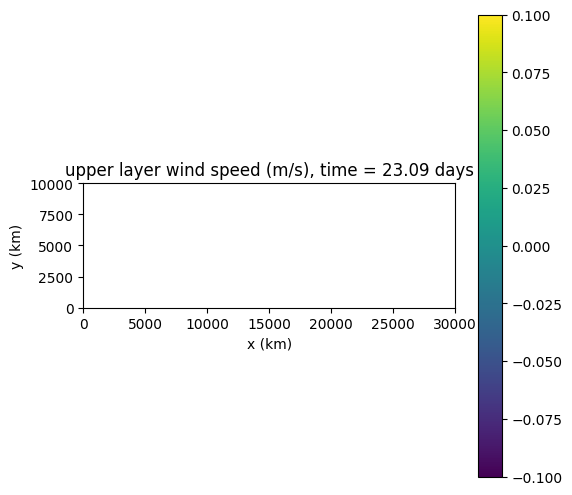

In [38]:
# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

When $U_1$ is increased, the jet stream becomes stronger and faster, with an enhanced mean flow velocity in the upper layer. This intensifies the north-south velocity shear, which amplifies baroclinic instability, allowing disturbances to grow more rapidly. As a result, the system exhibits faster instability development, with longer wavelength structures dominating due to the stronger advection of disturbances downstream. The interaction between the jet and storms also becomes more pronounced, as the stronger jet actively guides storms along its path and sharpens jet meanders.

### Decreasing $U_1$

In [46]:
# Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 5/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)


INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 5s, Rate: 9.0e+00/s


2024-12-27 14:09:51,233 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 5s, Rate: 9.0e+00/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 1s, Remaining: 5s, Rate: 8.4e+00/s


2024-12-27 14:09:51,714 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 1s, Remaining: 5s, Rate: 8.4e+00/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 1s, Remaining: 4s, Rate: 8.9e+00/s


2024-12-27 14:09:52,245 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 1s, Remaining: 4s, Rate: 8.9e+00/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 2s, Remaining: 4s, Rate: 9.1e+00/s


2024-12-27 14:09:52,776 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 2s, Remaining: 4s, Rate: 9.1e+00/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 2s, Remaining: 3s, Rate: 8.6e+00/s


2024-12-27 14:09:53,454 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 2s, Remaining: 3s, Rate: 8.6e+00/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 3s, Remaining: 3s, Rate: 8.9e+00/s


2024-12-27 14:09:53,919 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 3s, Remaining: 3s, Rate: 8.9e+00/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 3s, Remaining: 2s, Rate: 9.6e+00/s


2024-12-27 14:09:54,247 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 3s, Remaining: 2s, Rate: 9.6e+00/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 3s, Remaining: 1s, Rate: 1.0e+01/s


2024-12-27 14:09:54,576 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 3s, Remaining: 1s, Rate: 1.0e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 4s, Remaining: 1s, Rate: 1.1e+01/s


2024-12-27 14:09:54,873 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 4s, Remaining: 1s, Rate: 1.1e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 4s, Remaining: 0s, Rate: 1.1e+01/s


2024-12-27 14:09:55,160 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 4s, Remaining: 0s, Rate: 1.1e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 4s, Remaining: 0s, Rate: 1.1e+01/s


2024-12-27 14:09:55,335 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 4s, Remaining: 0s, Rate: 1.1e+01/s


INFO:__main__:Starting main loop


2024-12-27 14:09:55,345 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.562500e+03, dt=1.562500e+03


2024-12-27 14:09:55,512 __main__ 0/1 INFO :: Iteration=1, Time=1.562500e+03, dt=1.562500e+03


INFO:__main__:Iteration=21, Time=3.281250e+04, dt=1.562500e+03


2024-12-27 14:09:56,089 __main__ 0/1 INFO :: Iteration=21, Time=3.281250e+04, dt=1.562500e+03


INFO:__main__:Iteration=41, Time=6.406250e+04, dt=1.562500e+03


2024-12-27 14:09:56,688 __main__ 0/1 INFO :: Iteration=41, Time=6.406250e+04, dt=1.562500e+03


INFO:__main__:Iteration=61, Time=9.531250e+04, dt=1.562500e+03


2024-12-27 14:09:57,261 __main__ 0/1 INFO :: Iteration=61, Time=9.531250e+04, dt=1.562500e+03


INFO:__main__:Iteration=81, Time=1.265625e+05, dt=1.562500e+03


2024-12-27 14:09:57,834 __main__ 0/1 INFO :: Iteration=81, Time=1.265625e+05, dt=1.562500e+03


INFO:__main__:Iteration=101, Time=1.578125e+05, dt=1.562500e+03


2024-12-27 14:09:58,407 __main__ 0/1 INFO :: Iteration=101, Time=1.578125e+05, dt=1.562500e+03


INFO:__main__:Iteration=121, Time=1.890625e+05, dt=1.562500e+03


2024-12-27 14:09:58,974 __main__ 0/1 INFO :: Iteration=121, Time=1.890625e+05, dt=1.562500e+03


INFO:__main__:Iteration=141, Time=2.203125e+05, dt=1.562500e+03


2024-12-27 14:09:59,991 __main__ 0/1 INFO :: Iteration=141, Time=2.203125e+05, dt=1.562500e+03


INFO:__main__:Iteration=161, Time=2.515625e+05, dt=1.562500e+03


2024-12-27 14:10:01,131 __main__ 0/1 INFO :: Iteration=161, Time=2.515625e+05, dt=1.562500e+03


INFO:__main__:Iteration=181, Time=2.828125e+05, dt=1.562500e+03


2024-12-27 14:10:02,539 __main__ 0/1 INFO :: Iteration=181, Time=2.828125e+05, dt=1.562500e+03


INFO:__main__:Iteration=201, Time=3.140625e+05, dt=1.562500e+03


2024-12-27 14:10:03,828 __main__ 0/1 INFO :: Iteration=201, Time=3.140625e+05, dt=1.562500e+03


INFO:__main__:Iteration=221, Time=3.453125e+05, dt=1.562500e+03


2024-12-27 14:10:04,969 __main__ 0/1 INFO :: Iteration=221, Time=3.453125e+05, dt=1.562500e+03


INFO:__main__:Iteration=241, Time=3.765625e+05, dt=1.562500e+03


2024-12-27 14:10:05,866 __main__ 0/1 INFO :: Iteration=241, Time=3.765625e+05, dt=1.562500e+03


INFO:__main__:Iteration=261, Time=4.078125e+05, dt=1.562500e+03


2024-12-27 14:10:06,804 __main__ 0/1 INFO :: Iteration=261, Time=4.078125e+05, dt=1.562500e+03


INFO:__main__:Iteration=281, Time=4.390625e+05, dt=1.562500e+03


2024-12-27 14:10:07,626 __main__ 0/1 INFO :: Iteration=281, Time=4.390625e+05, dt=1.562500e+03


INFO:__main__:Iteration=301, Time=4.703125e+05, dt=1.562500e+03


2024-12-27 14:10:08,209 __main__ 0/1 INFO :: Iteration=301, Time=4.703125e+05, dt=1.562500e+03


INFO:__main__:Iteration=321, Time=5.015625e+05, dt=1.562500e+03


2024-12-27 14:10:08,762 __main__ 0/1 INFO :: Iteration=321, Time=5.015625e+05, dt=1.562500e+03


INFO:__main__:Iteration=341, Time=5.328125e+05, dt=1.562500e+03


2024-12-27 14:10:09,332 __main__ 0/1 INFO :: Iteration=341, Time=5.328125e+05, dt=1.562500e+03


INFO:__main__:Iteration=361, Time=5.640625e+05, dt=1.562500e+03


2024-12-27 14:10:09,887 __main__ 0/1 INFO :: Iteration=361, Time=5.640625e+05, dt=1.562500e+03


INFO:__main__:Iteration=381, Time=5.953125e+05, dt=1.562500e+03


2024-12-27 14:10:10,452 __main__ 0/1 INFO :: Iteration=381, Time=5.953125e+05, dt=1.562500e+03


INFO:__main__:Iteration=401, Time=6.265625e+05, dt=1.562500e+03


2024-12-27 14:10:11,035 __main__ 0/1 INFO :: Iteration=401, Time=6.265625e+05, dt=1.562500e+03


INFO:__main__:Iteration=421, Time=6.578125e+05, dt=1.562500e+03


2024-12-27 14:10:11,582 __main__ 0/1 INFO :: Iteration=421, Time=6.578125e+05, dt=1.562500e+03


INFO:__main__:Iteration=441, Time=6.890625e+05, dt=1.562500e+03


2024-12-27 14:10:12,181 __main__ 0/1 INFO :: Iteration=441, Time=6.890625e+05, dt=1.562500e+03


INFO:__main__:Iteration=461, Time=7.203125e+05, dt=1.562500e+03


2024-12-27 14:10:12,746 __main__ 0/1 INFO :: Iteration=461, Time=7.203125e+05, dt=1.562500e+03


INFO:__main__:Iteration=481, Time=7.515625e+05, dt=1.562500e+03


2024-12-27 14:10:13,321 __main__ 0/1 INFO :: Iteration=481, Time=7.515625e+05, dt=1.562500e+03


INFO:__main__:Iteration=501, Time=7.828125e+05, dt=1.562500e+03


2024-12-27 14:10:13,889 __main__ 0/1 INFO :: Iteration=501, Time=7.828125e+05, dt=1.562500e+03


INFO:__main__:Iteration=521, Time=8.140625e+05, dt=1.562500e+03


2024-12-27 14:10:14,477 __main__ 0/1 INFO :: Iteration=521, Time=8.140625e+05, dt=1.562500e+03


INFO:__main__:Iteration=541, Time=8.453125e+05, dt=1.562500e+03


2024-12-27 14:10:15,054 __main__ 0/1 INFO :: Iteration=541, Time=8.453125e+05, dt=1.562500e+03


INFO:__main__:Iteration=561, Time=8.765625e+05, dt=1.562500e+03


2024-12-27 14:10:15,631 __main__ 0/1 INFO :: Iteration=561, Time=8.765625e+05, dt=1.562500e+03


INFO:__main__:Iteration=581, Time=9.078125e+05, dt=1.562500e+03


2024-12-27 14:10:16,188 __main__ 0/1 INFO :: Iteration=581, Time=9.078125e+05, dt=1.562500e+03


INFO:__main__:Iteration=601, Time=9.390625e+05, dt=1.562500e+03


2024-12-27 14:10:16,752 __main__ 0/1 INFO :: Iteration=601, Time=9.390625e+05, dt=1.562500e+03


INFO:__main__:Iteration=621, Time=9.703125e+05, dt=1.562500e+03


2024-12-27 14:10:17,321 __main__ 0/1 INFO :: Iteration=621, Time=9.703125e+05, dt=1.562500e+03


INFO:__main__:Iteration=641, Time=1.001562e+06, dt=1.562500e+03


2024-12-27 14:10:18,196 __main__ 0/1 INFO :: Iteration=641, Time=1.001562e+06, dt=1.562500e+03


INFO:__main__:Iteration=661, Time=1.032812e+06, dt=1.562500e+03


2024-12-27 14:10:19,114 __main__ 0/1 INFO :: Iteration=661, Time=1.032812e+06, dt=1.562500e+03


INFO:__main__:Iteration=681, Time=1.064062e+06, dt=1.562500e+03


2024-12-27 14:10:20,089 __main__ 0/1 INFO :: Iteration=681, Time=1.064062e+06, dt=1.562500e+03


INFO:__main__:Iteration=701, Time=1.095312e+06, dt=1.562500e+03


2024-12-27 14:10:20,921 __main__ 0/1 INFO :: Iteration=701, Time=1.095312e+06, dt=1.562500e+03


INFO:__main__:Iteration=721, Time=1.126562e+06, dt=1.562500e+03


2024-12-27 14:10:21,497 __main__ 0/1 INFO :: Iteration=721, Time=1.126562e+06, dt=1.562500e+03


INFO:__main__:Iteration=741, Time=1.157812e+06, dt=1.562500e+03


2024-12-27 14:10:22,081 __main__ 0/1 INFO :: Iteration=741, Time=1.157812e+06, dt=1.562500e+03


INFO:__main__:Iteration=761, Time=1.189062e+06, dt=1.562500e+03


2024-12-27 14:10:22,661 __main__ 0/1 INFO :: Iteration=761, Time=1.189062e+06, dt=1.562500e+03


INFO:__main__:Iteration=781, Time=1.220312e+06, dt=1.562500e+03


2024-12-27 14:10:23,229 __main__ 0/1 INFO :: Iteration=781, Time=1.220312e+06, dt=1.562500e+03


INFO:__main__:Iteration=801, Time=1.251562e+06, dt=1.562500e+03


2024-12-27 14:10:23,809 __main__ 0/1 INFO :: Iteration=801, Time=1.251562e+06, dt=1.562500e+03


INFO:__main__:Iteration=821, Time=1.282812e+06, dt=1.562500e+03


2024-12-27 14:10:24,363 __main__ 0/1 INFO :: Iteration=821, Time=1.282812e+06, dt=1.562500e+03


INFO:__main__:Iteration=841, Time=1.314062e+06, dt=1.562500e+03


2024-12-27 14:10:24,946 __main__ 0/1 INFO :: Iteration=841, Time=1.314062e+06, dt=1.562500e+03


INFO:__main__:Iteration=861, Time=1.345312e+06, dt=1.562500e+03


2024-12-27 14:10:25,522 __main__ 0/1 INFO :: Iteration=861, Time=1.345312e+06, dt=1.562500e+03


INFO:__main__:Iteration=881, Time=1.376562e+06, dt=1.562500e+03


2024-12-27 14:10:26,132 __main__ 0/1 INFO :: Iteration=881, Time=1.376562e+06, dt=1.562500e+03


INFO:__main__:Iteration=901, Time=1.407812e+06, dt=1.562500e+03


2024-12-27 14:10:26,715 __main__ 0/1 INFO :: Iteration=901, Time=1.407812e+06, dt=1.562500e+03


INFO:__main__:Iteration=921, Time=1.439062e+06, dt=1.562500e+03


2024-12-27 14:10:27,282 __main__ 0/1 INFO :: Iteration=921, Time=1.439062e+06, dt=1.562500e+03


INFO:__main__:Iteration=941, Time=1.470312e+06, dt=1.562500e+03


2024-12-27 14:10:27,854 __main__ 0/1 INFO :: Iteration=941, Time=1.470312e+06, dt=1.562500e+03


INFO:__main__:Iteration=961, Time=1.501562e+06, dt=1.562500e+03


2024-12-27 14:10:28,429 __main__ 0/1 INFO :: Iteration=961, Time=1.501562e+06, dt=1.562500e+03


INFO:__main__:Iteration=981, Time=1.532812e+06, dt=1.562500e+03


2024-12-27 14:10:29,007 __main__ 0/1 INFO :: Iteration=981, Time=1.532812e+06, dt=1.562500e+03


INFO:__main__:Iteration=1001, Time=1.564062e+06, dt=1.562500e+03


2024-12-27 14:10:29,582 __main__ 0/1 INFO :: Iteration=1001, Time=1.564062e+06, dt=1.562500e+03


INFO:__main__:Iteration=1021, Time=1.595312e+06, dt=1.562500e+03


2024-12-27 14:10:30,169 __main__ 0/1 INFO :: Iteration=1021, Time=1.595312e+06, dt=1.562500e+03


INFO:__main__:Iteration=1041, Time=1.626562e+06, dt=1.562500e+03


2024-12-27 14:10:30,756 __main__ 0/1 INFO :: Iteration=1041, Time=1.626562e+06, dt=1.562500e+03


INFO:__main__:Iteration=1061, Time=1.657812e+06, dt=1.562500e+03


2024-12-27 14:10:31,677 __main__ 0/1 INFO :: Iteration=1061, Time=1.657812e+06, dt=1.562500e+03


INFO:__main__:Iteration=1081, Time=1.689062e+06, dt=1.562500e+03


2024-12-27 14:10:32,597 __main__ 0/1 INFO :: Iteration=1081, Time=1.689062e+06, dt=1.562500e+03


INFO:__main__:Iteration=1101, Time=1.720312e+06, dt=1.562500e+03


2024-12-27 14:10:33,584 __main__ 0/1 INFO :: Iteration=1101, Time=1.720312e+06, dt=1.562500e+03


INFO:__main__:Iteration=1121, Time=1.751562e+06, dt=1.562500e+03


2024-12-27 14:10:34,343 __main__ 0/1 INFO :: Iteration=1121, Time=1.751562e+06, dt=1.562500e+03


INFO:__main__:Iteration=1141, Time=1.782812e+06, dt=1.562500e+03


2024-12-27 14:10:34,905 __main__ 0/1 INFO :: Iteration=1141, Time=1.782812e+06, dt=1.562500e+03


INFO:__main__:Iteration=1161, Time=1.814062e+06, dt=1.562500e+03


2024-12-27 14:10:35,476 __main__ 0/1 INFO :: Iteration=1161, Time=1.814062e+06, dt=1.562500e+03


INFO:__main__:Iteration=1181, Time=1.845312e+06, dt=1.562500e+03


2024-12-27 14:10:36,056 __main__ 0/1 INFO :: Iteration=1181, Time=1.845312e+06, dt=1.562500e+03


INFO:__main__:Iteration=1201, Time=1.876562e+06, dt=1.562500e+03


2024-12-27 14:10:36,614 __main__ 0/1 INFO :: Iteration=1201, Time=1.876562e+06, dt=1.562500e+03


INFO:__main__:Iteration=1221, Time=1.907812e+06, dt=1.562500e+03


2024-12-27 14:10:37,202 __main__ 0/1 INFO :: Iteration=1221, Time=1.907812e+06, dt=1.562500e+03


INFO:__main__:Iteration=1241, Time=1.939062e+06, dt=1.562500e+03


2024-12-27 14:10:37,764 __main__ 0/1 INFO :: Iteration=1241, Time=1.939062e+06, dt=1.562500e+03


INFO:__main__:Iteration=1261, Time=1.970312e+06, dt=1.562500e+03


2024-12-27 14:10:38,344 __main__ 0/1 INFO :: Iteration=1261, Time=1.970312e+06, dt=1.562500e+03


INFO:solvers:Simulation stop time reached.


2024-12-27 14:10:38,868 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1280


2024-12-27 14:10:38,872 solvers 0/1 INFO :: Final iteration: 1280


INFO:solvers:Final sim time: 2000000.0


2024-12-27 14:10:38,876 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 4.85 sec


2024-12-27 14:10:38,879 solvers 0/1 INFO :: Setup time (init - iter 0): 4.85 sec


INFO:solvers:Warmup time (iter 0-10): 0.4109 sec


2024-12-27 14:10:38,882 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.4109 sec


INFO:solvers:Run time (iter 10-end): 43.11 sec


2024-12-27 14:10:38,884 solvers 0/1 INFO :: Run time (iter 10-end): 43.11 sec


INFO:solvers:CPU time (iter 10-end): 0.01197 cpu-hr


2024-12-27 14:10:38,886 solvers 0/1 INFO :: CPU time (iter 10-end): 0.01197 cpu-hr


INFO:solvers:Speed: 2.083e+06 mode-stages/cpu-sec


2024-12-27 14:10:38,888 solvers 0/1 INFO :: Speed: 2.083e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-27 14:10:48,355 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmprhf3f1fa/temp.m4v


2024-12-27 14:10:48,360 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmprhf3f1fa/temp.m4v


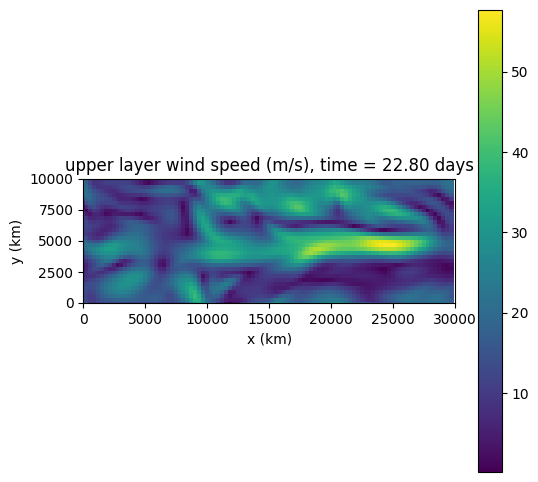

In [47]:
# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

 decreasing $U_1$ weakens the jet stream, leading to a slower and less coherent flow. The reduced velocity shear diminishes baroclinic instability, resulting in weaker and less frequent disturbances. With slower wave propagation, shorter wavelength features become more prominent, and the advection of disturbances is less effective. The weaker jet also decouples from storms, reducing the mutual influence between the two and resulting in broader, less defined jet meanders. Furthermore, the overall energy level in the system declines, leading to reduced turbulence generation and a shift in energy transfer between scales.

### Increasing Jet Width

In [53]:
# Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 400

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)


INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 3s, Rate: 1.6e+01/s


2024-12-27 14:28:03,251 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 3s, Rate: 1.6e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 3s, Rate: 1.3e+01/s


2024-12-27 14:28:03,576 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 3s, Rate: 1.3e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 1s, Remaining: 3s, Rate: 1.4e+01/s


2024-12-27 14:28:03,899 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 1s, Remaining: 3s, Rate: 1.4e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 1.5e+01/s


2024-12-27 14:28:04,212 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 1.5e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 2s, Rate: 1.5e+01/s


2024-12-27 14:28:04,530 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 2s, Rate: 1.5e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 2s, Remaining: 2s, Rate: 1.5e+01/s


2024-12-27 14:28:04,836 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 2s, Remaining: 2s, Rate: 1.5e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 2s, Remaining: 1s, Rate: 1.3e+01/s


2024-12-27 14:28:05,473 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 2s, Remaining: 1s, Rate: 1.3e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 3s, Remaining: 1s, Rate: 1.3e+01/s


2024-12-27 14:28:05,916 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 3s, Remaining: 1s, Rate: 1.3e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 4s, Remaining: 1s, Rate: 9.6e+00/s


2024-12-27 14:28:07,343 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 4s, Remaining: 1s, Rate: 9.6e+00/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 5s, Remaining: 0s, Rate: 9.7e+00/s


2024-12-27 14:28:07,837 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 5s, Remaining: 0s, Rate: 9.7e+00/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 5s, Remaining: 0s, Rate: 9.5e+00/s


2024-12-27 14:28:08,219 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 5s, Remaining: 0s, Rate: 9.5e+00/s


INFO:__main__:Starting main loop


2024-12-27 14:28:08,242 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2024-12-27 14:28:08,716 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2024-12-27 14:28:09,944 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2024-12-27 14:28:10,514 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2024-12-27 14:28:11,104 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2024-12-27 14:28:11,700 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2024-12-27 14:28:12,300 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2024-12-27 14:28:12,876 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2024-12-27 14:28:13,453 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2024-12-27 14:28:14,052 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2024-12-27 14:28:14,648 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2024-12-27 14:28:15,243 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2024-12-27 14:28:16,084 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2024-12-27 14:28:16,669 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2024-12-27 14:28:17,290 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2024-12-27 14:28:17,906 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2024-12-27 14:28:18,509 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2024-12-27 14:28:19,195 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2024-12-27 14:28:20,178 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2024-12-27 14:28:21,110 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2024-12-27 14:28:22,101 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2024-12-27 14:28:22,845 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2024-12-27 14:28:23,436 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2024-12-27 14:28:24,028 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2024-12-27 14:28:24,639 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2024-12-27 14:28:25,249 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2024-12-27 14:28:25,870 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2024-12-27 14:28:26,500 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2024-12-27 14:28:27,116 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2024-12-27 14:28:27,730 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2024-12-27 14:28:28,369 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2024-12-27 14:28:28,984 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2024-12-27 14:28:29,595 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2024-12-27 14:28:30,188 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2024-12-27 14:28:30,781 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2024-12-27 14:28:31,404 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2024-12-27 14:28:32,002 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2024-12-27 14:28:32,752 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2024-12-27 14:28:33,694 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2024-12-27 14:28:34,651 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2024-12-27 14:28:35,627 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2024-12-27 14:28:36,346 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2024-12-27 14:28:36,987 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2024-12-27 14:28:37,624 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2024-12-27 14:28:38,235 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2024-12-27 14:28:38,833 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2024-12-27 14:28:39,436 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2024-12-27 14:28:40,486 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2024-12-27 14:28:41,491 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2024-12-27 14:28:42,566 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2024-12-27 14:28:43,614 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2024-12-27 14:28:44,658 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2024-12-27 14:28:45,801 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2024-12-27 14:28:46,686 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2024-12-27 14:28:47,597 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2024-12-27 14:28:48,595 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2024-12-27 14:28:49,468 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2024-12-27 14:28:50,068 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2024-12-27 14:28:50,653 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2024-12-27 14:28:51,293 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2024-12-27 14:28:51,896 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2024-12-27 14:28:52,496 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2024-12-27 14:28:53,072 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2024-12-27 14:28:53,656 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2024-12-27 14:28:54,251 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2024-12-27 14:28:54,835 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2024-12-27 14:28:55,438 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2024-12-27 14:28:56,026 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2024-12-27 14:28:56,622 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2024-12-27 14:28:57,195 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2024-12-27 14:28:57,802 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2024-12-27 14:28:58,425 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2024-12-27 14:28:59,034 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2024-12-27 14:28:59,883 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2024-12-27 14:29:00,807 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2024-12-27 14:29:01,770 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2024-12-27 14:29:02,672 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2024-12-27 14:29:03,236 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2024-12-27 14:29:03,857 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2024-12-27 14:29:04,435 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2024-12-27 14:29:05,034 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2024-12-27 14:29:05,635 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2024-12-27 14:29:06,216 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2024-12-27 14:29:06,830 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2024-12-27 14:29:07,440 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2024-12-27 14:29:08,049 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2024-12-27 14:29:08,661 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2024-12-27 14:29:09,253 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2024-12-27 14:29:09,851 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2024-12-27 14:29:10,447 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2024-12-27 14:29:11,068 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2024-12-27 14:29:11,666 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2024-12-27 14:29:12,276 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2024-12-27 14:29:13,102 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2024-12-27 14:29:14,013 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2024-12-27 14:29:14,969 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2024-12-27 14:29:15,970 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2024-12-27 14:29:16,619 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2024-12-27 14:29:17,225 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2024-12-27 14:29:17,809 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2024-12-27 14:29:18,411 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2024-12-27 14:29:19,015 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2024-12-27 14:29:19,614 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2024-12-27 14:29:20,217 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2024-12-27 14:29:20,807 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2024-12-27 14:29:21,415 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2024-12-27 14:29:22,027 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2024-12-27 14:29:22,645 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2024-12-27 14:29:23,256 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2024-12-27 14:29:23,853 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2024-12-27 14:29:24,468 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2024-12-27 14:29:25,082 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2024-12-27 14:29:25,684 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2024-12-27 14:29:26,414 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2024-12-27 14:29:27,339 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2024-12-27 14:29:28,247 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2024-12-27 14:29:29,209 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2024-12-27 14:29:29,957 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2024-12-27 14:29:30,545 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2024-12-27 14:29:31,120 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2024-12-27 14:29:31,736 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2024-12-27 14:29:32,331 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2024-12-27 14:29:32,949 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2024-12-27 14:29:33,517 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2024-12-27 14:29:34,138 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2024-12-27 14:29:34,726 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2024-12-27 14:29:35,301 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2024-12-27 14:29:35,877 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2024-12-27 14:29:36,443 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2024-12-27 14:29:37,003 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2024-12-27 14:29:37,007 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2024-12-27 14:29:37,012 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 5.167 sec


2024-12-27 14:29:37,015 solvers 0/1 INFO :: Setup time (init - iter 0): 5.167 sec


INFO:solvers:Warmup time (iter 0-10): 1.161 sec


2024-12-27 14:29:37,017 solvers 0/1 INFO :: Warmup time (iter 0-10): 1.161 sec


INFO:solvers:Run time (iter 10-end): 87.59 sec


2024-12-27 14:29:37,024 solvers 0/1 INFO :: Run time (iter 10-end): 87.59 sec


INFO:solvers:CPU time (iter 10-end): 0.02433 cpu-hr


2024-12-27 14:29:37,026 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02433 cpu-hr


INFO:solvers:Speed: 2.058e+06 mode-stages/cpu-sec


2024-12-27 14:29:37,029 solvers 0/1 INFO :: Speed: 2.058e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-27 14:07:51,043 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp54w2_ig_/temp.m4v


2024-12-27 14:07:51,047 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp54w2_ig_/temp.m4v


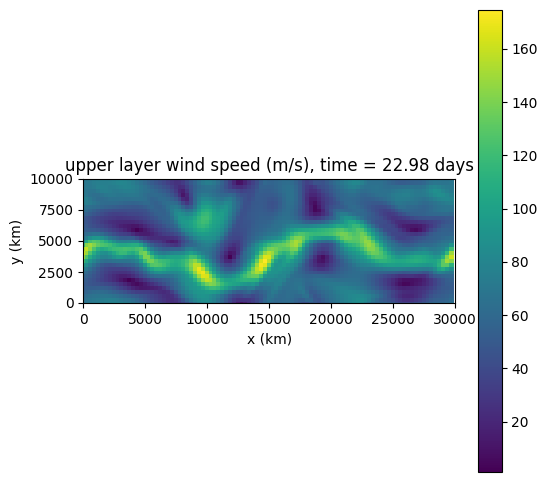

In [45]:
# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

When the width of the jet stream increases, the north-south velocity shear spreads over a broader spatial extent, resulting in a more diffuse and less coherent jet. The energy transfer shifts toward larger-scale motions, reducing the intensity of smaller disturbances. As a result, the jet stream travels wiggly to the right without significant interaction with storms, while the upper and lower layers predominantly move to the left.

### Decreasing the Jet Width

In [54]:
# Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 50

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)


INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.8e+01/s


2024-12-27 14:33:15,490 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 2.6e+01/s


2024-12-27 14:33:15,650 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 2.7e+01/s


2024-12-27 14:33:15,831 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 2.7e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 1s, Rate: 2.7e+01/s


2024-12-27 14:33:16,002 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 1s, Rate: 2.7e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 2.7e+01/s


2024-12-27 14:33:16,183 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 2.7e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s


2024-12-27 14:33:16,361 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s


2024-12-27 14:33:16,534 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 2.8e+01/s


2024-12-27 14:33:16,716 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 2.8e+01/s


2024-12-27 14:33:16,904 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.8e+01/s


2024-12-27 14:33:17,077 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.8e+01/s


2024-12-27 14:33:17,190 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.8e+01/s


INFO:__main__:Starting main loop


2024-12-27 14:33:17,202 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2024-12-27 14:33:17,341 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2024-12-27 14:33:17,951 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2024-12-27 14:33:18,521 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2024-12-27 14:33:19,112 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2024-12-27 14:33:19,712 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2024-12-27 14:33:20,296 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2024-12-27 14:33:20,888 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2024-12-27 14:33:21,467 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2024-12-27 14:33:22,061 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2024-12-27 14:33:22,650 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2024-12-27 14:33:23,248 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2024-12-27 14:33:24,086 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2024-12-27 14:33:24,994 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2024-12-27 14:33:25,960 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2024-12-27 14:33:26,835 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2024-12-27 14:33:27,423 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2024-12-27 14:33:28,001 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2024-12-27 14:33:28,603 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2024-12-27 14:33:29,199 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2024-12-27 14:33:29,784 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2024-12-27 14:33:30,384 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2024-12-27 14:33:30,983 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2024-12-27 14:33:32,050 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2024-12-27 14:33:33,036 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2024-12-27 14:33:34,046 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2024-12-27 14:33:35,057 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2024-12-27 14:33:36,065 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2024-12-27 14:33:37,225 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2024-12-27 14:33:38,762 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2024-12-27 14:33:39,759 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2024-12-27 14:33:40,662 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2024-12-27 14:33:41,251 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2024-12-27 14:33:41,866 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2024-12-27 14:33:42,444 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2024-12-27 14:33:43,055 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2024-12-27 14:33:43,663 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2024-12-27 14:33:44,262 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2024-12-27 14:33:44,870 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2024-12-27 14:33:45,447 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2024-12-27 14:33:46,048 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2024-12-27 14:33:46,626 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2024-12-27 14:33:47,234 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2024-12-27 14:33:47,838 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2024-12-27 14:33:48,430 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2024-12-27 14:33:49,039 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2024-12-27 14:33:49,623 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2024-12-27 14:33:50,221 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2024-12-27 14:33:50,997 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2024-12-27 14:33:51,921 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2024-12-27 14:33:52,868 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2024-12-27 14:33:53,844 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2024-12-27 14:33:54,453 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2024-12-27 14:33:55,051 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2024-12-27 14:33:55,629 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2024-12-27 14:33:56,239 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2024-12-27 14:33:56,843 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2024-12-27 14:33:57,442 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2024-12-27 14:33:58,036 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2024-12-27 14:33:58,656 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2024-12-27 14:33:59,260 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2024-12-27 14:33:59,859 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2024-12-27 14:34:00,451 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2024-12-27 14:34:01,049 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2024-12-27 14:34:01,659 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2024-12-27 14:34:02,256 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2024-12-27 14:34:02,846 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2024-12-27 14:34:03,451 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2024-12-27 14:34:04,176 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2024-12-27 14:34:05,116 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2024-12-27 14:34:06,041 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2024-12-27 14:34:07,034 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2024-12-27 14:34:07,775 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2024-12-27 14:34:08,389 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2024-12-27 14:34:08,974 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2024-12-27 14:34:09,564 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2024-12-27 14:34:10,159 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2024-12-27 14:34:10,753 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2024-12-27 14:34:11,349 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2024-12-27 14:34:11,948 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2024-12-27 14:34:12,530 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2024-12-27 14:34:13,118 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2024-12-27 14:34:13,713 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2024-12-27 14:34:14,295 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2024-12-27 14:34:14,884 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2024-12-27 14:34:15,463 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2024-12-27 14:34:16,056 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2024-12-27 14:34:16,633 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2024-12-27 14:34:17,237 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2024-12-27 14:34:18,098 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2024-12-27 14:34:19,019 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2024-12-27 14:34:21,217 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2024-12-27 14:34:22,482 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2024-12-27 14:34:23,140 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2024-12-27 14:34:23,717 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2024-12-27 14:34:24,311 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2024-12-27 14:34:24,894 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2024-12-27 14:34:25,486 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2024-12-27 14:34:26,075 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2024-12-27 14:34:26,678 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2024-12-27 14:34:27,285 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2024-12-27 14:34:27,875 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2024-12-27 14:34:28,496 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2024-12-27 14:34:29,103 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2024-12-27 14:34:29,716 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2024-12-27 14:34:30,322 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2024-12-27 14:34:30,903 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2024-12-27 14:34:31,624 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2024-12-27 14:34:32,584 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2024-12-27 14:34:33,504 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2024-12-27 14:34:34,529 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2024-12-27 14:34:35,118 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2024-12-27 14:34:35,716 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2024-12-27 14:34:36,300 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2024-12-27 14:34:36,902 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2024-12-27 14:34:37,486 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2024-12-27 14:34:38,095 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2024-12-27 14:34:38,725 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2024-12-27 14:34:39,327 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2024-12-27 14:34:39,943 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2024-12-27 14:34:40,545 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2024-12-27 14:34:41,157 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2024-12-27 14:34:41,762 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2024-12-27 14:34:42,338 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2024-12-27 14:34:42,937 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2024-12-27 14:34:43,532 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2024-12-27 14:34:44,133 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2024-12-27 14:34:44,880 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2024-12-27 14:34:45,819 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2024-12-27 14:34:46,720 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2024-12-27 14:34:46,724 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2024-12-27 14:34:46,729 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 1.808 sec


2024-12-27 14:34:46,731 solvers 0/1 INFO :: Setup time (init - iter 0): 1.808 sec


INFO:solvers:Warmup time (iter 0-10): 0.3928 sec


2024-12-27 14:34:46,733 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.3928 sec


INFO:solvers:Run time (iter 10-end): 89.12 sec


2024-12-27 14:34:46,735 solvers 0/1 INFO :: Run time (iter 10-end): 89.12 sec


INFO:solvers:CPU time (iter 10-end): 0.02476 cpu-hr


2024-12-27 14:34:46,738 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02476 cpu-hr


INFO:solvers:Speed: 2.022e+06 mode-stages/cpu-sec


2024-12-27 14:34:46,740 solvers 0/1 INFO :: Speed: 2.022e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-27 14:34:52,876 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpeffr8my7/temp.m4v


2024-12-27 14:34:52,880 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpeffr8my7/temp.m4v


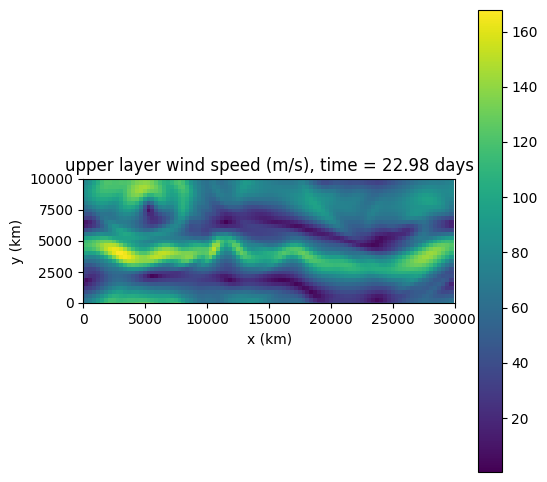

In [55]:
# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


Decreasing the width of the jet stream concentrates the velocity shear into a little bit narrower region. This leads to slower-speed disturbances. Similarly, jet stream travels wiggly to the right without significant interaction with storms, while the upper and lower layers predominantly move to the left.

# 3. Forced QG flow

In the atmosphere, differential heating between the equator and poles maintains a north/south temperature gradient. This temperature gradient is represented by the north/south gradient in layer heights and potential vorticity in the 2-layer QG model. We can represent differential heating and cooling in the 2-layer QG model by adding terms that 'relax' the potential vorticity back to a prescribed field.

### 3.1 Student investigation
<a id='section3pt1'></a>

In the code box below, copy the code from Part 2 and modify it to include the following terms:
$$ \frac{\partial q_1}{\partial t} + \ldots = \ldots - \frac{1}{\tau}\left(q_1 - q_1(t=0)\right) $$

$$ \frac{\partial q_2}{\partial t} + \ldots = \ldots - \frac{1}{\tau}\left(q_2 - q_2(t=0)\right) $$

where $q_i(t=0)$ are the initial conditions (q1_ic and q2_ic in the script) and $\tau$ is a timescale which you should specify. A timescale of $\tau=36$ hours should be a good starting point. In the absence of any other terms, this additional forcing term will cause $q_1$ and $q_2$ to 'relax' exponentially back to the initial conditions with an e-folding timescale equal to $\tau$.

Climate change is expected to reduce the equator to pole temperature contrast as the high latitudes warm faster than the rest of the planet. This will have impacts on the intensity and dynamics of storms. Experiment with this by changing the pole to equator gradient in the prescribed initial potential vorticity. Specify which dimensional parameter you chose to vary and discuss how it relates to the north/south temperature gradient. What happens to the jet stream and the storms as you reduce the potential vorticity gradient?

INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 4s, Rate: 1.1e+01/s


2024-12-27 13:59:06,640 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 4s, Rate: 1.1e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 4s, Rate: 1.1e+01/s


2024-12-27 13:59:06,995 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 4s, Rate: 1.1e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 1s, Remaining: 3s, Rate: 1.2e+01/s


2024-12-27 13:59:07,356 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 1s, Remaining: 3s, Rate: 1.2e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 3s, Rate: 1.3e+01/s


2024-12-27 13:59:07,712 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 3s, Rate: 1.3e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 2s, Remaining: 2s, Rate: 1.2e+01/s


2024-12-27 13:59:08,147 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 2s, Remaining: 2s, Rate: 1.2e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 2s, Remaining: 2s, Rate: 1.3e+01/s


2024-12-27 13:59:08,486 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 2s, Remaining: 2s, Rate: 1.3e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 2s, Remaining: 1s, Rate: 1.3e+01/s


2024-12-27 13:59:08,867 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 2s, Remaining: 1s, Rate: 1.3e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 3s, Remaining: 1s, Rate: 1.3e+01/s


2024-12-27 13:59:09,156 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 3s, Remaining: 1s, Rate: 1.3e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 3s, Remaining: 1s, Rate: 1.4e+01/s


2024-12-27 13:59:09,442 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 3s, Remaining: 1s, Rate: 1.4e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 3s, Remaining: 0s, Rate: 1.5e+01/s


2024-12-27 13:59:09,612 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 3s, Remaining: 0s, Rate: 1.5e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 3s, Remaining: 0s, Rate: 1.5e+01/s


2024-12-27 13:59:09,728 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 3s, Remaining: 0s, Rate: 1.5e+01/s


INFO:__main__:Starting main loop


2024-12-27 13:59:09,742 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2024-12-27 13:59:09,900 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2024-12-27 13:59:10,508 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2024-12-27 13:59:11,292 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2024-12-27 13:59:12,248 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2024-12-27 13:59:13,237 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2024-12-27 13:59:14,741 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2024-12-27 13:59:15,715 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2024-12-27 13:59:16,760 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2024-12-27 13:59:17,971 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2024-12-27 13:59:19,083 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2024-12-27 13:59:19,855 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2024-12-27 13:59:20,475 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2024-12-27 13:59:21,116 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2024-12-27 13:59:21,760 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2024-12-27 13:59:22,397 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2024-12-27 13:59:23,024 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2024-12-27 13:59:23,643 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2024-12-27 13:59:24,259 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2024-12-27 13:59:25,091 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2024-12-27 13:59:26,044 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2024-12-27 13:59:27,055 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2024-12-27 13:59:27,925 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2024-12-27 13:59:28,542 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2024-12-27 13:59:29,159 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2024-12-27 13:59:29,780 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2024-12-27 13:59:30,418 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2024-12-27 13:59:31,063 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2024-12-27 13:59:31,728 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2024-12-27 13:59:32,365 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2024-12-27 13:59:33,007 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2024-12-27 13:59:33,630 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2024-12-27 13:59:34,246 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2024-12-27 13:59:34,860 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2024-12-27 13:59:35,464 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2024-12-27 13:59:36,075 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2024-12-27 13:59:36,696 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2024-12-27 13:59:37,306 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2024-12-27 13:59:38,094 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2024-12-27 13:59:39,027 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2024-12-27 13:59:39,998 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2024-12-27 13:59:41,015 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2024-12-27 13:59:41,702 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2024-12-27 13:59:42,342 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2024-12-27 13:59:42,963 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2024-12-27 13:59:43,572 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2024-12-27 13:59:44,203 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2024-12-27 13:59:44,826 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2024-12-27 13:59:45,435 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2024-12-27 13:59:46,058 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2024-12-27 13:59:46,643 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2024-12-27 13:59:47,262 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2024-12-27 13:59:47,843 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2024-12-27 13:59:48,461 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2024-12-27 13:59:49,082 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2024-12-27 13:59:49,702 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2024-12-27 13:59:50,316 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2024-12-27 13:59:50,925 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2024-12-27 13:59:51,760 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2024-12-27 13:59:52,712 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2024-12-27 13:59:53,707 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2024-12-27 13:59:54,674 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2024-12-27 13:59:55,289 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2024-12-27 13:59:55,906 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2024-12-27 13:59:56,527 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2024-12-27 13:59:57,147 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2024-12-27 13:59:57,752 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2024-12-27 13:59:58,379 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2024-12-27 13:59:58,991 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2024-12-27 13:59:59,617 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2024-12-27 14:00:00,255 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2024-12-27 14:00:00,898 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2024-12-27 14:00:01,534 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2024-12-27 14:00:02,160 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2024-12-27 14:00:02,784 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2024-12-27 14:00:03,385 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2024-12-27 14:00:04,019 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2024-12-27 14:00:04,691 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2024-12-27 14:00:05,691 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2024-12-27 14:00:06,671 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2024-12-27 14:00:07,699 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2024-12-27 14:00:08,500 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2024-12-27 14:00:09,163 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2024-12-27 14:00:09,759 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2024-12-27 14:00:10,381 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2024-12-27 14:00:11,002 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2024-12-27 14:00:11,612 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2024-12-27 14:00:12,237 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2024-12-27 14:00:12,845 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2024-12-27 14:00:13,464 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2024-12-27 14:00:14,076 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2024-12-27 14:00:14,691 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2024-12-27 14:00:15,309 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2024-12-27 14:00:15,928 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2024-12-27 14:00:16,572 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2024-12-27 14:00:17,215 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2024-12-27 14:00:17,846 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2024-12-27 14:00:18,680 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2024-12-27 14:00:19,635 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2024-12-27 14:00:20,648 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2024-12-27 14:00:21,573 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2024-12-27 14:00:22,187 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2024-12-27 14:00:22,809 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2024-12-27 14:00:23,408 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2024-12-27 14:00:24,019 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2024-12-27 14:00:24,634 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2024-12-27 14:00:25,251 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2024-12-27 14:00:25,890 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2024-12-27 14:00:26,526 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2024-12-27 14:00:27,146 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2024-12-27 14:00:27,758 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2024-12-27 14:00:28,398 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2024-12-27 14:00:29,016 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2024-12-27 14:00:29,644 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2024-12-27 14:00:30,240 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2024-12-27 14:00:30,853 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2024-12-27 14:00:31,534 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2024-12-27 14:00:32,581 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2024-12-27 14:00:33,555 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2024-12-27 14:00:34,618 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2024-12-27 14:00:35,234 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2024-12-27 14:00:35,835 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2024-12-27 14:00:36,477 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2024-12-27 14:00:37,110 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2024-12-27 14:00:37,737 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2024-12-27 14:00:38,405 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2024-12-27 14:00:39,030 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2024-12-27 14:00:39,651 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2024-12-27 14:00:40,287 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2024-12-27 14:00:40,897 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2024-12-27 14:00:40,901 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2024-12-27 14:00:40,909 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 3.463 sec


2024-12-27 14:00:40,913 solvers 0/1 INFO :: Setup time (init - iter 0): 3.463 sec


INFO:solvers:Warmup time (iter 0-10): 0.4342 sec


2024-12-27 14:00:40,917 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.4342 sec


INFO:solvers:Run time (iter 10-end): 90.72 sec


2024-12-27 14:00:40,921 solvers 0/1 INFO :: Run time (iter 10-end): 90.72 sec


INFO:solvers:CPU time (iter 10-end): 0.0252 cpu-hr


2024-12-27 14:00:40,923 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0252 cpu-hr


INFO:solvers:Speed: 1.987e+06 mode-stages/cpu-sec


2024-12-27 14:00:40,927 solvers 0/1 INFO :: Speed: 1.987e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-27 14:00:41,316 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpw5y6z15l/temp.m4v


2024-12-27 14:00:41,322 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpw5y6z15l/temp.m4v


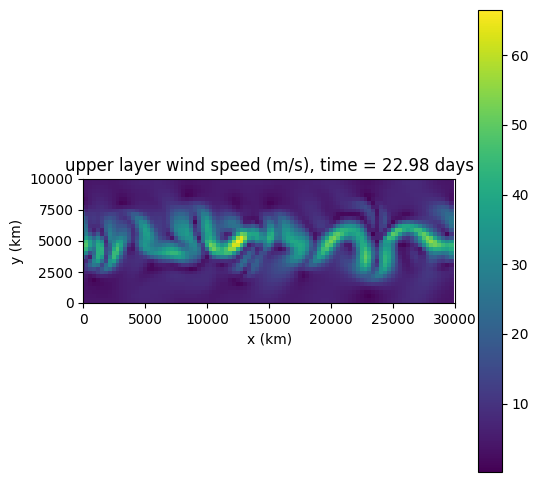

In [40]:
# Copy and paste the code from section 2.1 here and modify to add the relaxation terms.
# Also, paste the code to visualize the results (or create a new code box below)
# Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200
tau_psi1 = dist.Field(name='tau_psi1')
tau = 36*3600

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1)-(q1-q1_ic)/tau")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2)-(q2-q2_ic)/tau")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)

# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


The jet stream concentrates the velocity shear into a narrower region, steepening the gradient and intensifying baroclinic instability. This leads to more dynamic system. The narrower jet develops a sharper and more pronounced core, with higher wind speeds confined to a smaller area. Stronger gradients enhance the coupling between the jet and storms, resulting in more pronounced jet meanders and tighter storm-guided transport along the jet stream. There is no clear indication of stablise.

In the experiment, when adjusting the pole-to-equator gradient in the initial potential vorticity, the dimensional parameter being modified is the potential vorticity gradient ($ \frac{\partial q}{\partial y} $), which is directly linked to the north-south temperature gradient. This relationship exists because potential vorticity ($ q $) in a two-layer quasi-geostrophic system depends on layer thickness ($ h $), and layer thickness is influenced by the temperature gradient through the thermal wind balance and hydrostatic equations. Specifically, a stronger temperature gradient between the equator and the poles leads to steeper layer thickness gradients, resulting in a larger potential vorticity gradient.

Reducing the potential vorticity gradient is equivalent to decreasing the north-south temperature gradient, which affects the dynamics of the jet stream and storms. A smaller potential vorticity gradient weakens the jet stream, reduces wind speeds, and makes the structure less coherent. The weakened baroclinic instability suppresses the growth of disturbances, leading to slower storm development. Additionally, the jet stream becomes more prone to meandering and forms a snake-like pattern, as the weaker gradient provides less resistance to perturbations.

From a theoretical perspective, the potential vorticity gradient is a key driver of dynamical instability in the troposphere. Reducing the gradient lowers the available energy for cyclonic development, which decreases the intensity and impact of storms.

In summary, although the potential vorticity gradient and the temperature gradient are not entirely equivalent, their close connection through layer thickness and atmospheric structure suggests that reducing the potential vorticity gradient can effectively simulate the effects of a weakened north-south temperature gradient, with significant implications for jet stream behavior and storm activity.